# End-to-end BO with (s, r, delta) on a small grid

This notebook mirrors the end-to-end BO flow, but uses the (s, r, delta) parameterization
with a small 3km x 3km grid (120x120) and short evolution time (T=100s).

We run:
1) a heuristic-only optimization using SR heuristics
2) a BO optimization using the SR search space

The notebook is verbose and plots at each step to validate the mapping.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from fire_model.ca import FireEnv, CAFireModel, FireState
from fire_model.bo import RetardantDropBayesOpt

np.set_printoptions(precision=3, suppress=True)
plt.rcParams["figure.dpi"] = 120

rng = np.random.default_rng(4)

In [3]:
# Helper: plot drop placements (x,y,phi) on the search mask.

def plot_drop_overlay(mask, params, title):
    plt.figure(figsize=(5.5, 5))
    plt.imshow(mask.T, origin="lower", aspect="equal", cmap="Greys", alpha=0.25)
    if params.size:
        plt.quiver(
            params[:, 0],
            params[:, 1],
            np.cos(params[:, 2]),
            np.sin(params[:, 2]),
            angles="xy",
            scale_units="xy",
            scale=0.35,
            color="tab:blue",
            width=0.004,
        )
    plt.title(title)
    plt.tight_layout()
    plt.show()


def render_retardant(model, params, title):
    state = FireState(
        burning=np.zeros((1, model.env.grid_size[0], model.env.grid_size[1]), dtype=bool),
        burned=np.zeros((1, model.env.grid_size[0], model.env.grid_size[1]), dtype=bool),
        burn_remaining_s=np.zeros((1, model.env.grid_size[0], model.env.grid_size[1]), dtype=float),
        retardant=np.zeros((1, model.env.grid_size[0], model.env.grid_size[1]), dtype=float),
        t=0,
    )
    model.apply_retardant_cartesian(
        state,
        params,
        drop_w_km=model.env.drop_w_km,
        drop_h_km=model.env.drop_h_km,
        amount=1.0,
        avoid_burning=False,
        forbid_burning_overlap=False,
        burning_prob_threshold=0.25,
        cell_cap=None,
    )
    plt.figure(figsize=(5.5, 5))
    plt.imshow(state.retardant[0].T, origin="lower", aspect="equal", cmap="Reds")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [11]:
# Environment: small grid, short time horizon.

nx = ny = 120
domain_km = 1.0

fuel = np.ones((nx, ny), dtype=float)
value = np.ones((nx, ny), dtype=float)

# Simple value peaks to show value blocking behavior.
X = np.arange(nx)[:, None]
Y = np.arange(ny)[None, :]
value += 5.0 * np.exp(-((X - 85) ** 2 + (Y - 35) ** 2) / (2 * 9.0 ** 2))
value += 3.5 * np.exp(-((X - 35) ** 2 + (Y - 80) ** 2) / (2 * 11.0 ** 2))

# Constant wind.
wind = np.zeros((nx, ny, 2), dtype=float)
wind[..., 0] = 15.0
wind[..., 1] = 15.0

env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    fuel=fuel,
    value=value,
    wind=wind,
    dt_s=4.0,
    burn_time_s0=500.0,
    retardant_half_life_s=3600.0,
    retardant_k=10.0,
    drop_w_km=0.05,
    drop_h_km=0.2,
    drop_amount=1.0,
    ros_mps=1.0,
    wind_coeff=0.08,
    diag=True,
    avoid_burning_drop=True,
    avoid_drop_p_threshold=0.25,
    ros_future_jitter_frac=0.05,
    wind_coeff_future_jitter_frac=0.05,
)

model = CAFireModel(env, seed=3)

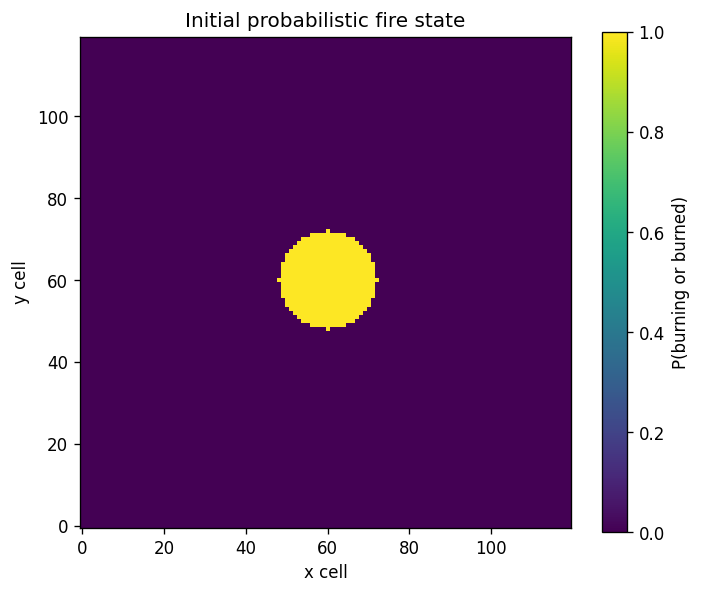

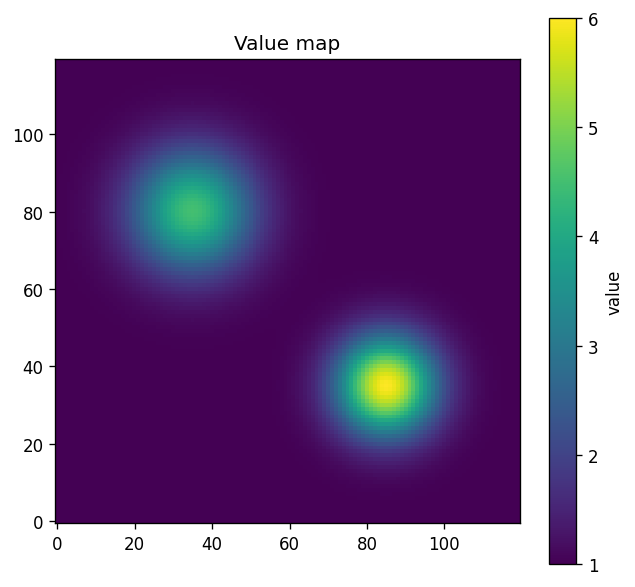

In [12]:
# Initial fire state (probabilistic via MC aggregation).

center = (nx // 2, ny // 2)
init_batch = model.init_state_batch(n_sims=60, center=center, radius_km=0.10)
init_state = model.aggregate_mc_to_state(init_batch)

model.plot_firestate(init_state, kind="p_affected", title="Initial probabilistic fire state")

plt.figure(figsize=(5.5, 5))
plt.imshow(value.T, origin="lower", aspect="equal", cmap="viridis")
plt.colorbar(label="value")
plt.title("Value map")
plt.tight_layout()
plt.show()

No drone_params


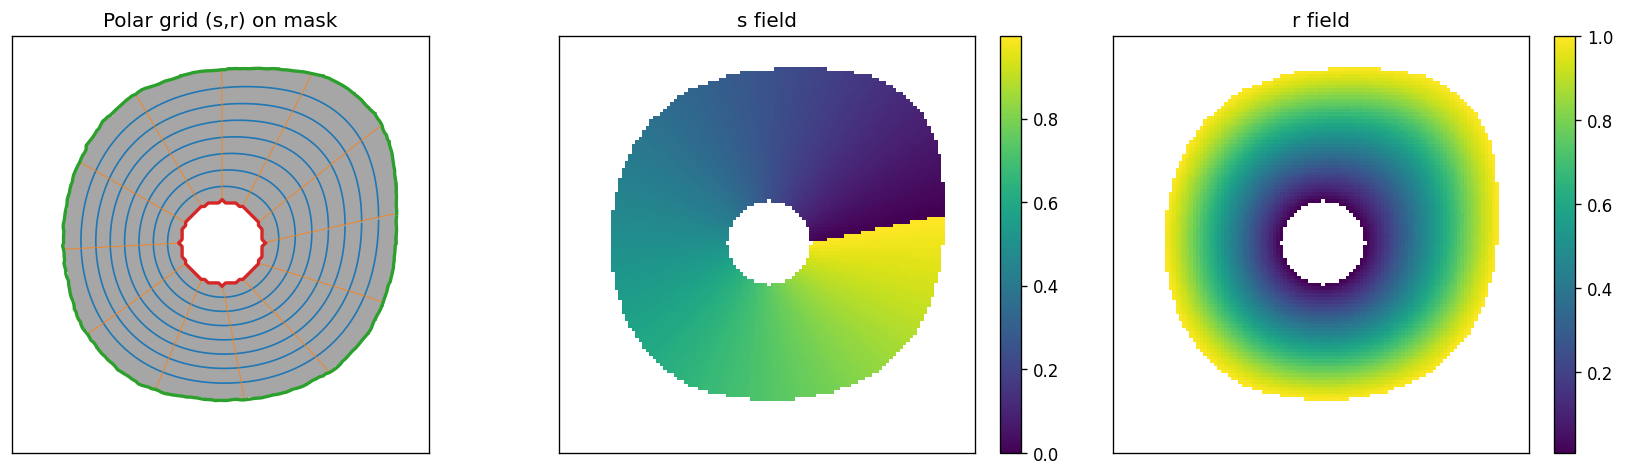

In [14]:
# Setup BO object and polar search grid.

bo = RetardantDropBayesOpt(
    fire_model=model,
    init_firestate=init_state,
    n_drones=6,
    evolution_time_s=150.0,
    n_sims=60,
    fire_boundary_probability=0.5,
    search_grid_evolution_time_s=150.0,
)

bo.setup_search_grid_polar(
    K=300,
    boundary_field="affected",
    n_r=120,
    smooth_iters=300,
    omega=1.0,
)

bo.plot_polar_domain()

Applying retardant drop: D=[[ 51.764  44.781   4.776]
 [ 68.399  69.527   4.502]
 [ 78.449  63.438   5.008]
 [ 84.227 105.492   0.986]
 [ 97.021  57.302   1.81 ]
 [102.216  81.487   5.288]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


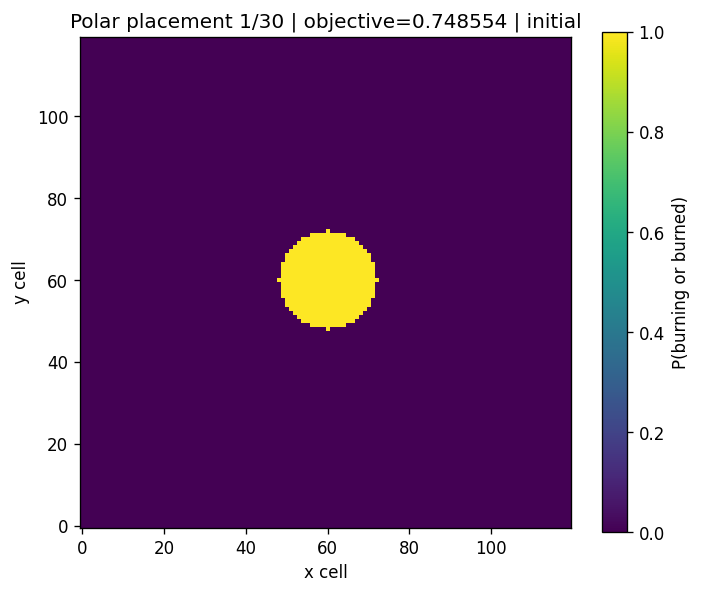

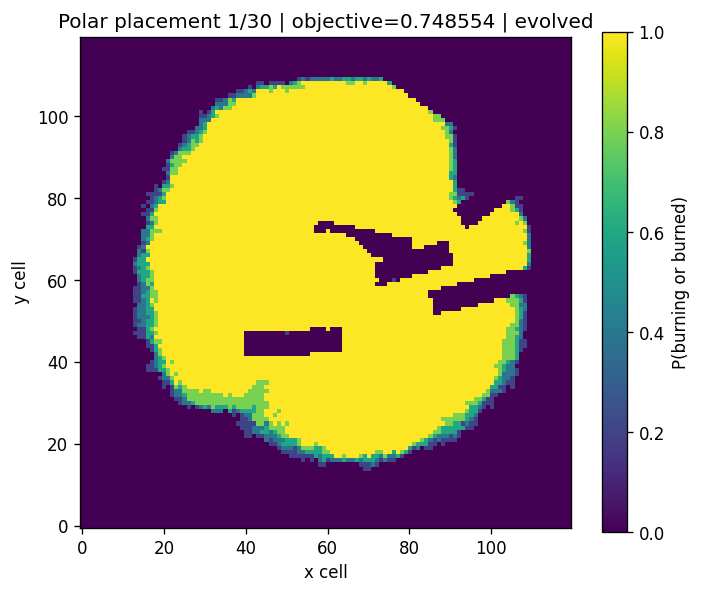

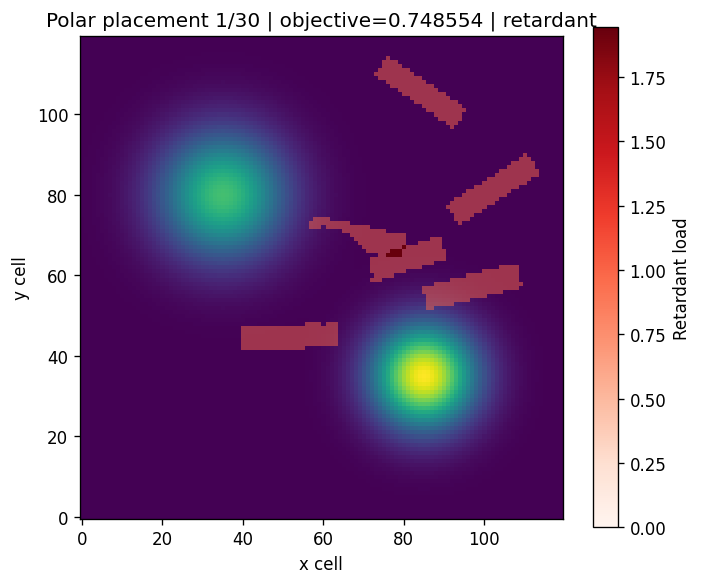

[Init polar] run 001/30 | objective=0.748554
Applying retardant drop: D=[[16.331 54.325  5.575]
 [26.478 58.074  3.903]
 [27.68  85.516  2.823]
 [56.354 84.875  1.537]
 [63.155 37.437  2.412]
 [76.082 82.078  2.081]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


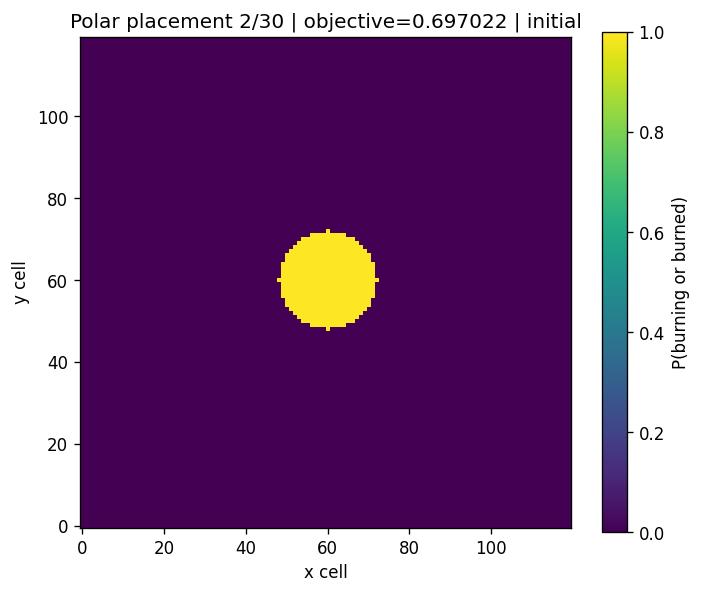

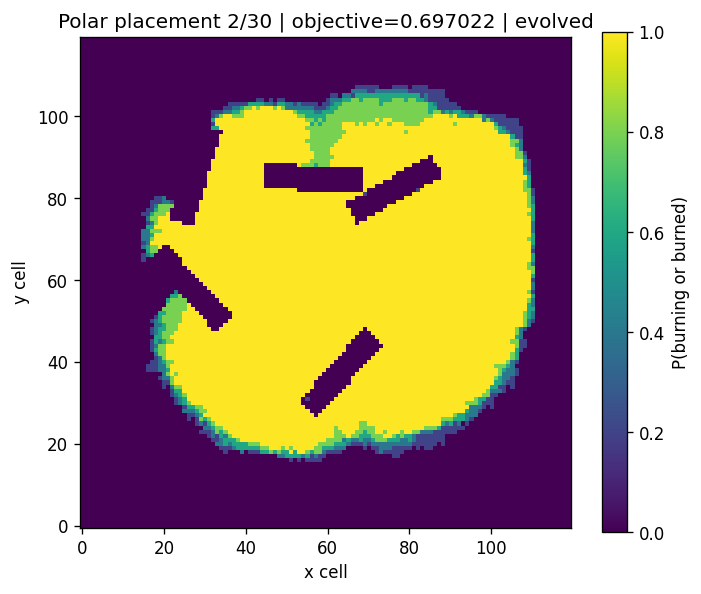

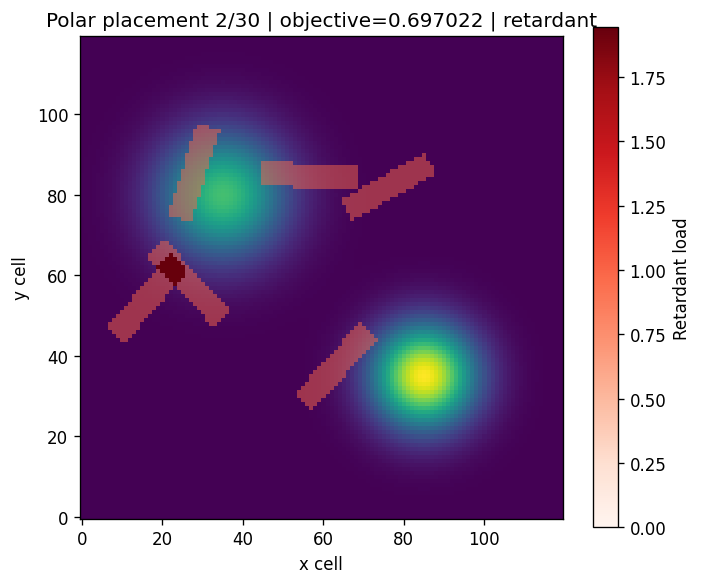

[Init polar] run 002/30 | objective=0.697022
Applying retardant drop: D=[[28.92  58.955  3.102]
 [65.127 29.349  1.453]
 [73.871 31.505  1.199]
 [82.199 36.351  0.883]
 [88.573 43.612  0.562]
 [92.503 52.529  0.278]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


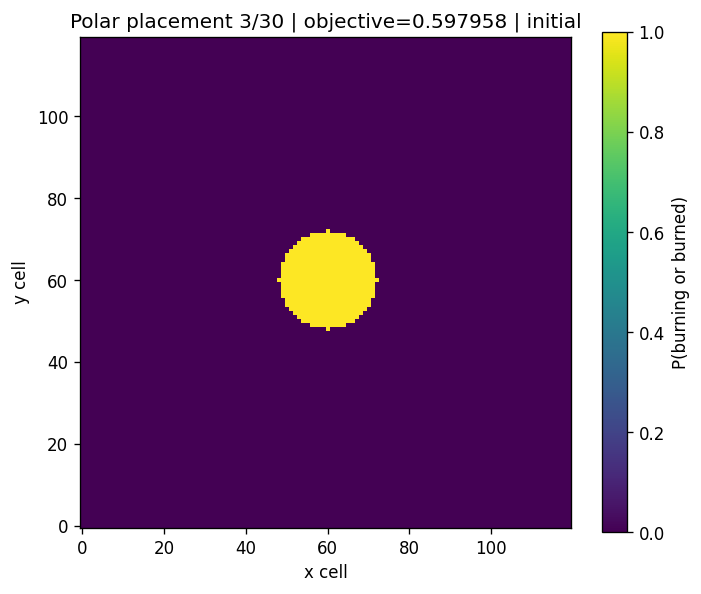

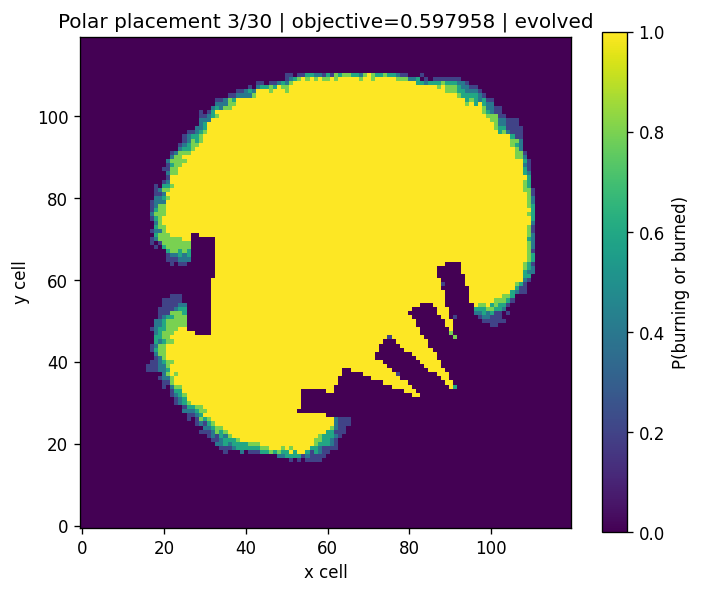

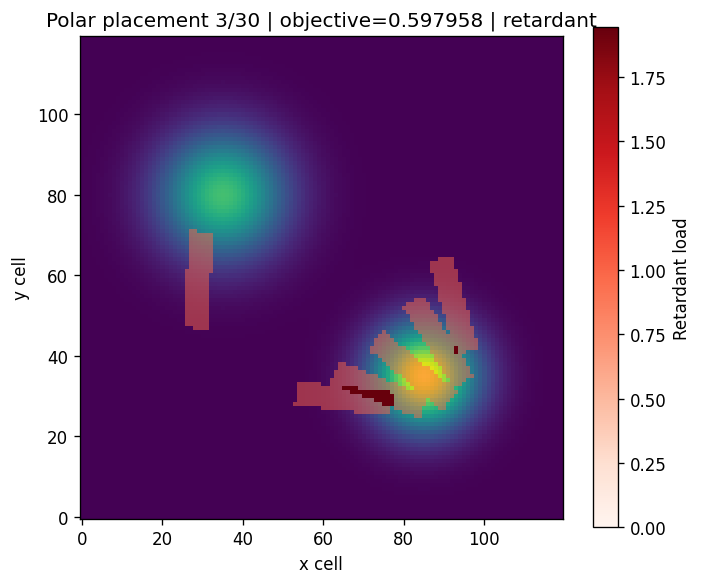

[Init polar] run 003/30 | objective=0.597958
Applying retardant drop: D=[[ 65.818  29.438   1.435]
 [ 70.314 101.598   4.782]
 [ 82.199  36.351   0.883]
 [ 90.694  94.545   5.389]
 [ 92.094  51.188   0.315]
 [100.971  76.123   6.101]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


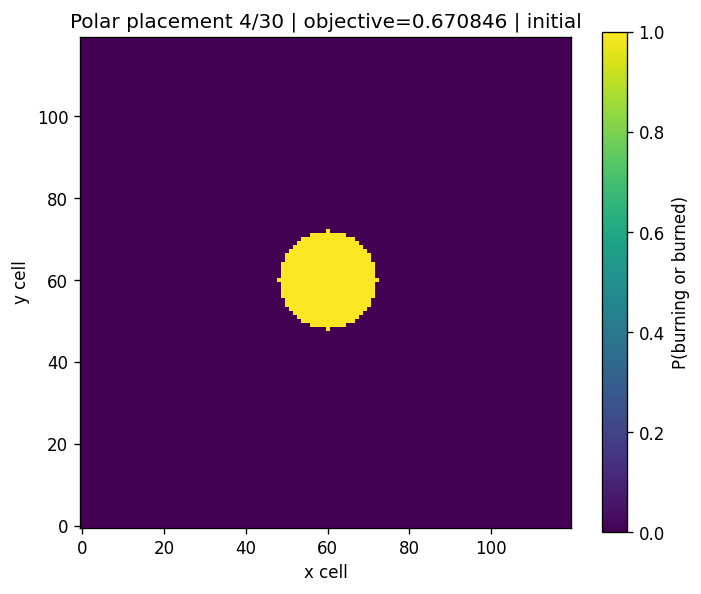

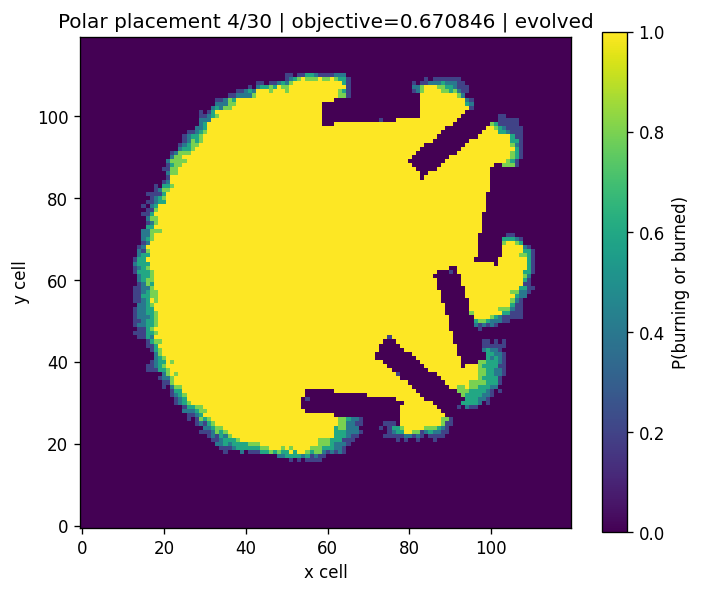

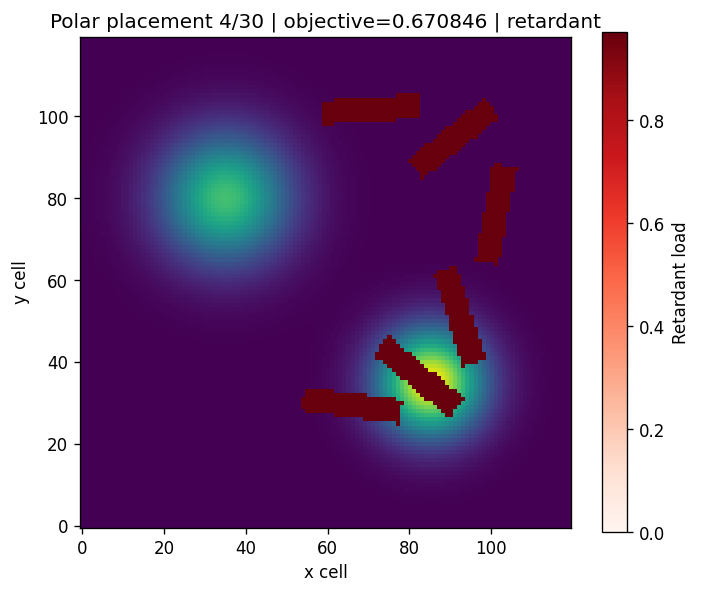

[Init polar] run 004/30 | objective=0.670846
Applying retardant drop: D=[[37.316 64.9    3.321]
 [37.348 55.388  2.953]
 [41.055 74.283  3.729]
 [80.849 47.86   0.563]
 [84.435 57.387  0.173]
 [84.46  68.036  6.106]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


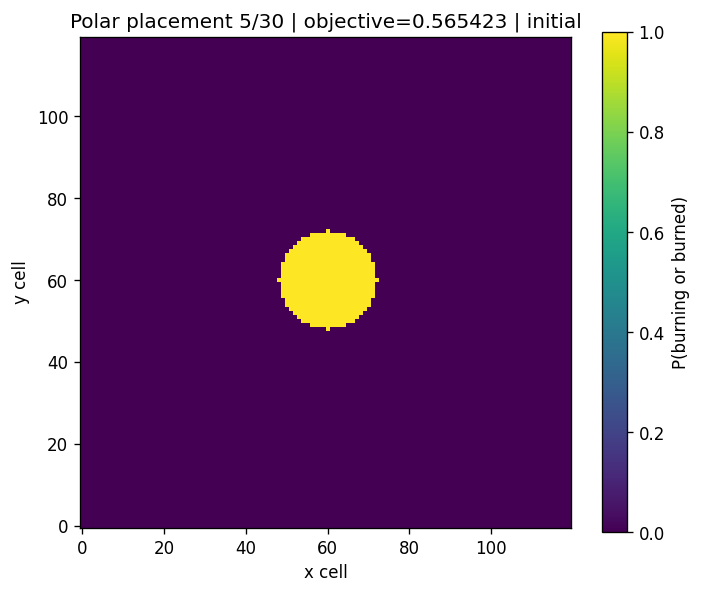

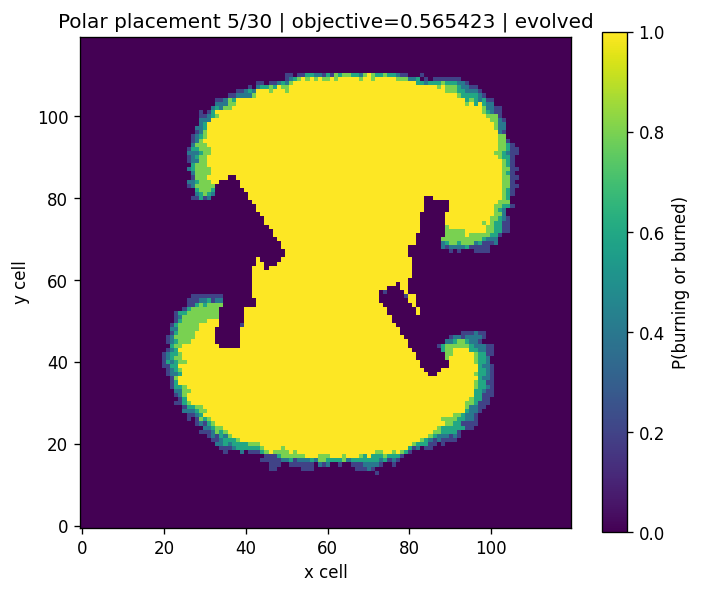

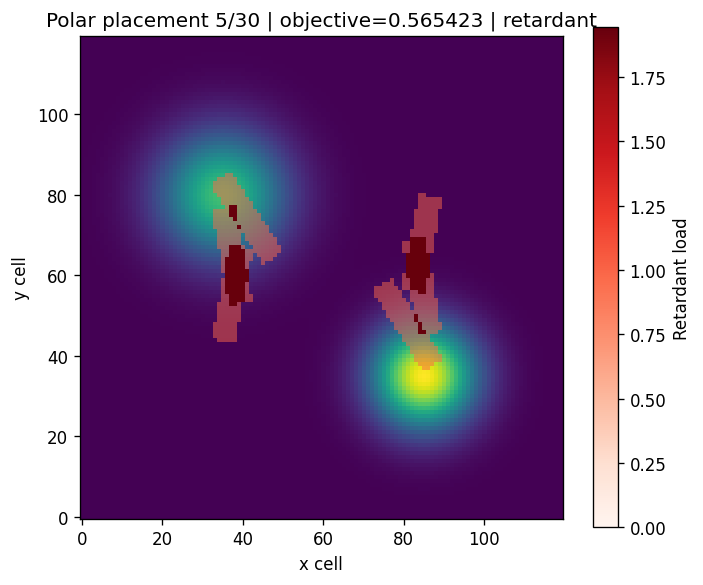

[Init polar] run 005/30 | objective=0.565423
Applying retardant drop: D=[[47.599 59.782  1.346]
 [50.682 30.646  0.991]
 [59.385 41.139  0.842]
 [64.667 31.237  2.578]
 [70.361 85.883  1.493]
 [97.311 49.329  0.651]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


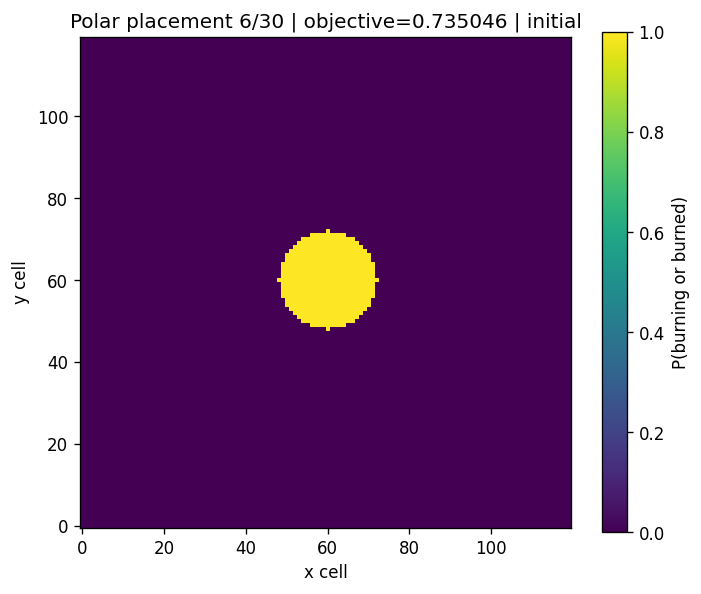

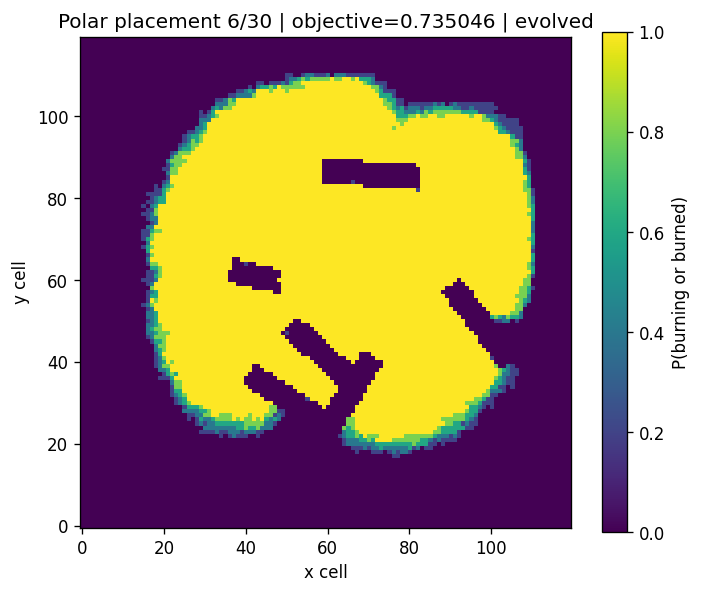

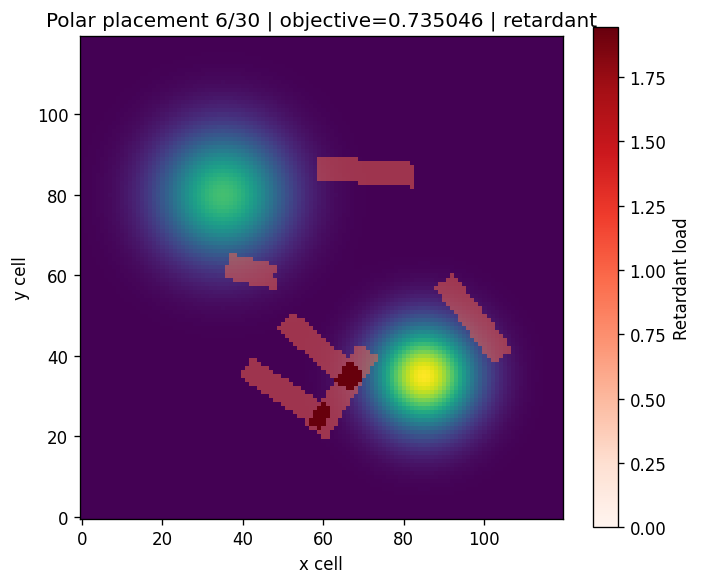

[Init polar] run 006/30 | objective=0.735046
Applying retardant drop: D=[[ 28.92   58.955   3.102]
 [ 70.314 101.598   4.782]
 [ 80.849  47.86    0.563]
 [ 82.199  36.351   0.883]
 [ 90.694  94.545   5.389]
 [100.971  76.123   6.101]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


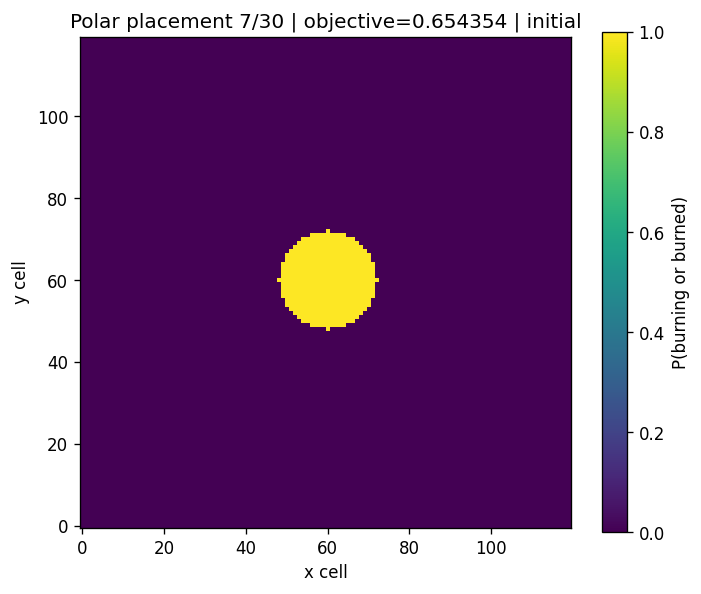

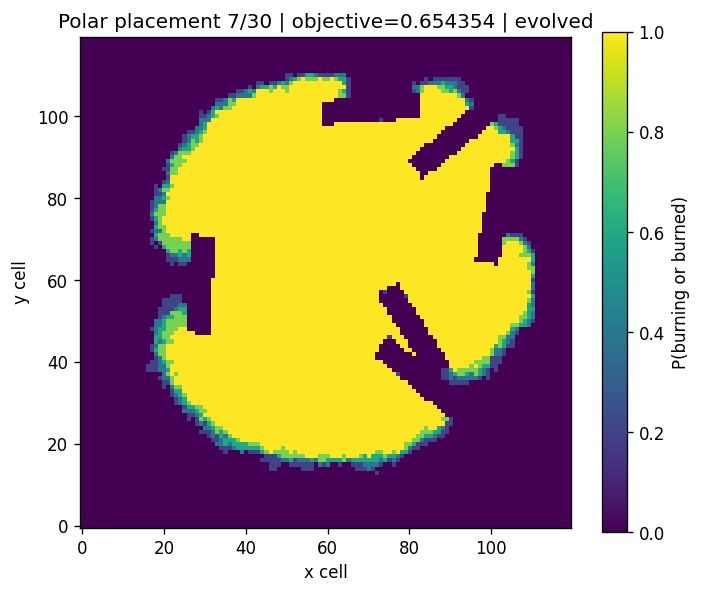

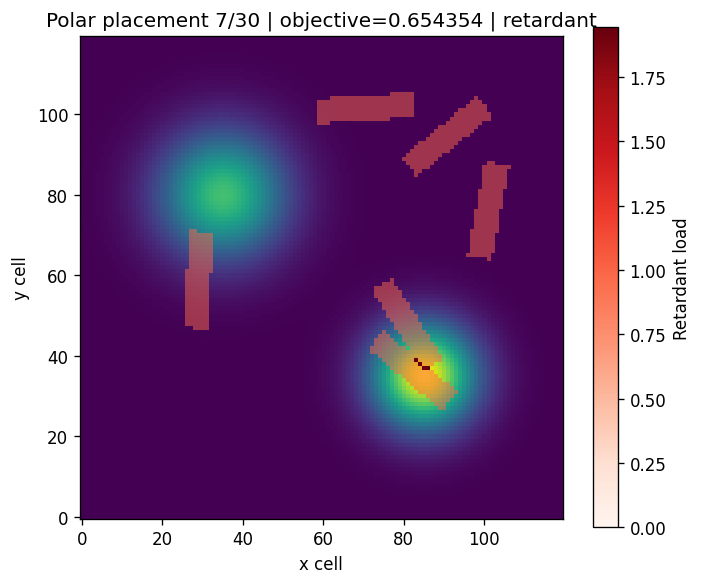

[Init polar] run 007/30 | objective=0.654354
Applying retardant drop: D=[[ 59.092 101.334   4.597]
 [ 70.314 101.598   4.782]
 [ 81.204  99.584   5.029]
 [ 90.694  94.545   5.389]
 [ 97.475  86.389   5.786]
 [100.971  76.123   6.101]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


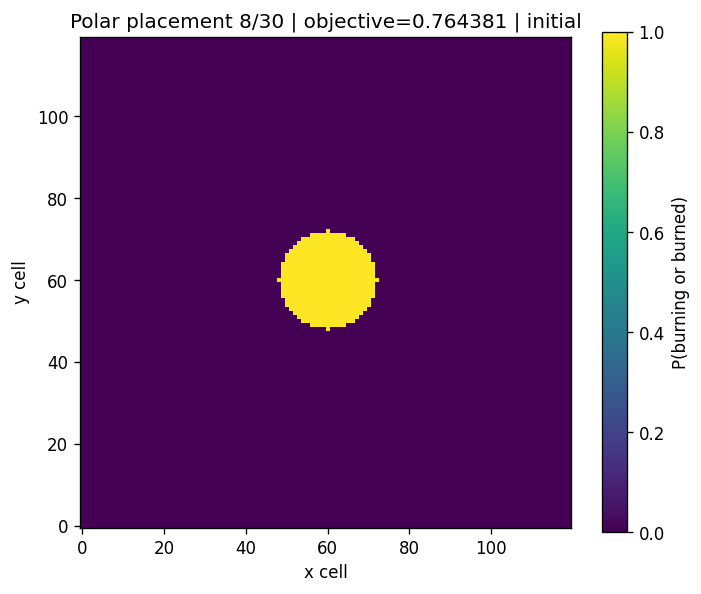

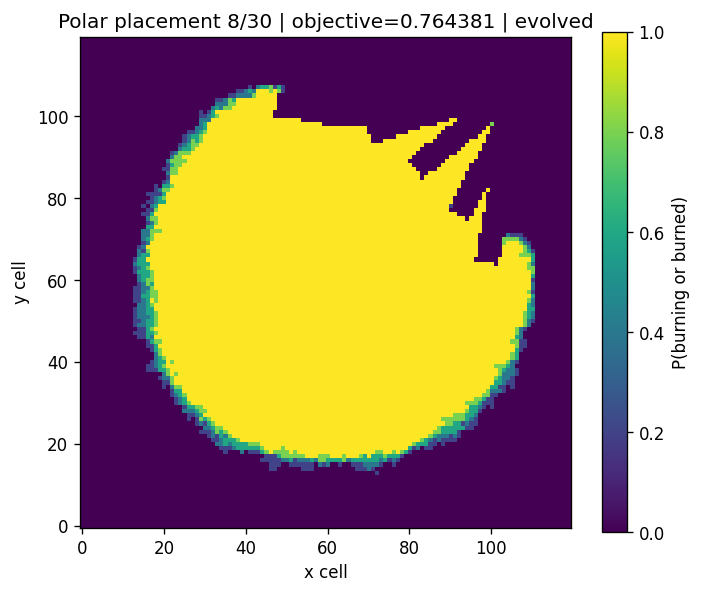

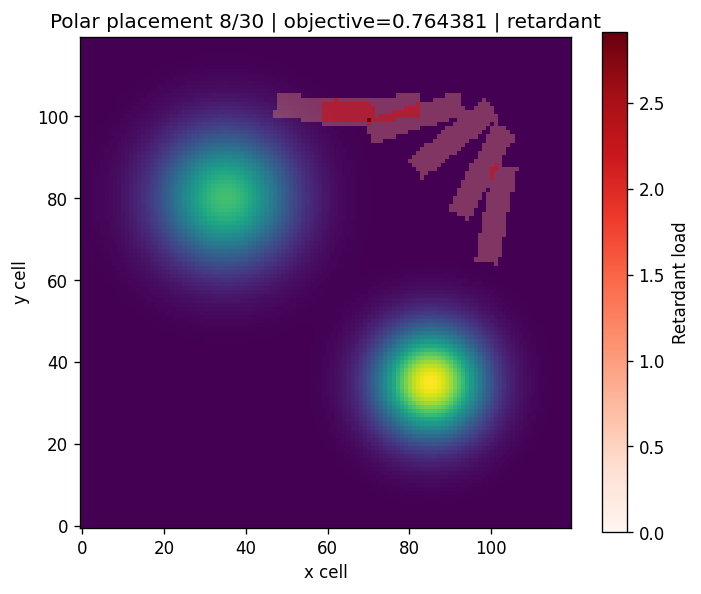

[Init polar] run 008/30 | objective=0.764381
Applying retardant drop: D=[[37.316 64.9    3.321]
 [37.348 55.388  2.953]
 [41.055 74.283  3.729]
 [80.849 47.86   0.563]
 [84.435 57.387  0.173]
 [84.46  68.036  6.106]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


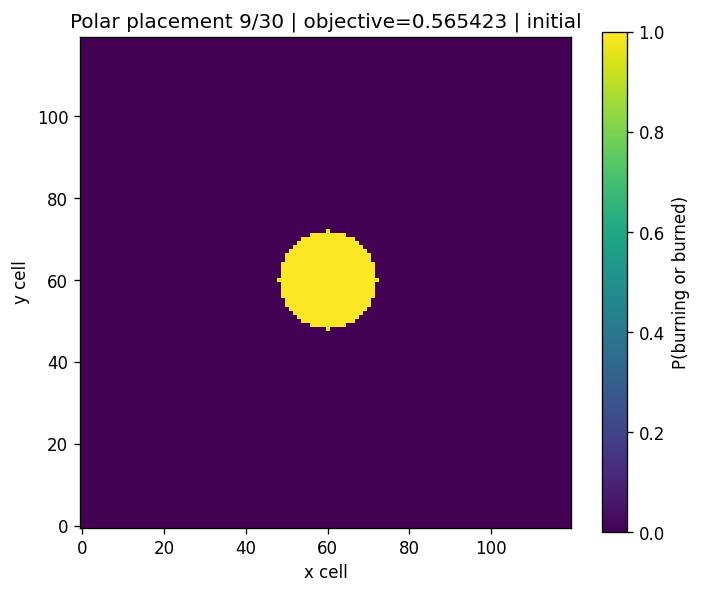

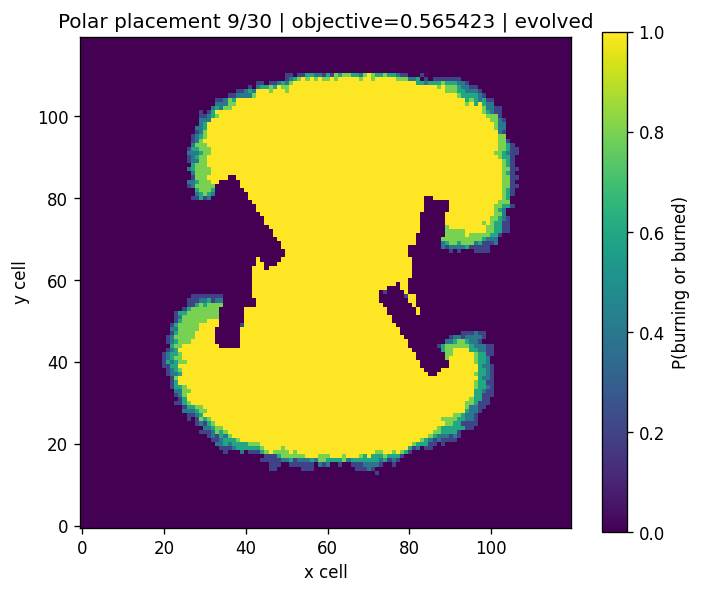

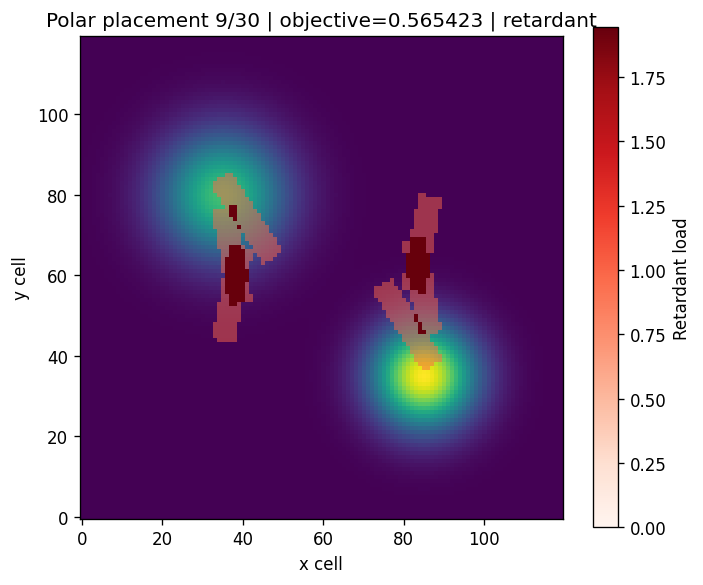

[Init polar] run 009/30 | objective=0.565423
Applying retardant drop: D=[[ 59.092 101.334   4.597]
 [ 70.314 101.598   4.782]
 [ 81.204  99.584   5.029]
 [ 90.694  94.545   5.389]
 [ 97.475  86.389   5.786]
 [100.971  76.123   6.101]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


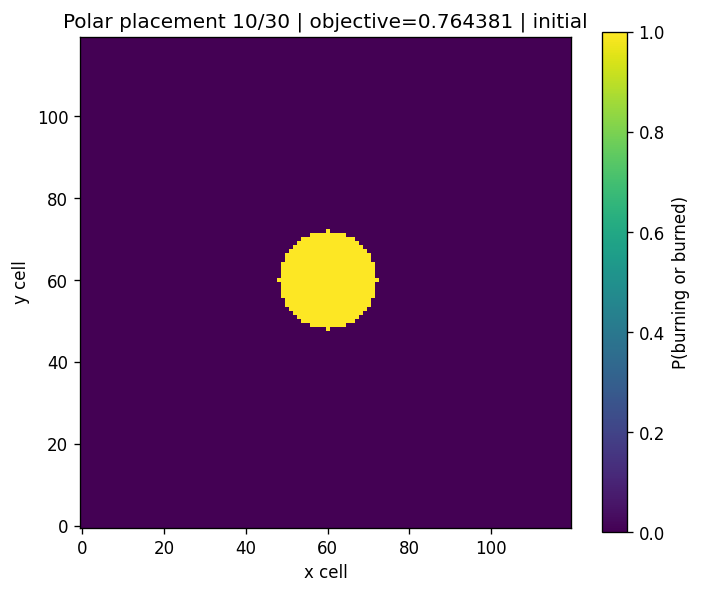

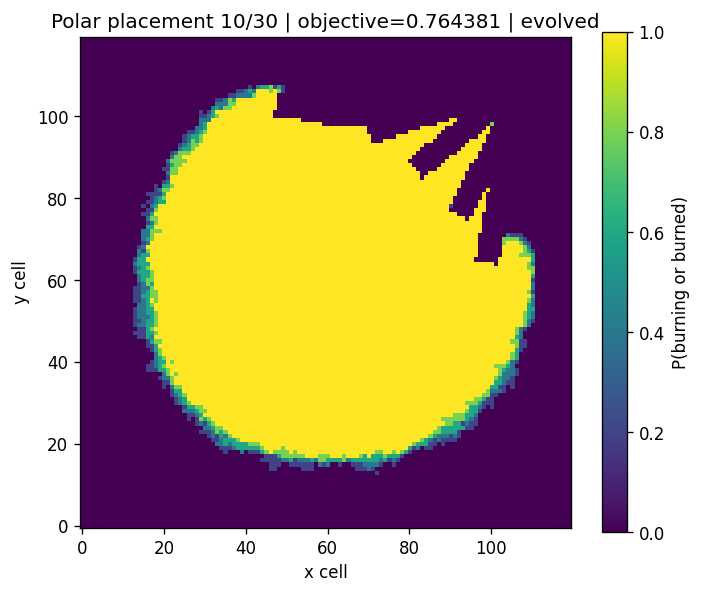

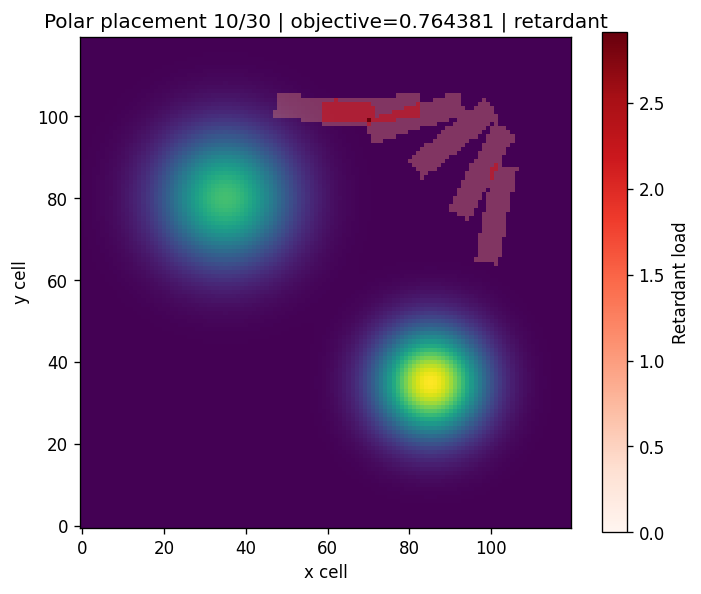

[Init polar] run 010/30 | objective=0.764381
Applying retardant drop: D=[[37.316 64.9    3.321]
 [37.348 55.388  2.953]
 [41.055 74.283  3.729]
 [80.849 47.86   0.563]
 [84.435 57.387  0.173]
 [84.46  68.036  6.106]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


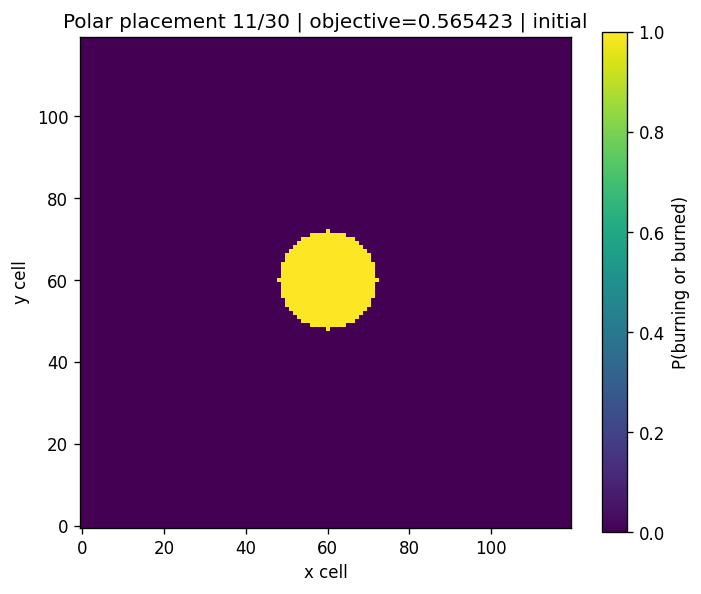

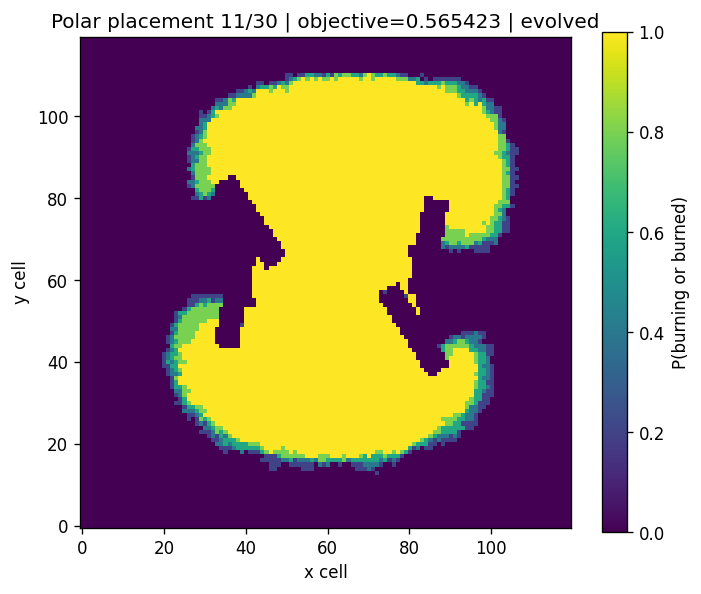

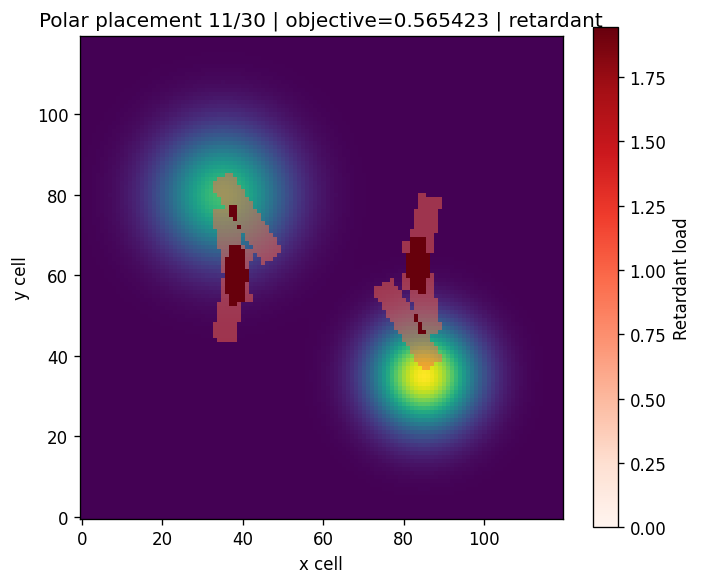

[Init polar] run 011/30 | objective=0.565423
Applying retardant drop: D=[[ 26.959  60.325   1.238]
 [ 35.04   54.244   5.465]
 [ 61.201  15.098   5.678]
 [ 73.253  93.195   5.674]
 [ 82.684  54.046   6.015]
 [102.643  59.022   2.538]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


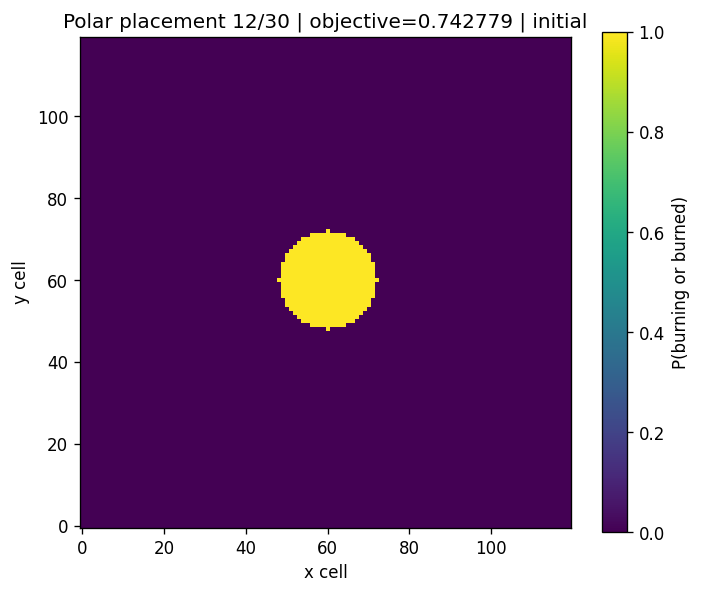

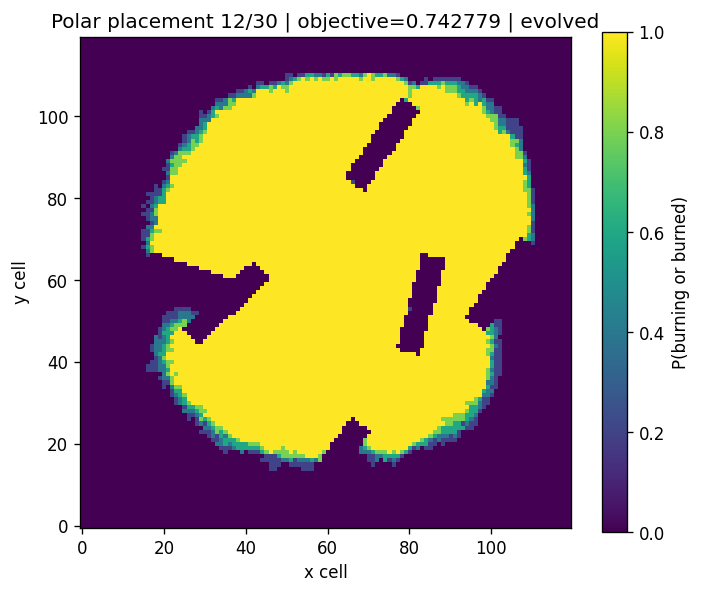

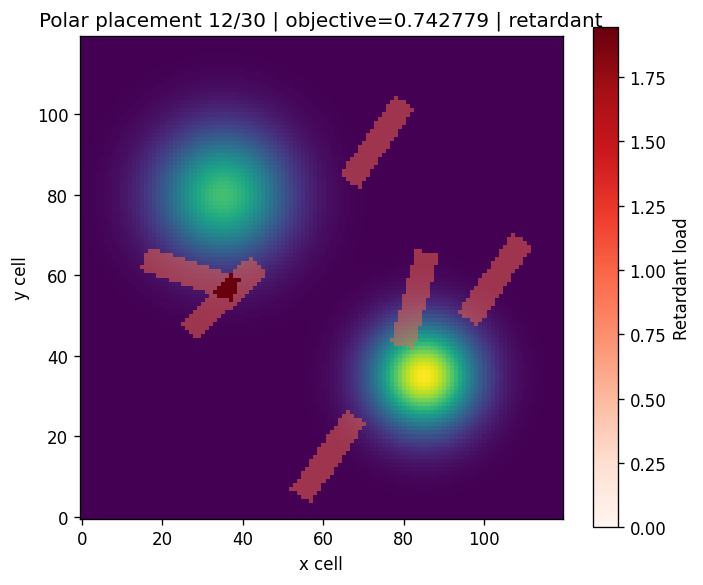

[Init polar] run 012/30 | objective=0.742779
Applying retardant drop: D=[[28.92  58.955  3.102]
 [65.127 29.349  1.453]
 [73.871 31.505  1.199]
 [82.199 36.351  0.883]
 [88.573 43.612  0.562]
 [92.503 52.529  0.278]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


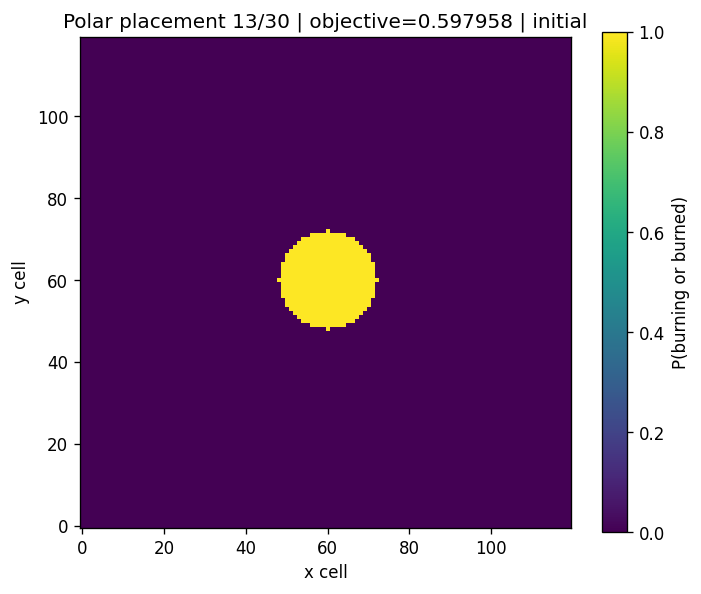

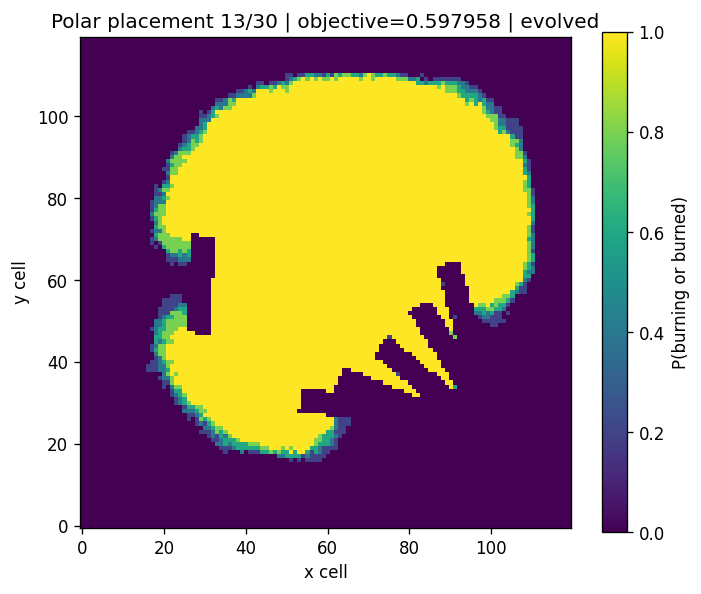

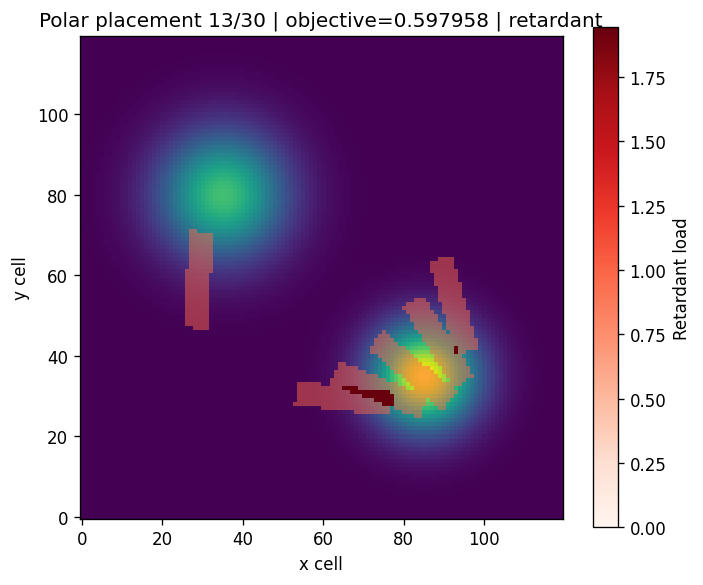

[Init polar] run 013/30 | objective=0.597958
Applying retardant drop: D=[[ 59.092 101.334   4.597]
 [ 70.314 101.598   4.782]
 [ 81.204  99.584   5.029]
 [ 90.694  94.545   5.389]
 [ 97.475  86.389   5.786]
 [100.971  76.123   6.101]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


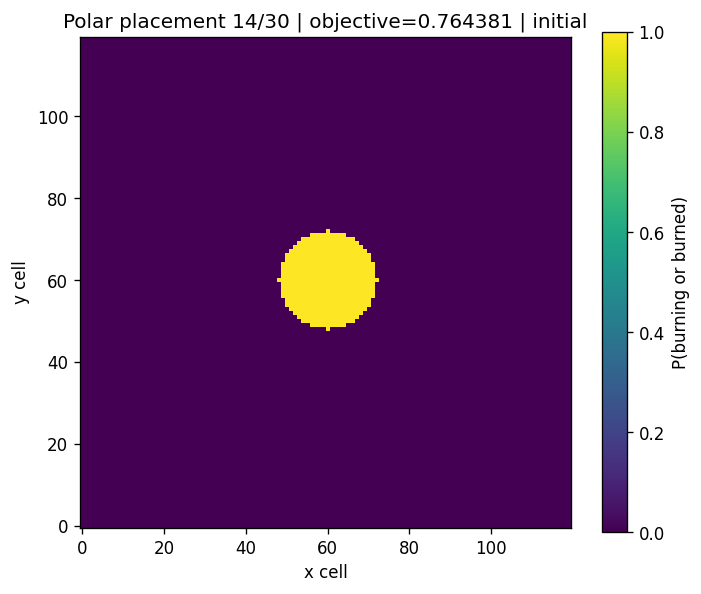

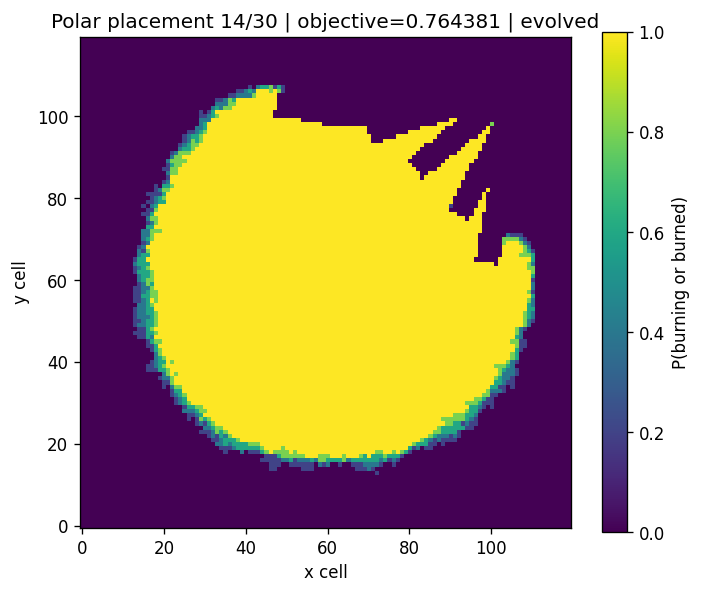

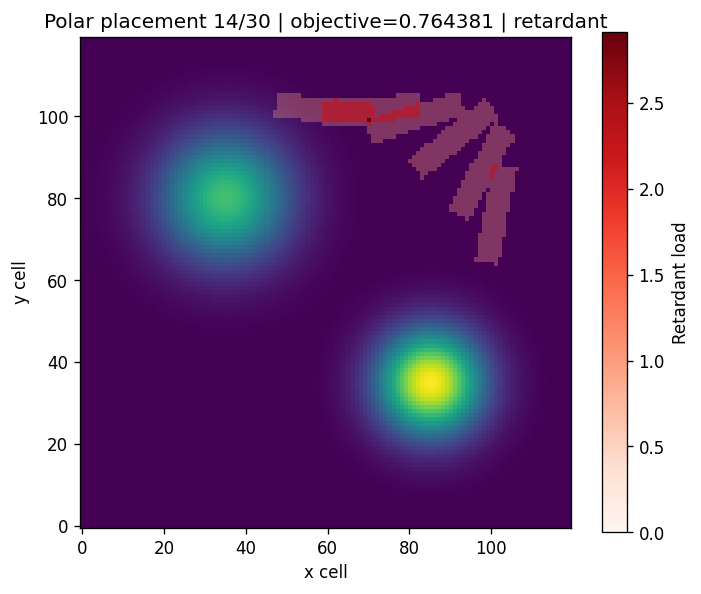

[Init polar] run 014/30 | objective=0.764381
Applying retardant drop: D=[[ 41.055  74.283   3.729]
 [ 70.314 101.598   4.782]
 [ 80.849  47.86    0.563]
 [ 82.199  36.351   0.883]
 [ 90.694  94.545   5.389]
 [100.971  76.123   6.101]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


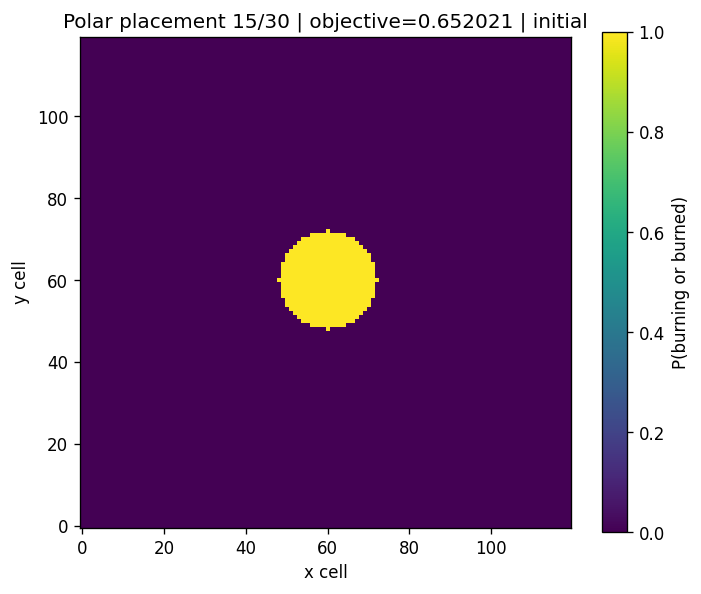

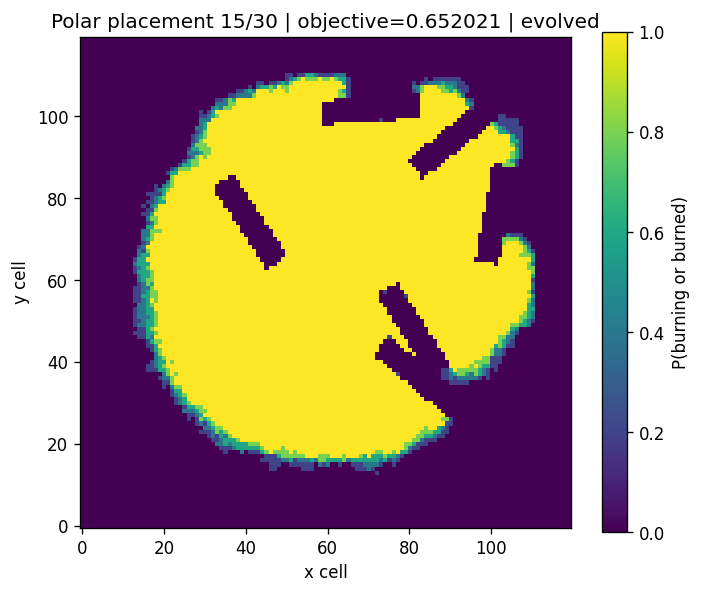

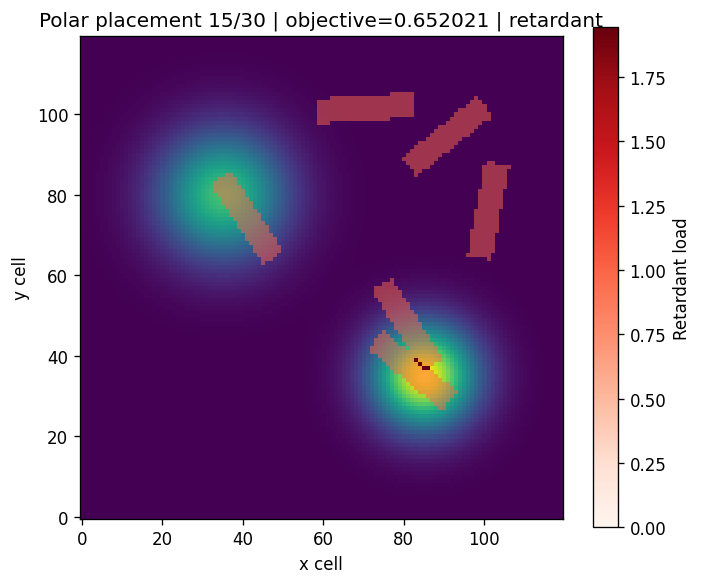

[Init polar] run 015/30 | objective=0.652021
Applying retardant drop: D=[[ 59.092 101.334   4.597]
 [ 70.314 101.598   4.782]
 [ 81.204  99.584   5.029]
 [ 90.694  94.545   5.389]
 [ 97.475  86.389   5.786]
 [100.971  76.123   6.101]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


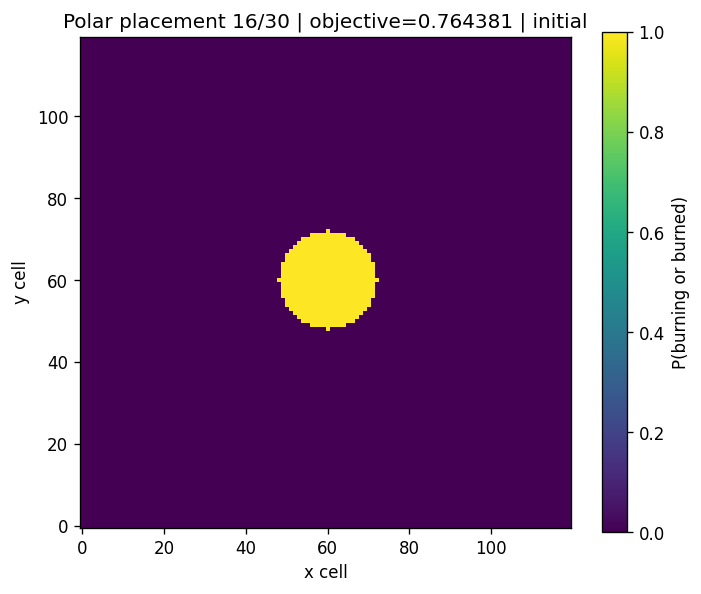

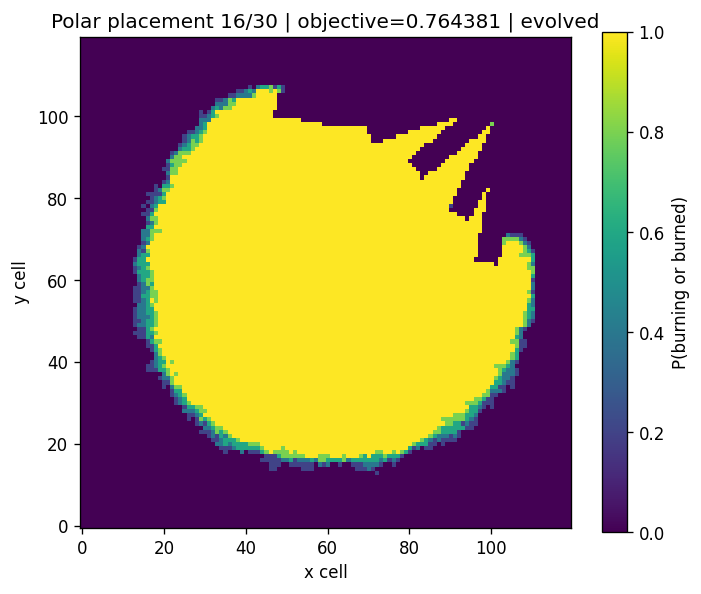

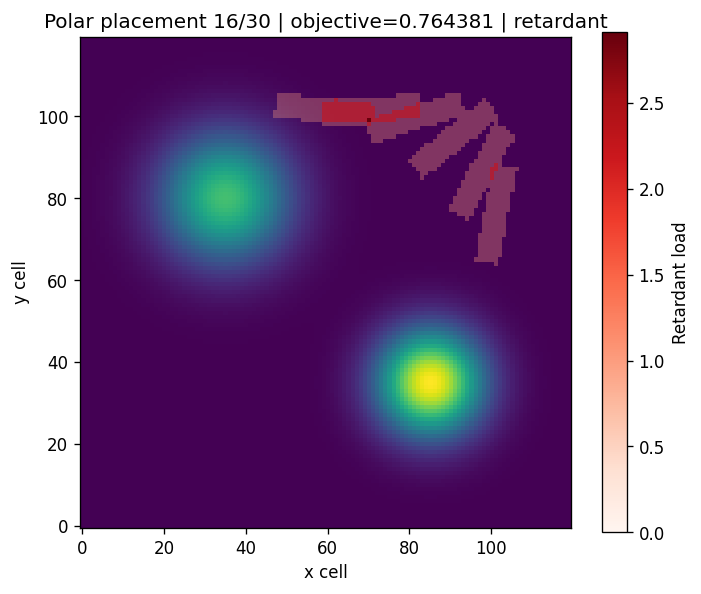

[Init polar] run 016/30 | objective=0.764381
Applying retardant drop: D=[[38.993 50.108  0.81 ]
 [42.135 60.42   3.745]
 [48.72  19.673  1.247]
 [67.495 46.092  4.986]
 [72.11  67.267  2.327]
 [98.168 62.007  5.993]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


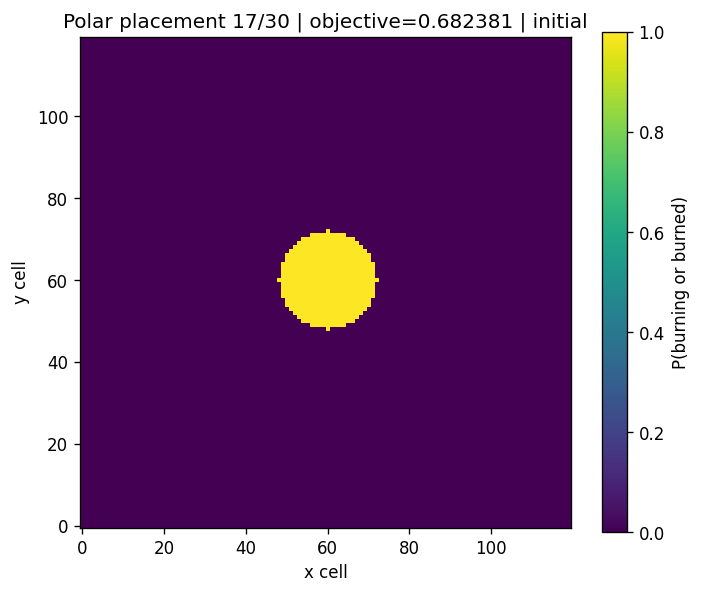

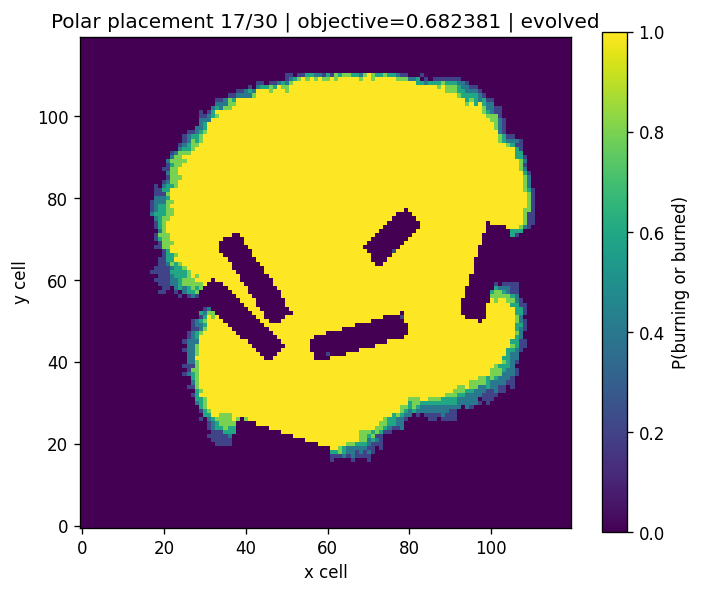

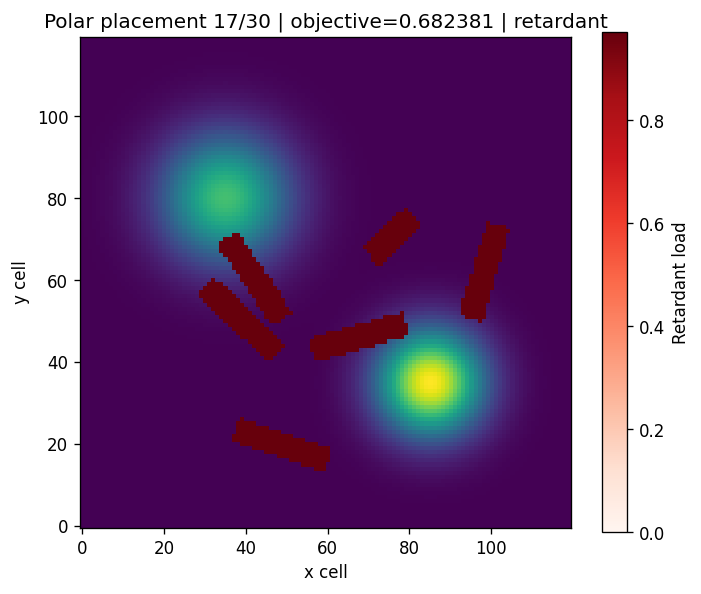

[Init polar] run 017/30 | objective=0.682381
Applying retardant drop: D=[[28.92  58.955  3.102]
 [65.127 29.349  1.453]
 [73.871 31.505  1.199]
 [82.199 36.351  0.883]
 [88.573 43.612  0.562]
 [92.503 52.529  0.278]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


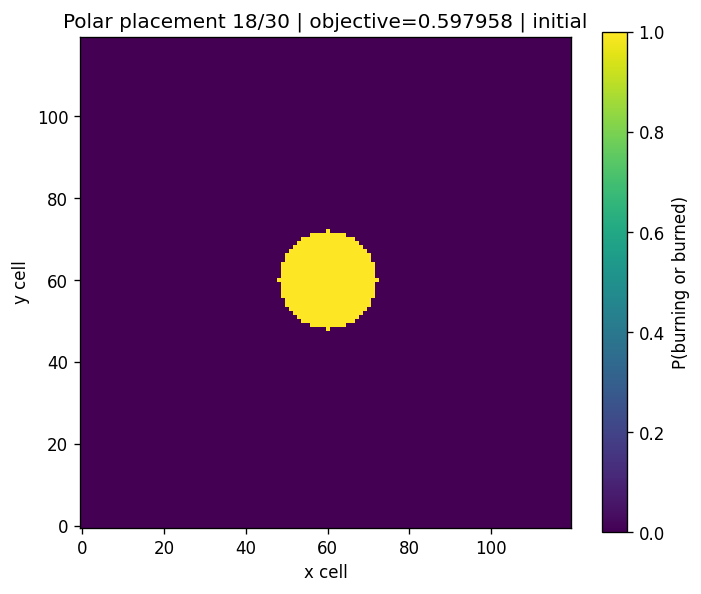

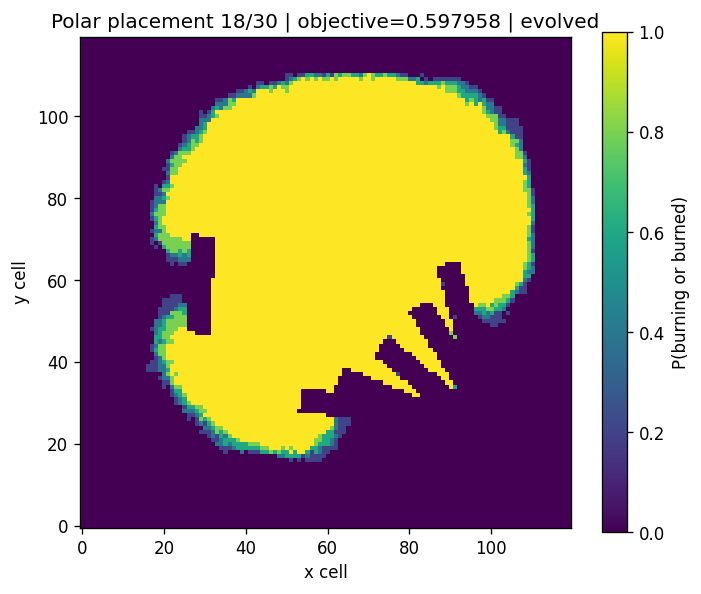

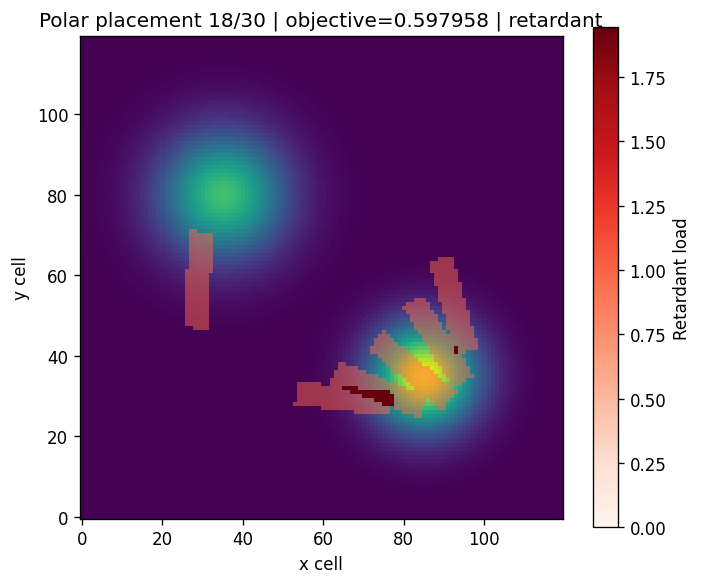

[Init polar] run 018/30 | objective=0.597958
Applying retardant drop: D=[[28.92  58.955  3.102]
 [65.127 29.349  1.453]
 [73.871 31.505  1.199]
 [82.199 36.351  0.883]
 [88.573 43.612  0.562]
 [92.503 52.529  0.278]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


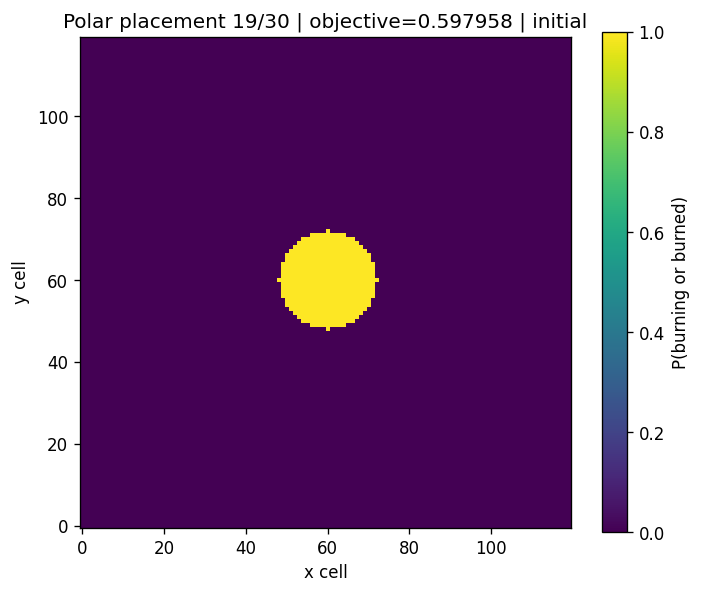

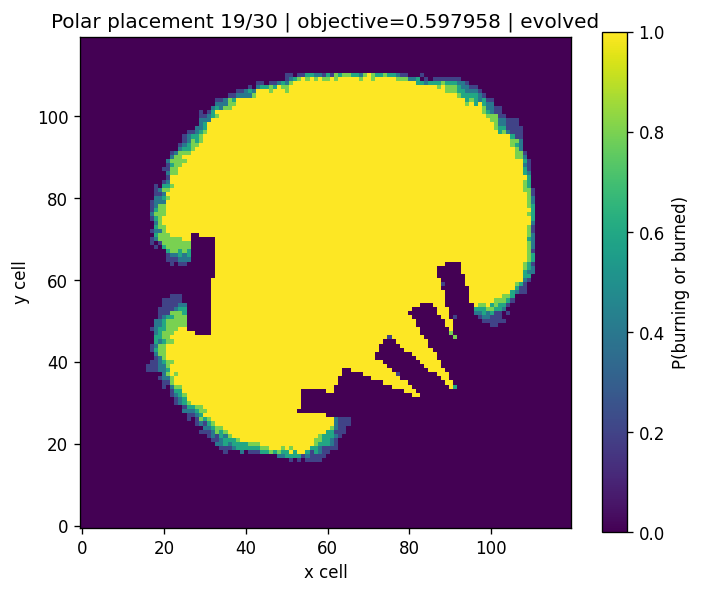

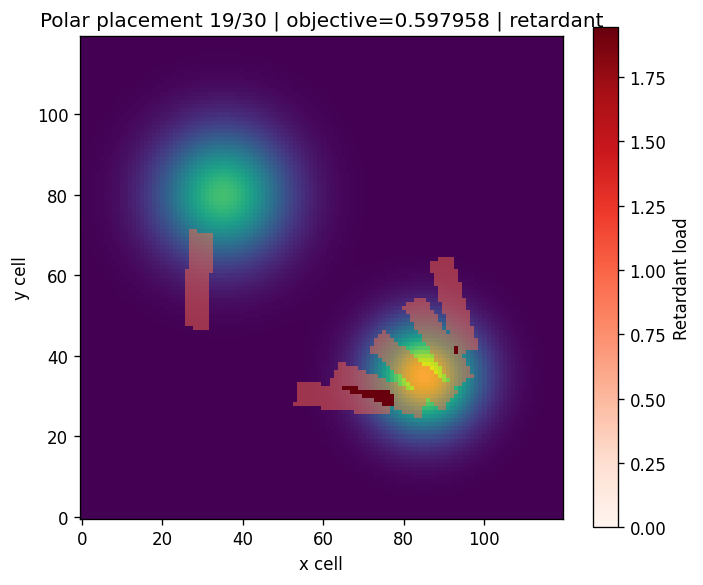

[Init polar] run 019/30 | objective=0.597958
Applying retardant drop: D=[[ 59.092 101.334   4.597]
 [ 70.314 101.598   4.782]
 [ 81.204  99.584   5.029]
 [ 90.694  94.545   5.389]
 [ 97.475  86.389   5.786]
 [100.971  76.123   6.101]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


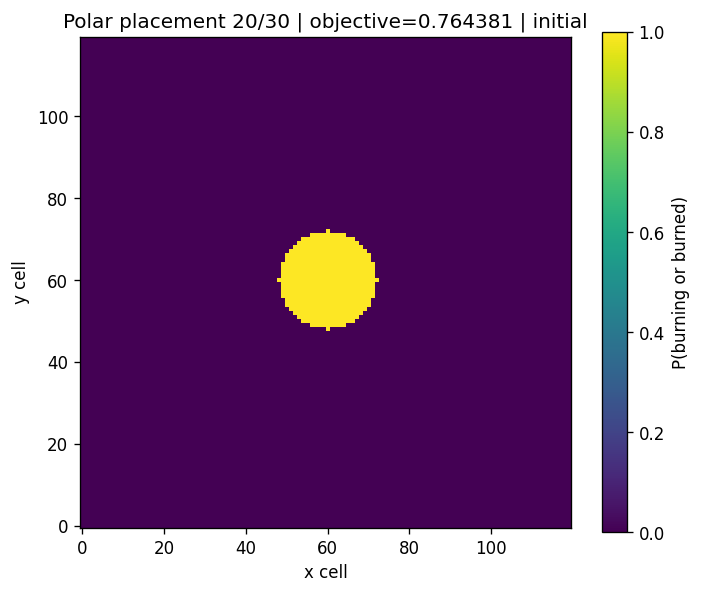

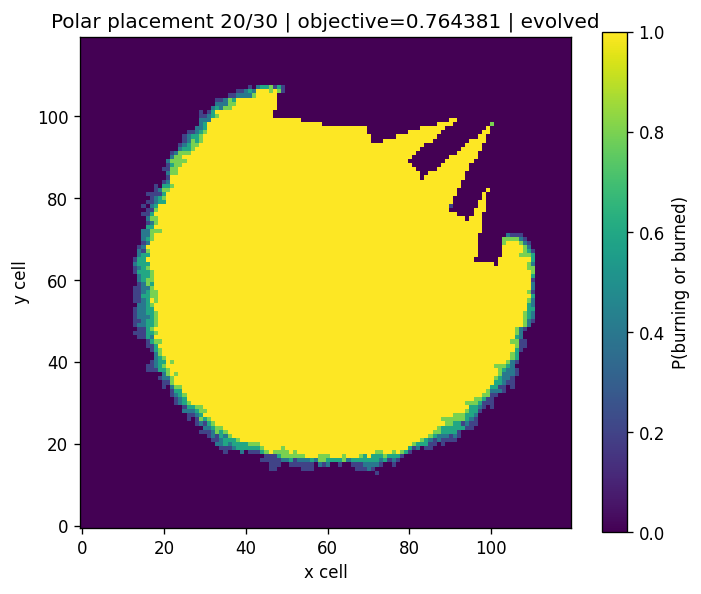

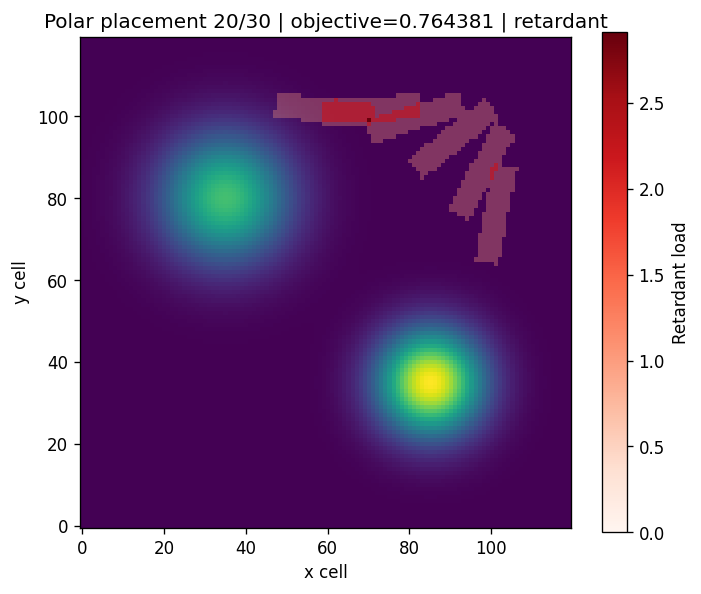

[Init polar] run 020/30 | objective=0.764381
Applying retardant drop: D=[[28.92  58.955  3.102]
 [65.127 29.349  1.453]
 [73.871 31.505  1.199]
 [82.199 36.351  0.883]
 [88.573 43.612  0.562]
 [92.503 52.529  0.278]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


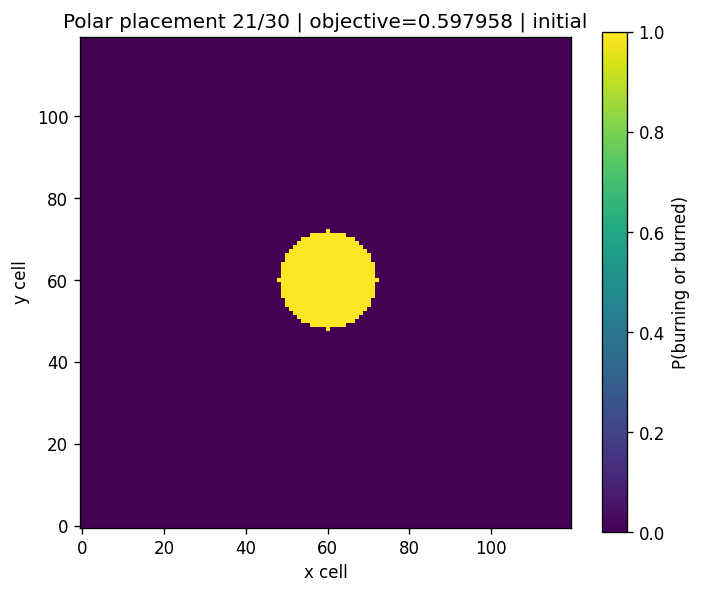

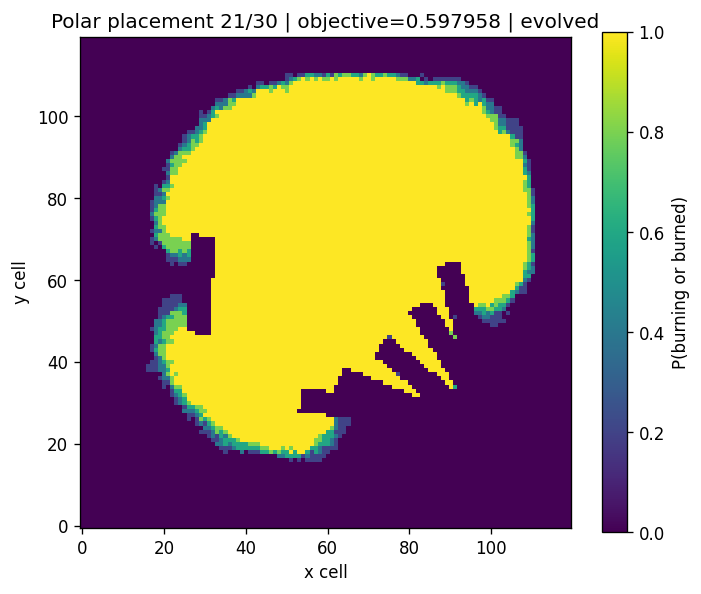

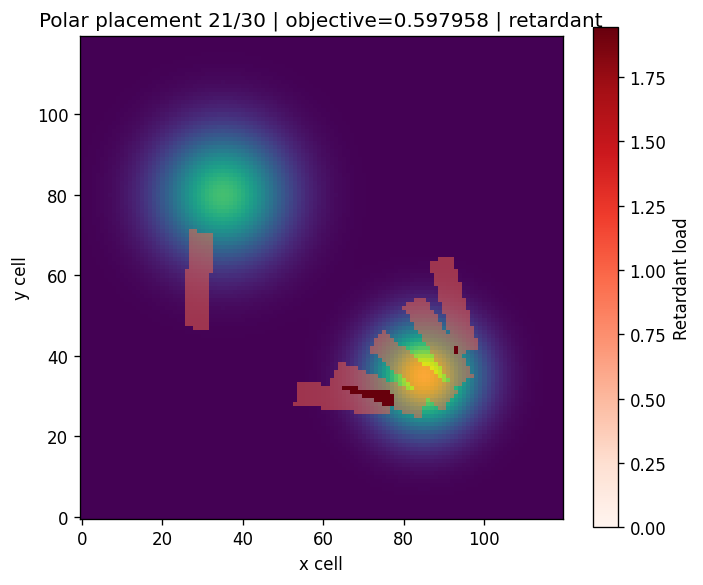

[Init polar] run 021/30 | objective=0.597958
Applying retardant drop: D=[[41.055 74.283  3.729]
 [65.818 29.438  1.435]
 [80.849 47.86   0.563]
 [82.199 36.351  0.883]
 [84.904 62.977  6.279]
 [92.094 51.188  0.315]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


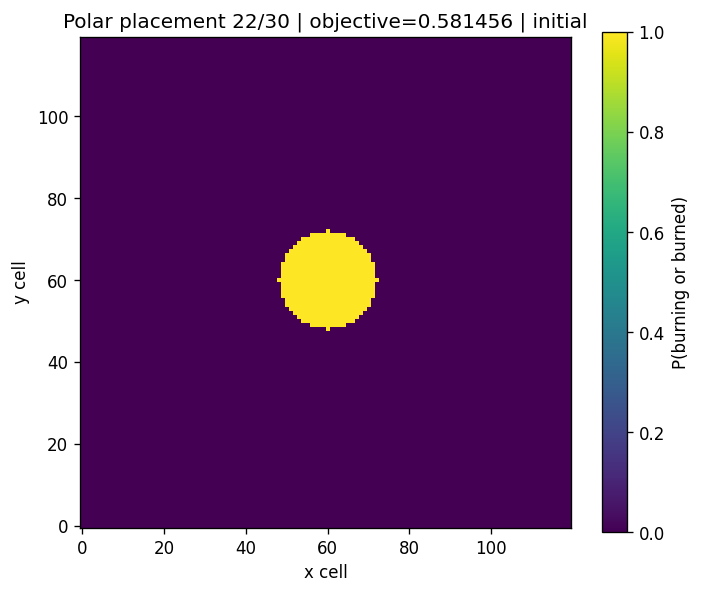

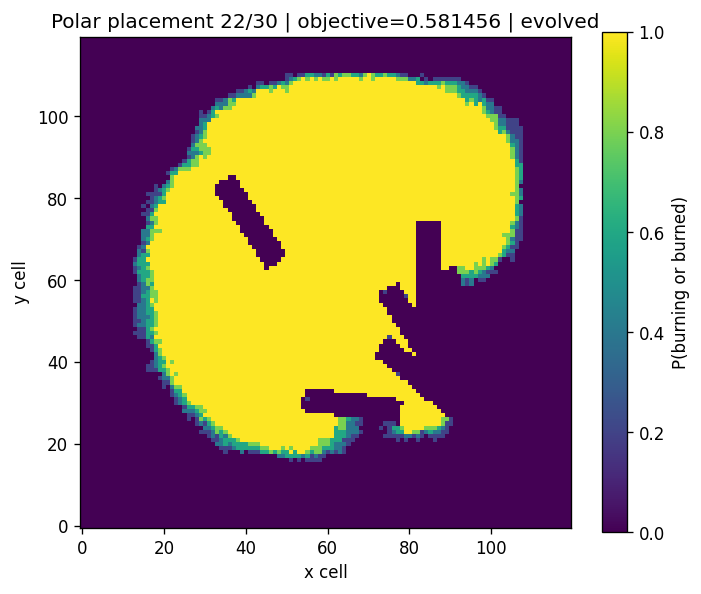

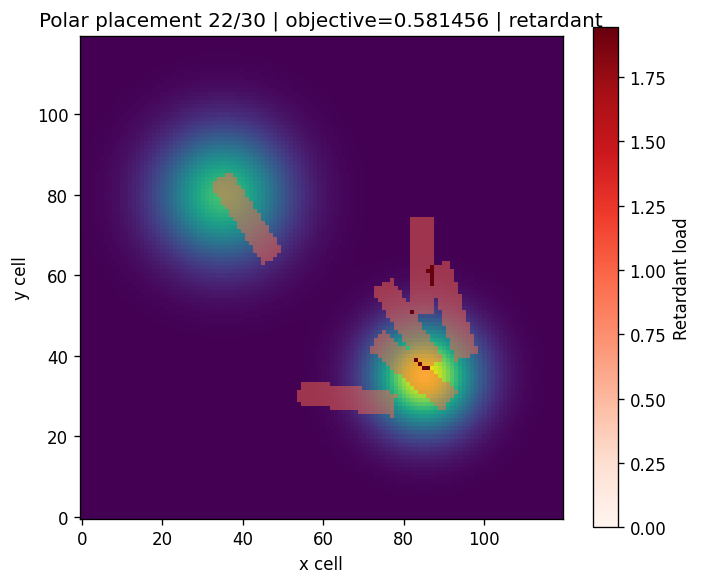

[Init polar] run 022/30 | objective=0.581456
Applying retardant drop: D=[[37.316 64.9    3.321]
 [37.348 55.388  2.953]
 [41.055 74.283  3.729]
 [80.849 47.86   0.563]
 [84.435 57.387  0.173]
 [84.46  68.036  6.106]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


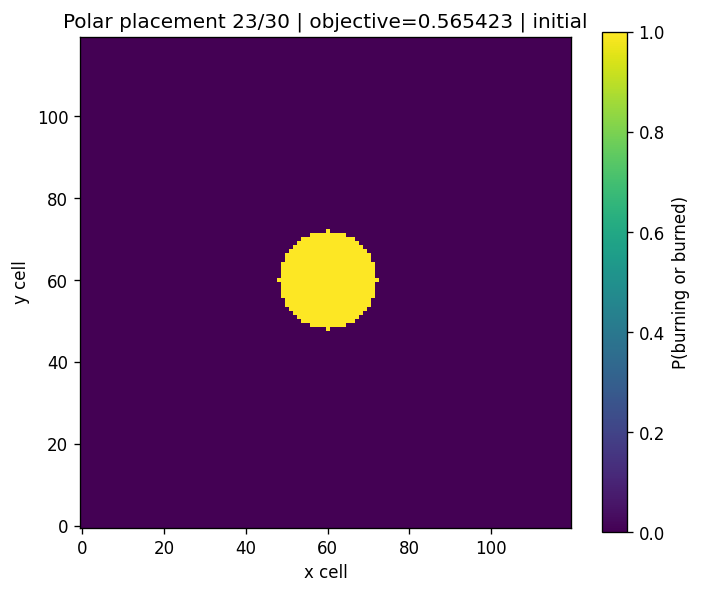

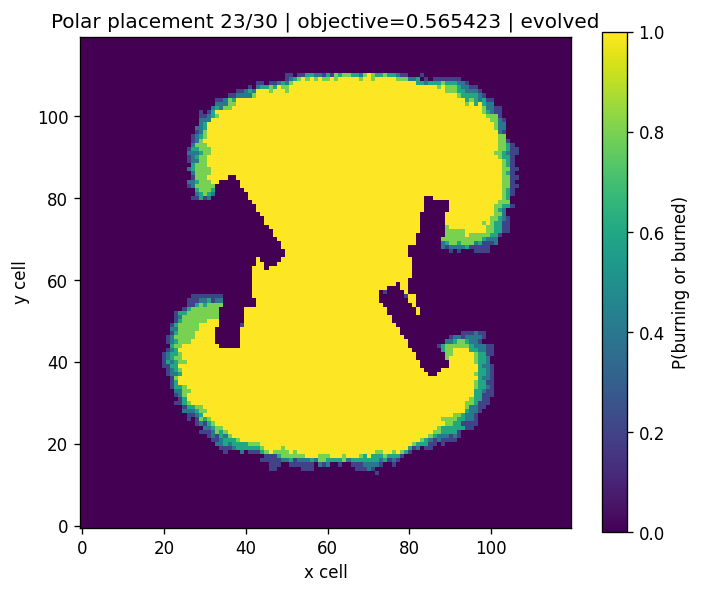

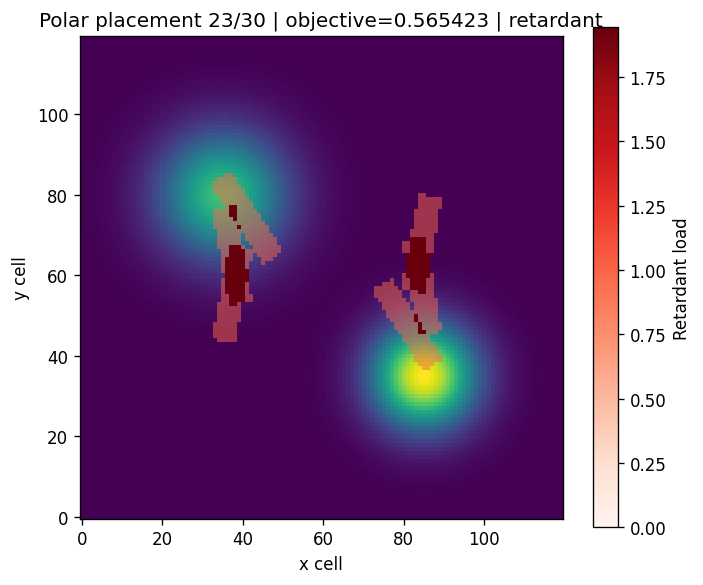

[Init polar] run 023/30 | objective=0.565423
Applying retardant drop: D=[[ 59.092 101.334   4.597]
 [ 70.314 101.598   4.782]
 [ 81.204  99.584   5.029]
 [ 90.694  94.545   5.389]
 [ 97.475  86.389   5.786]
 [100.971  76.123   6.101]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


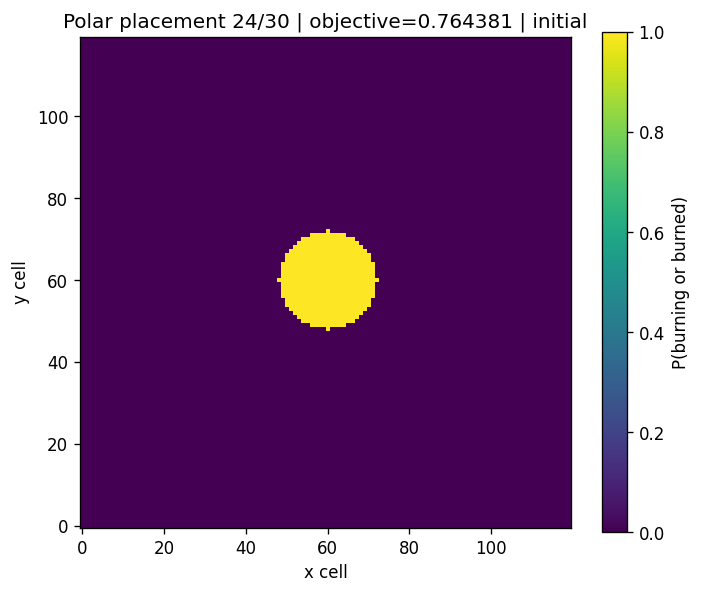

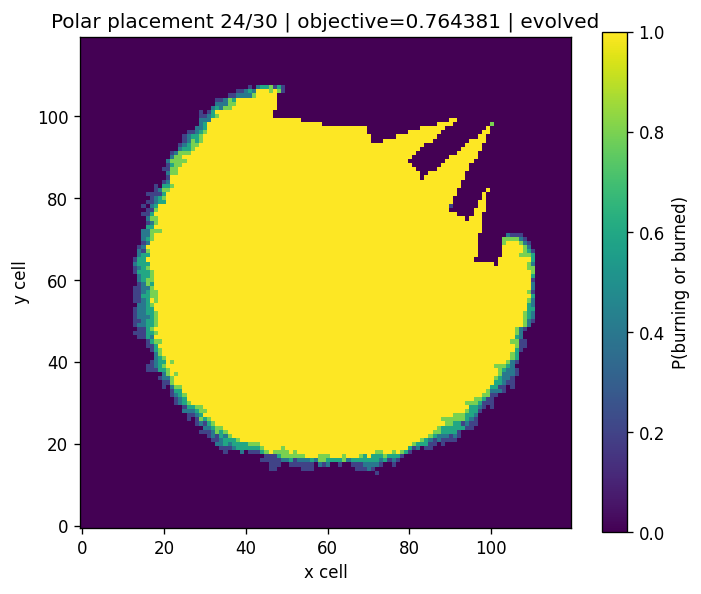

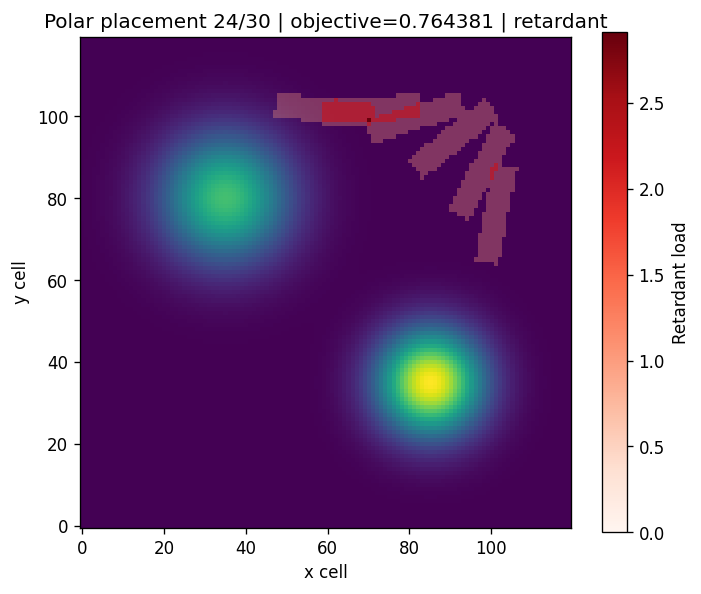

[Init polar] run 024/30 | objective=0.764381
Applying retardant drop: D=[[ 65.131 101.73    4.695]
 [ 78.768 100.289   4.961]
 [ 80.849  47.86    0.563]
 [ 90.694  94.545   5.389]
 [ 98.89   83.392   5.896]
 [101.689  70.179   6.22 ]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


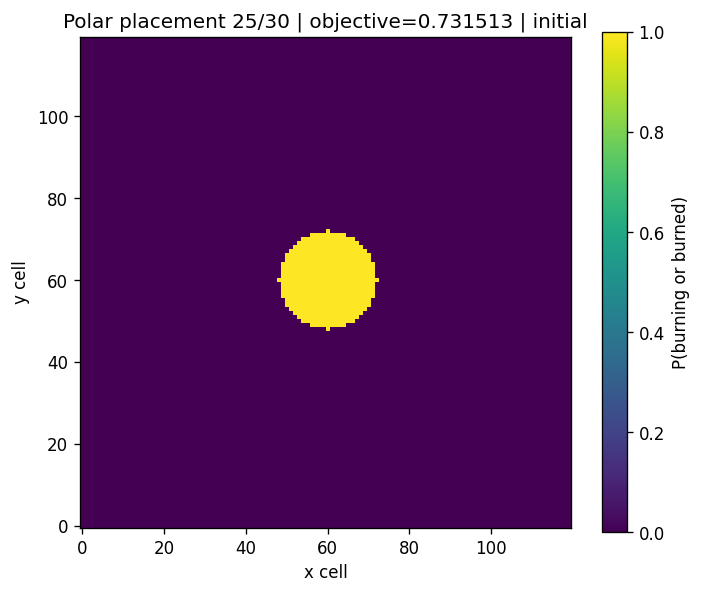

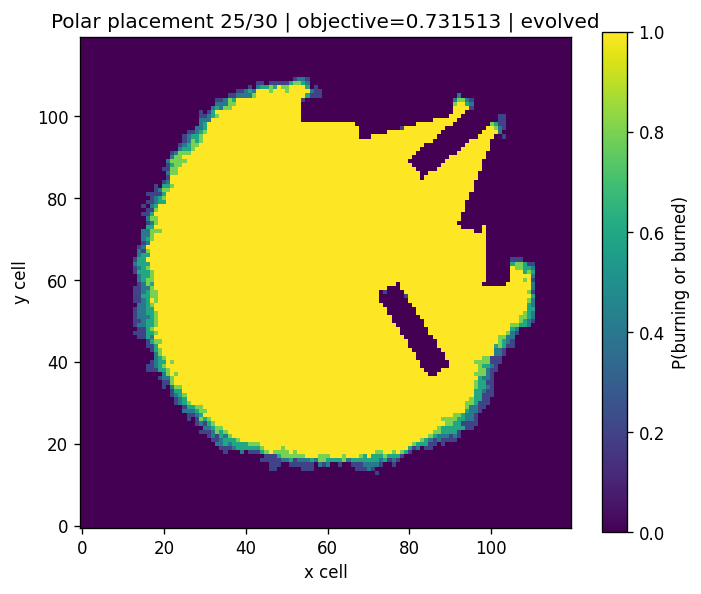

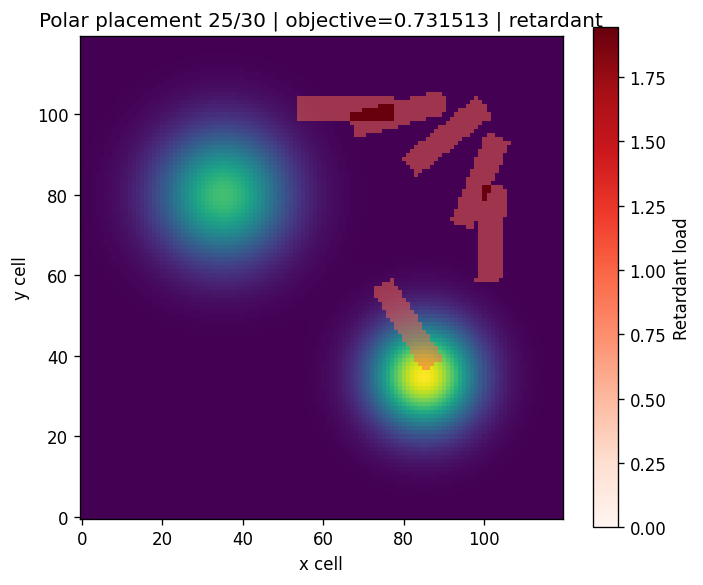

[Init polar] run 025/30 | objective=0.731513
Applying retardant drop: D=[[28.92  58.955  3.102]
 [41.055 74.283  3.729]
 [80.849 47.86   0.563]
 [82.199 36.351  0.883]
 [84.904 62.977  6.279]
 [90.694 94.545  5.389]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


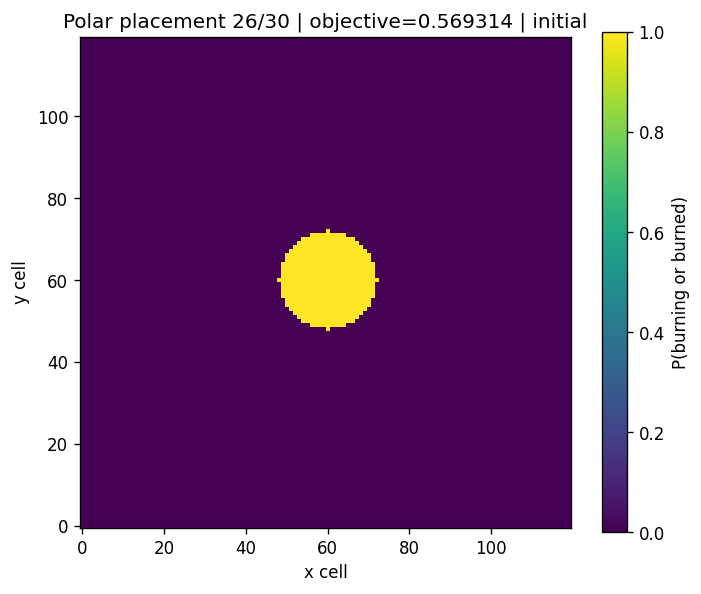

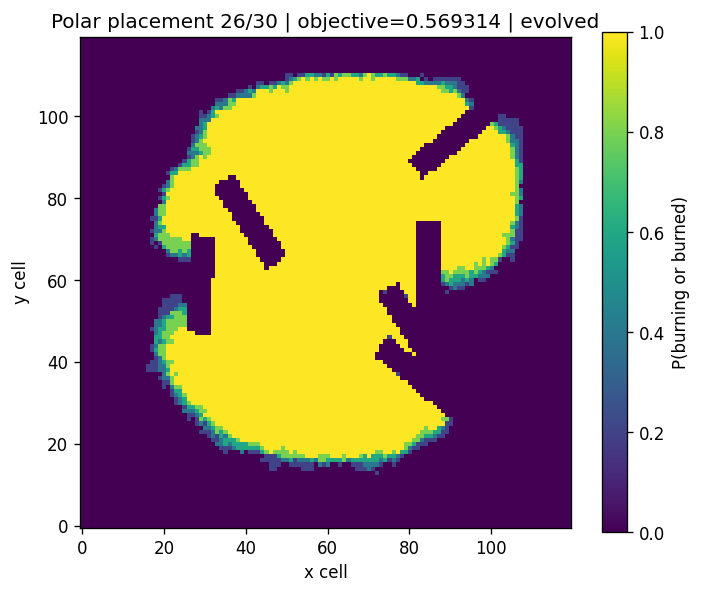

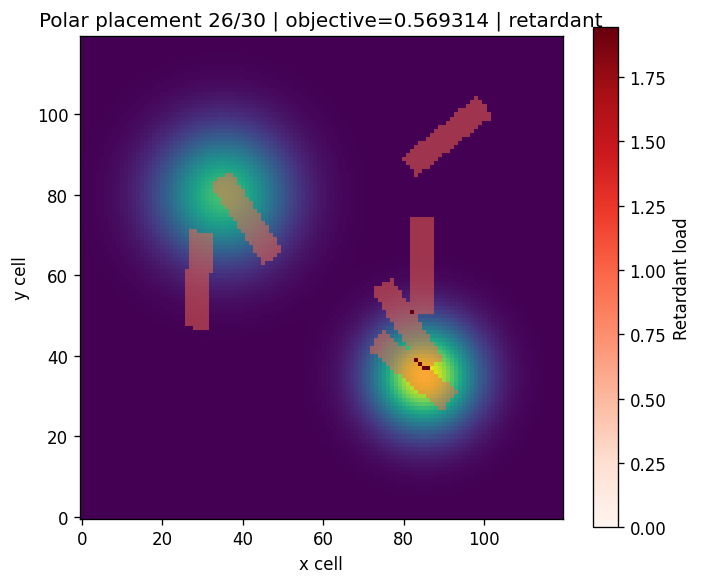

[Init polar] run 026/30 | objective=0.569314
Applying retardant drop: D=[[ 59.092 101.334   4.597]
 [ 70.314 101.598   4.782]
 [ 81.204  99.584   5.029]
 [ 90.694  94.545   5.389]
 [ 97.475  86.389   5.786]
 [100.971  76.123   6.101]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


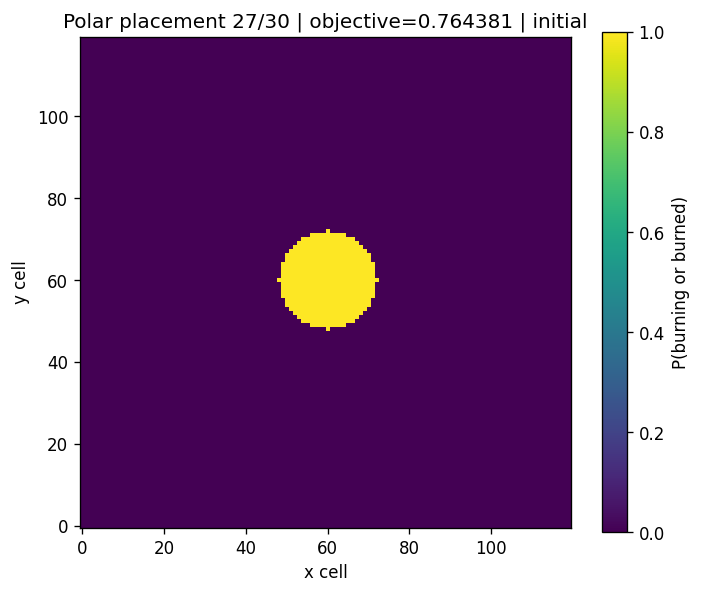

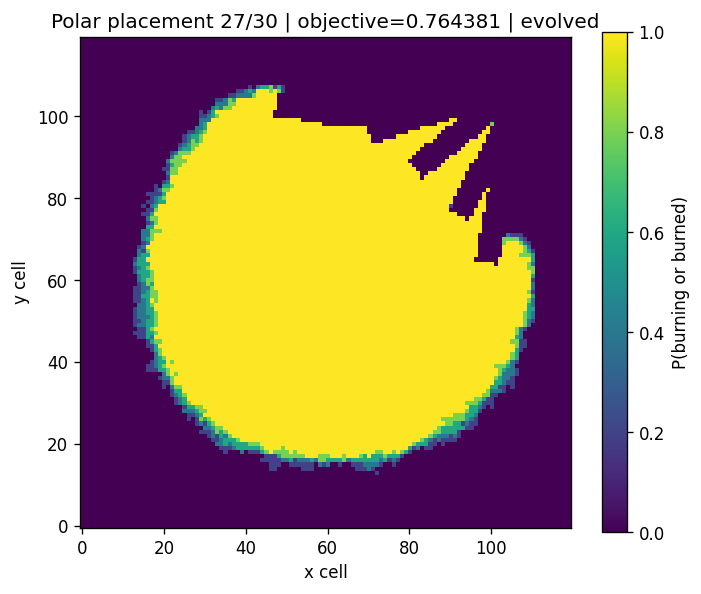

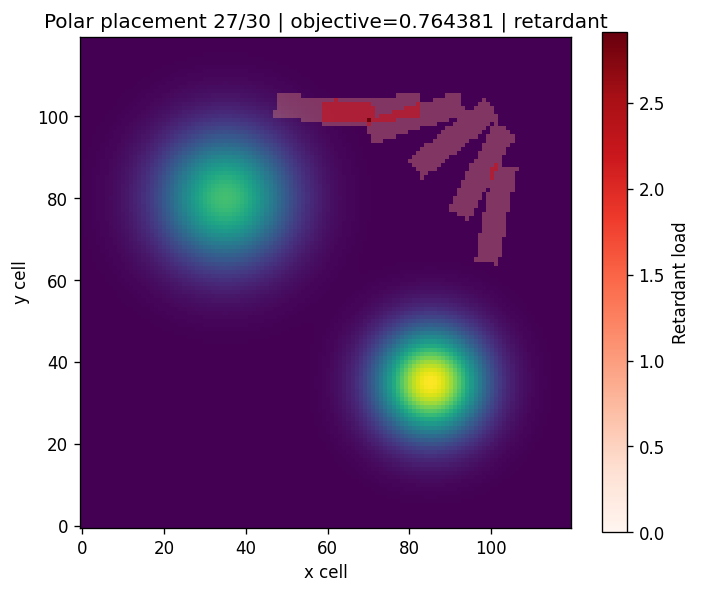

[Init polar] run 027/30 | objective=0.764381
Applying retardant drop: D=[[37.316 64.9    3.321]
 [37.348 55.388  2.953]
 [41.055 74.283  3.729]
 [80.849 47.86   0.563]
 [84.435 57.387  0.173]
 [84.46  68.036  6.106]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


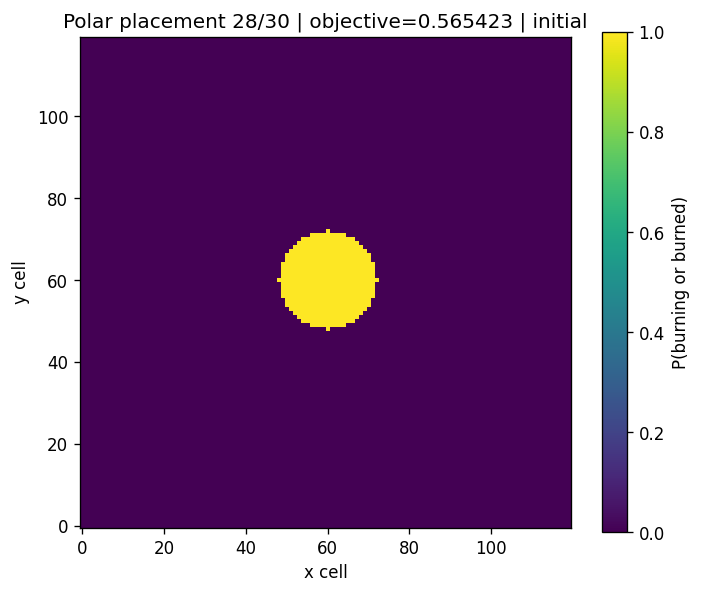

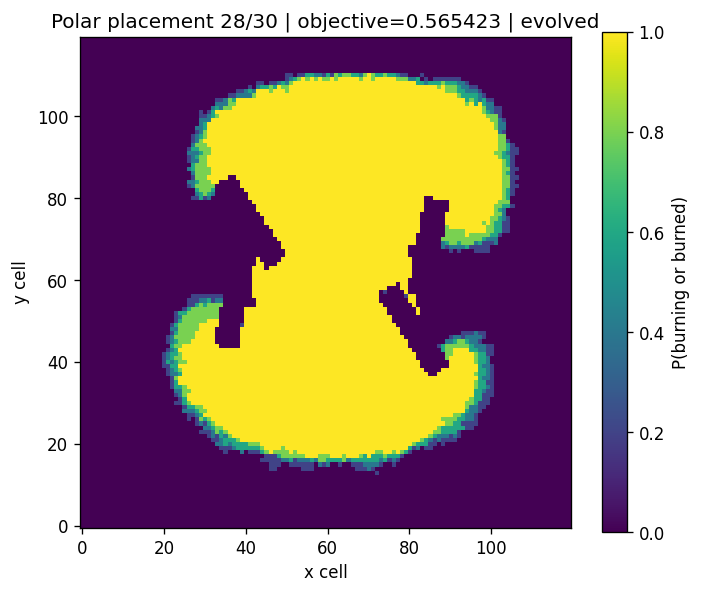

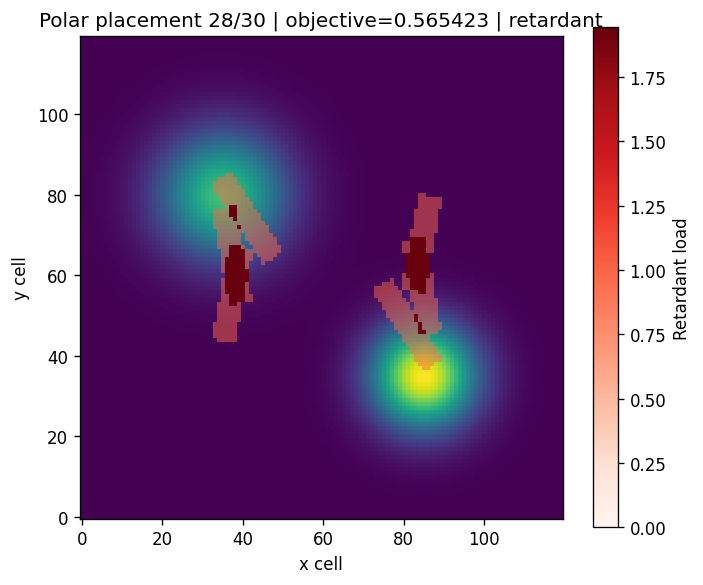

[Init polar] run 028/30 | objective=0.565423
Applying retardant drop: D=[[ 29.015  53.341   3.678]
 [ 73.943  72.522   3.493]
 [ 83.565  85.171   1.561]
 [ 83.834  28.121   2.748]
 [ 88.666  61.469   3.165]
 [101.482  65.807   1.33 ]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


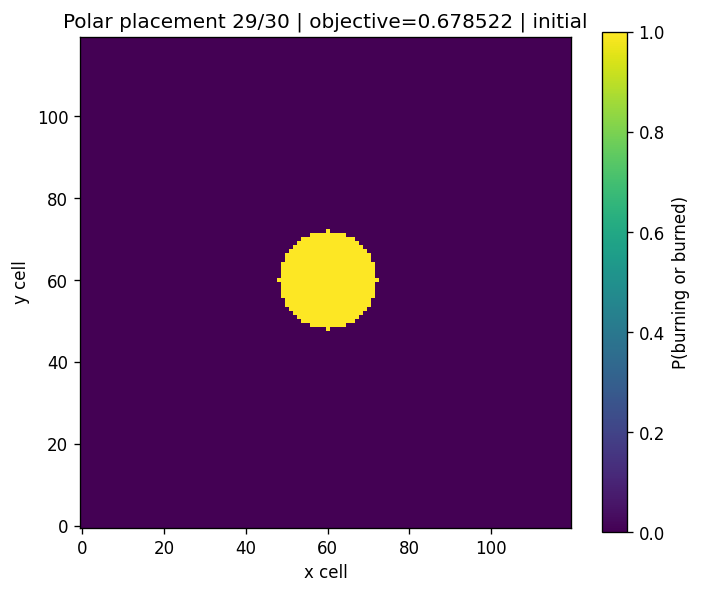

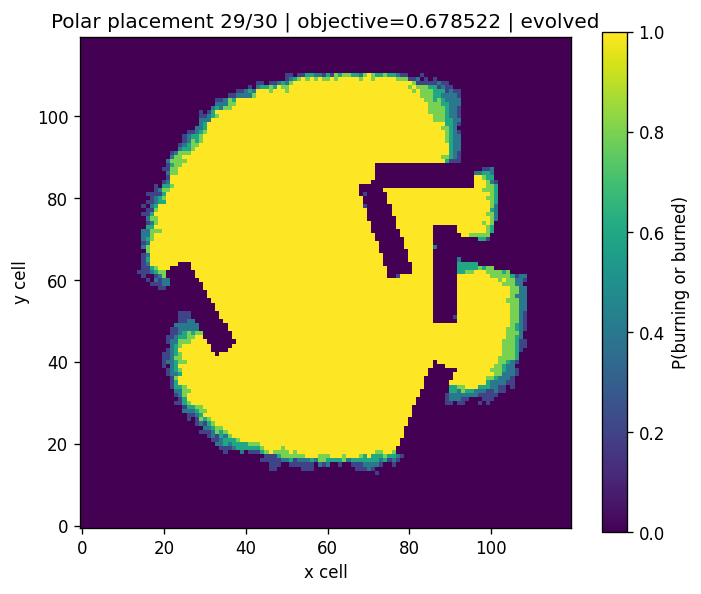

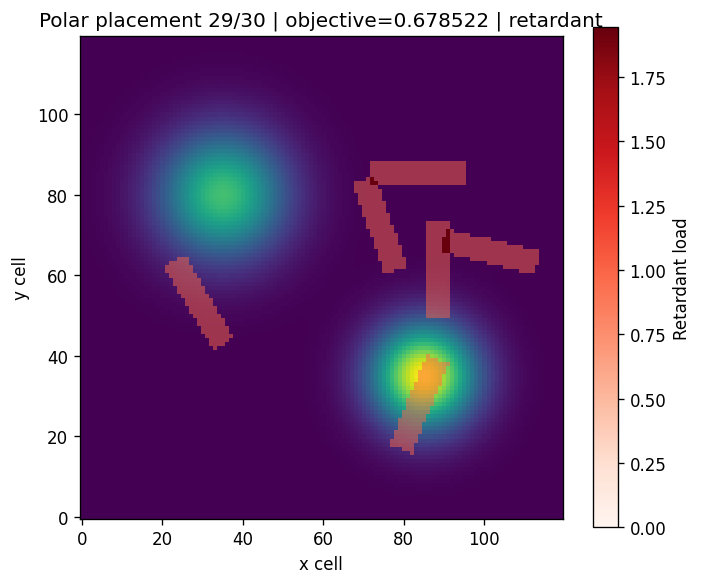

[Init polar] run 029/30 | objective=0.678522
Applying retardant drop: D=[[28.92  58.955  3.102]
 [65.127 29.349  1.453]
 [73.871 31.505  1.199]
 [82.199 36.351  0.883]
 [88.573 43.612  0.562]
 [92.503 52.529  0.278]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


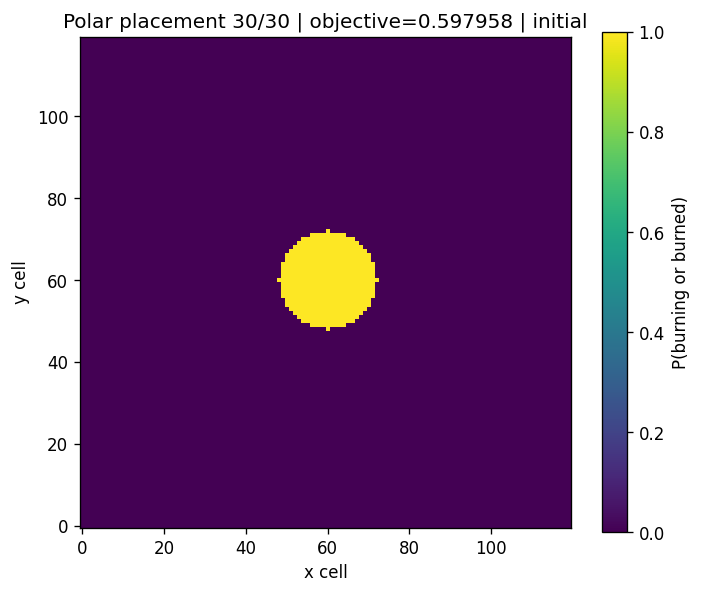

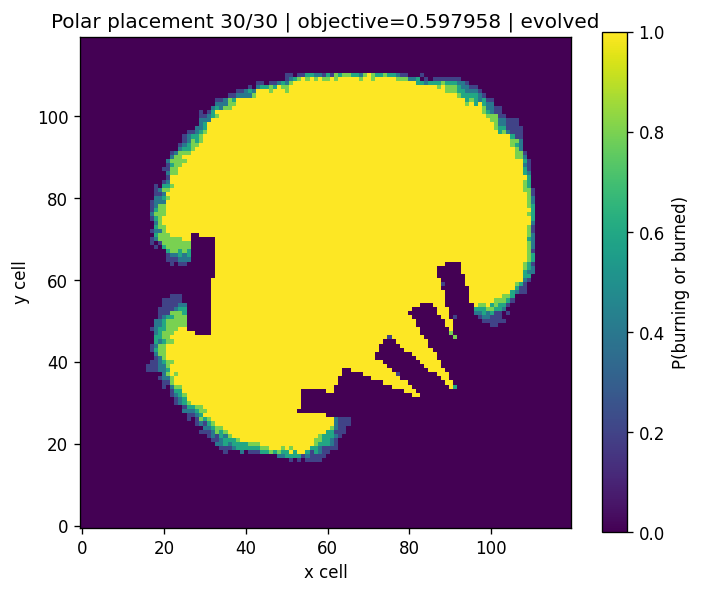

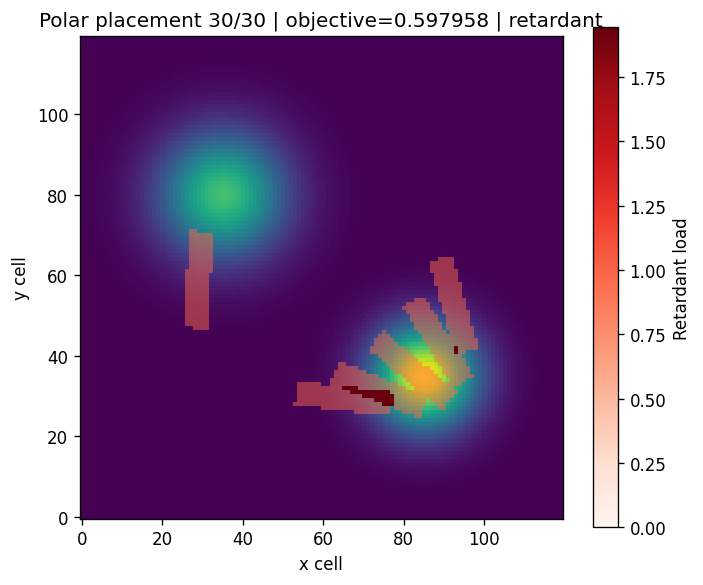

[Init polar] run 030/30 | objective=0.597958
Applying retardant drop: D=[[ 51.764  44.781   4.776]
 [ 68.399  69.527   4.502]
 [ 78.449  63.438   5.008]
 [ 84.227 105.492   0.986]
 [ 97.021  57.302   1.81 ]
 [102.216  81.487   5.288]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
Applying retardant drop: D=[[16.331 54.325  5.575]
 [26.478 58.074  3.903]
 [27.68  85.516  2.823]
 [56.354 84.875  1.537]
 [63.155 37.437  2.412]
 [76.082 82.078  2.081]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
Applying retardant drop: D=[[28.92  58.955  3.102]
 [65.127 29.349  1.453]
 [73.871 31.505  1.199]
 [82.199 36.351  0.883]
 [88.573 43.612  0.562]
 [92.503 52.529  0.278]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
Applying retardant drop: D=[[ 65.818  29.438   1.435]
 [ 70.314 101.598   4.782]
 [ 82.199  36.351   0.883]
 [ 90.694  94.545   5.389]
 [ 92.094  51.188   0.315]
 [100.971  76.123   6.101]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
Applying retardant drop: D=[[37.316 64.9    3.321]
 [37.348

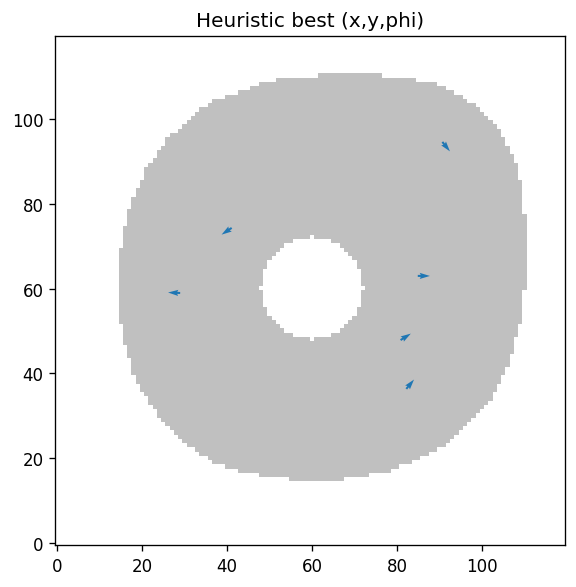

Applying retardant drop: D=[[28.92  58.955  3.102]
 [41.055 74.283  3.729]
 [80.849 47.86   0.563]
 [82.199 36.351  0.883]
 [84.904 62.977  6.279]
 [90.694 94.545  5.389]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


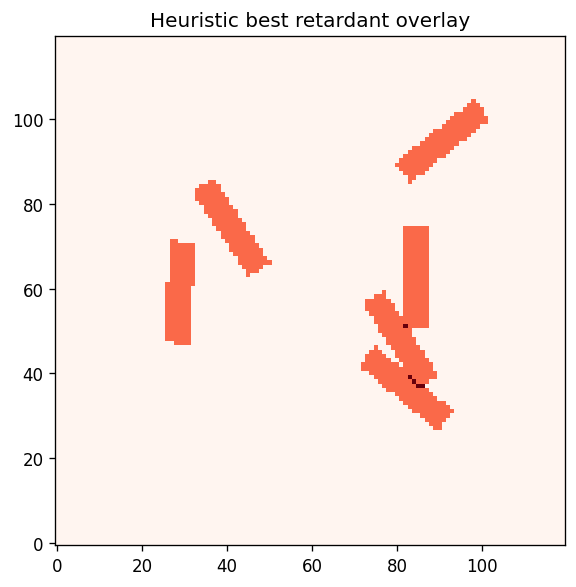

In [15]:
# Heuristic-only optimization in SR space.

n_heur = 30

heuristic_kwargs = {
    "r_value": 0.60,
    "r_downwind": 0.80,
    "r_surround": 0.35,
    "compact_value": 0.35,
    "compact_downwind": 0.35,
    "min_arc_sep_frac": 0.25,
    "surrounding_grouping": 2,
    "surrounding_group_span": 0.20,
    "mix_prob": 0.4,
    "single_strategy_probs": {
        "value_blocking": 0.34,
        "downwind_blocking": 0.33,
        "surrounding": 0.33,
    },
    "random_mix_allocations": True,
    "plot_runs": True,
    "plot_n_sims": 5,
}

X_theta = bo.sample_initial_thetas_polar(
    n_init=n_heur,
    **heuristic_kwargs,
)

X_theta = np.atleast_2d(X_theta)

y = np.array([bo.expected_value_burned_area_polar(th) for th in X_theta], dtype=float)

best_idx = int(np.argmin(y))
best_theta = X_theta[best_idx]

print("Heuristic SR results:")
print("  best_y:", float(np.min(y)))
print("  mean_y:", float(np.mean(y)))

best_params = bo.decode_theta_polar(best_theta)
plot_drop_overlay(bo.search_domain_mask, best_params, "Heuristic best (x,y,phi)")
render_retardant(model, best_params, "Heuristic best retardant overlay")

Applying retardant drop: D=[[37.316 64.9    3.321]
 [37.348 55.388  2.953]
 [41.055 74.283  3.729]
 [80.849 47.86   0.563]
 [84.435 57.387  0.173]
 [84.46  68.036  6.106]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


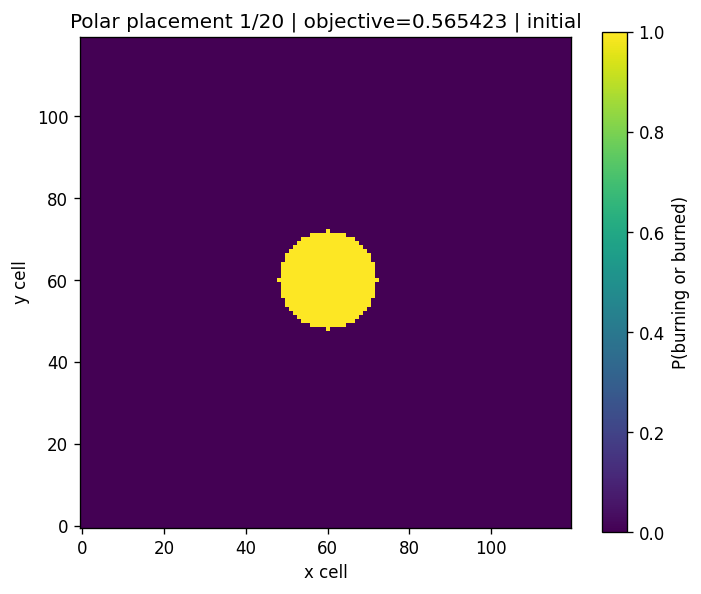

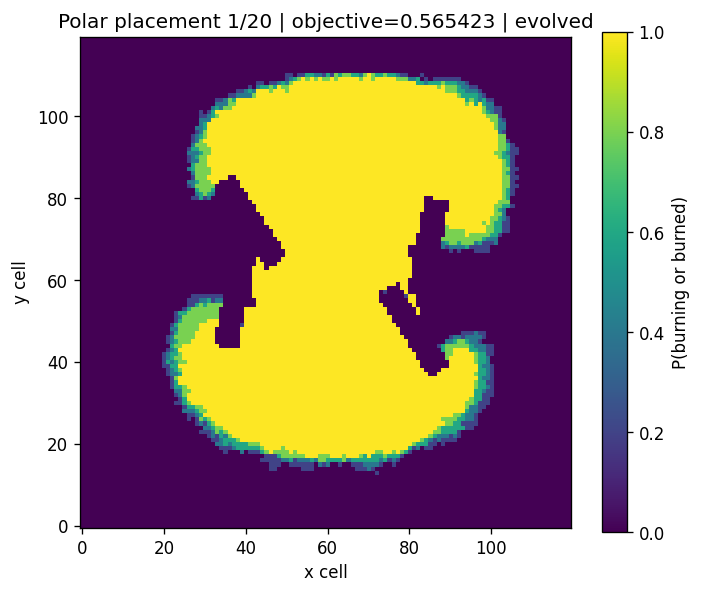

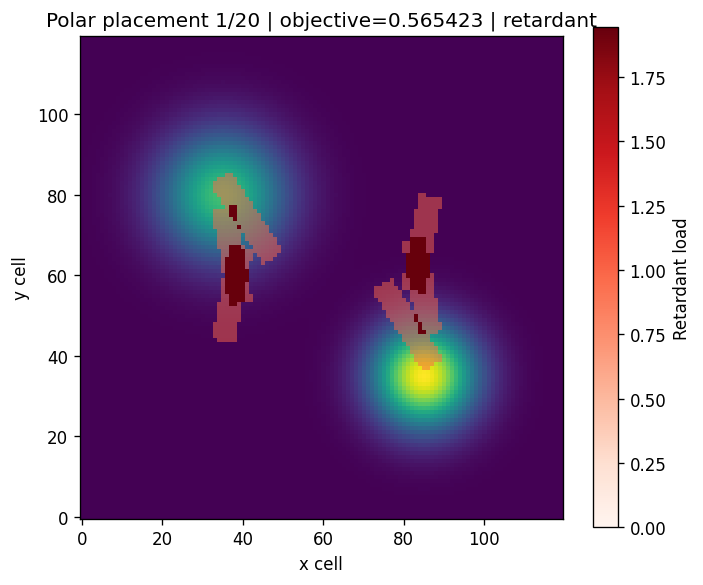

[Init polar] run 001/20 | objective=0.565423
Applying retardant drop: D=[[ 59.092 101.334   4.597]
 [ 70.314 101.598   4.782]
 [ 81.204  99.584   5.029]
 [ 90.694  94.545   5.389]
 [ 97.475  86.389   5.786]
 [100.971  76.123   6.101]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


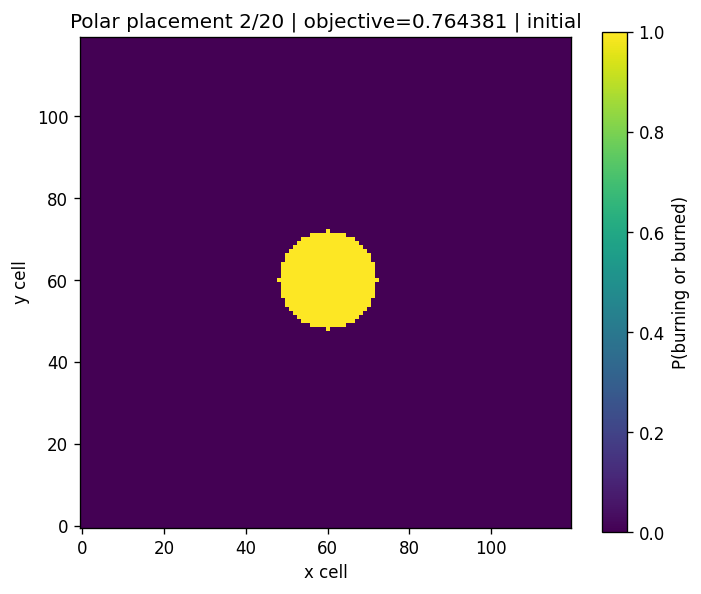

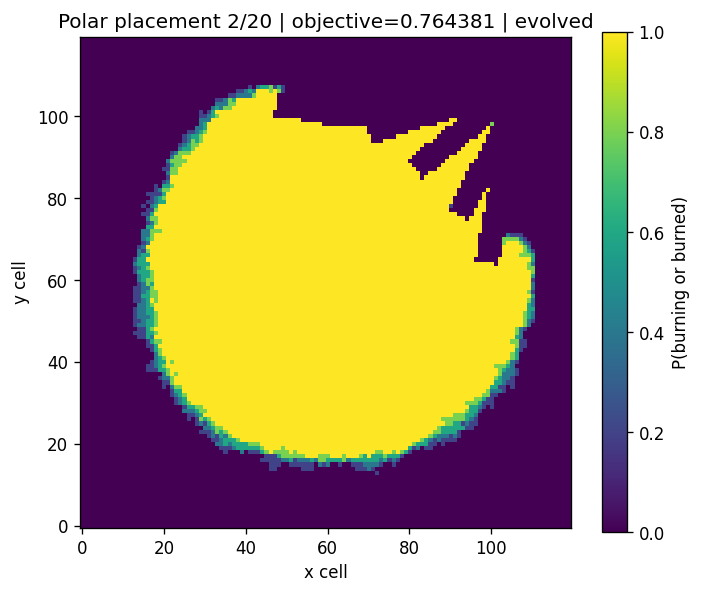

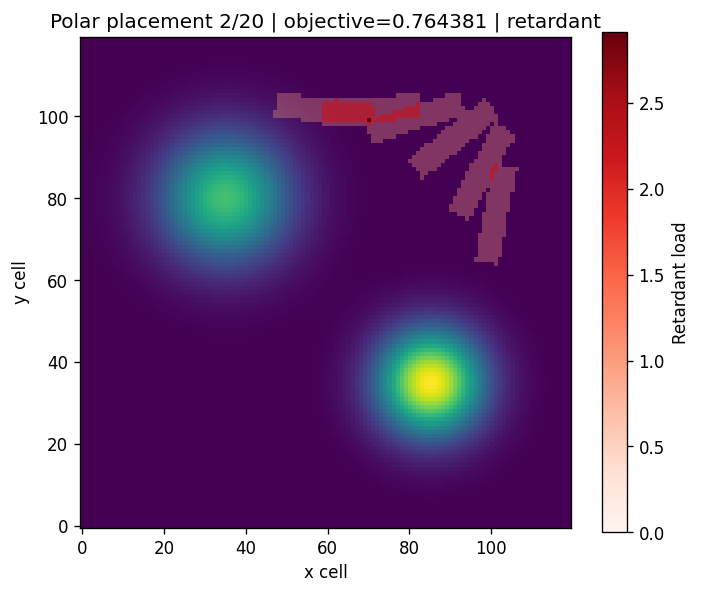

[Init polar] run 002/20 | objective=0.764381
Applying retardant drop: D=[[ 28.92   58.955   3.102]
 [ 74.588 101.13    4.864]
 [ 82.199  36.351   0.883]
 [ 90.694  94.545   5.389]
 [ 99.479  81.831   5.947]
 [101.79   65.007   0.023]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


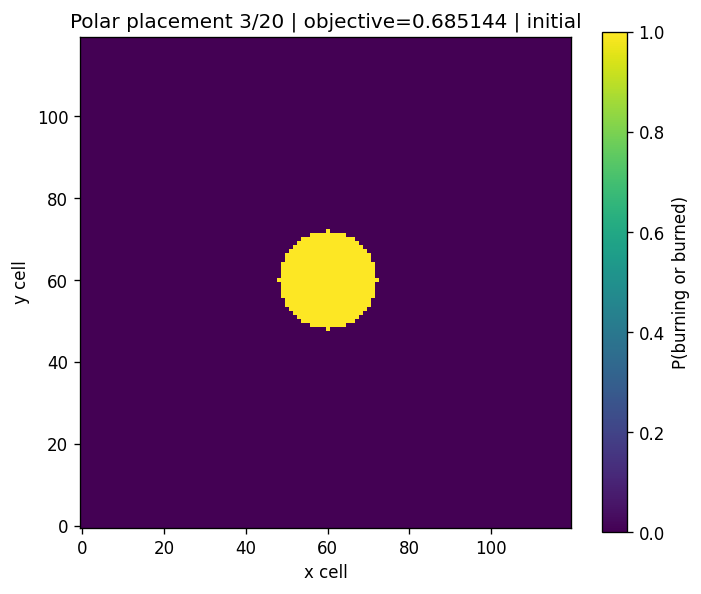

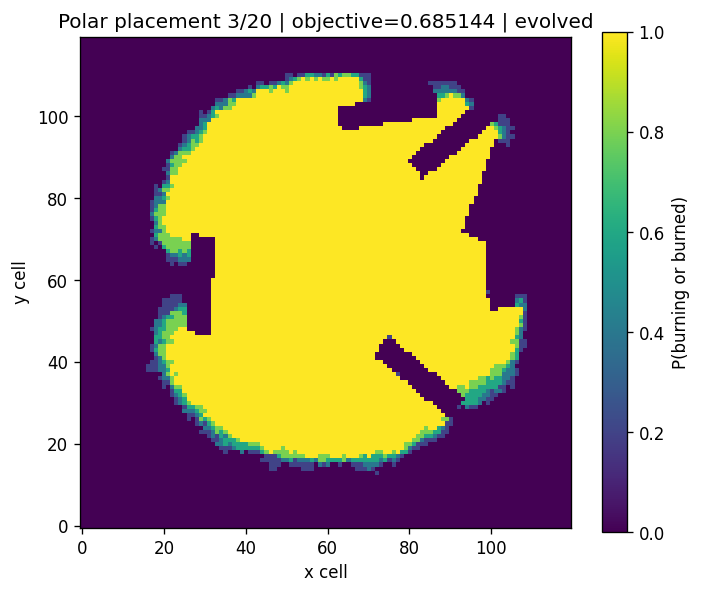

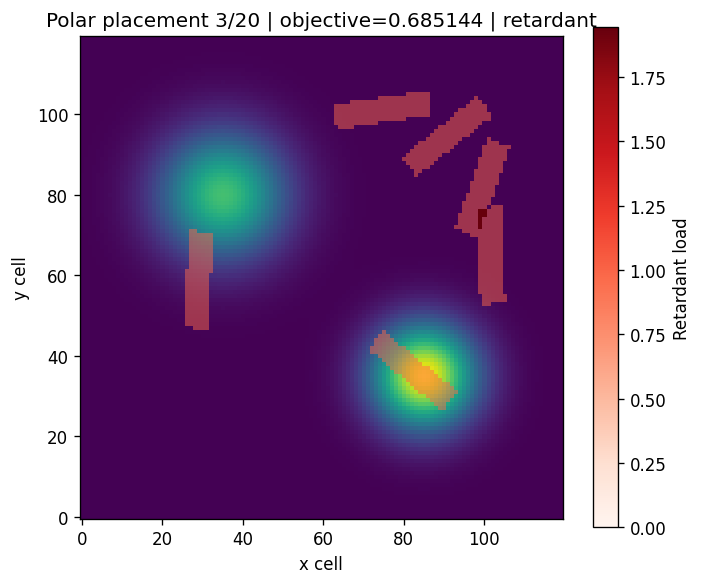

[Init polar] run 003/20 | objective=0.685144
Applying retardant drop: D=[[ 59.092 101.334   4.597]
 [ 70.314 101.598   4.782]
 [ 81.204  99.584   5.029]
 [ 90.694  94.545   5.389]
 [ 97.475  86.389   5.786]
 [100.971  76.123   6.101]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


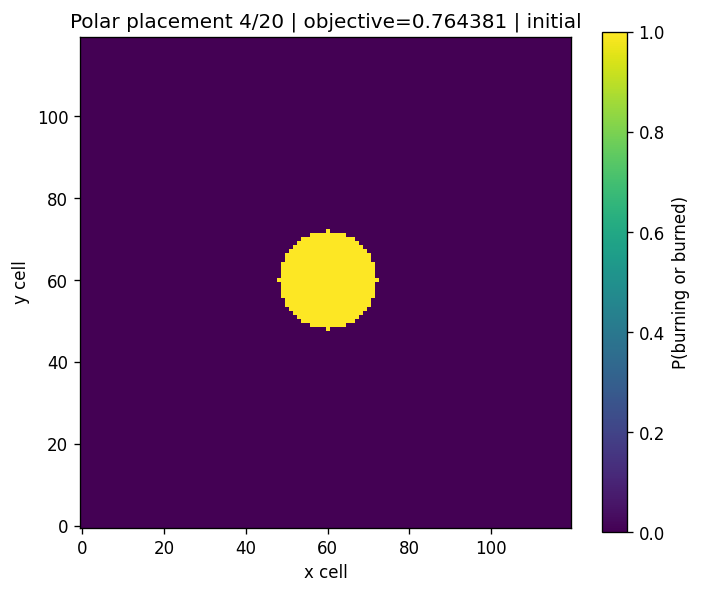

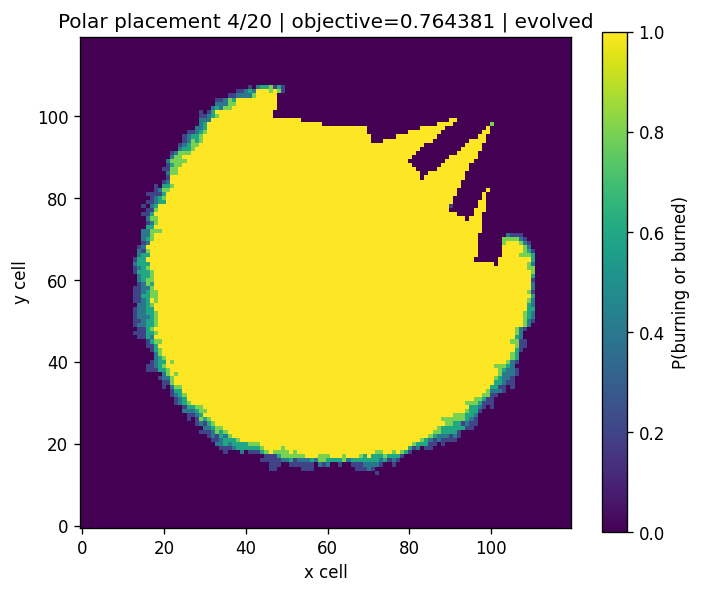

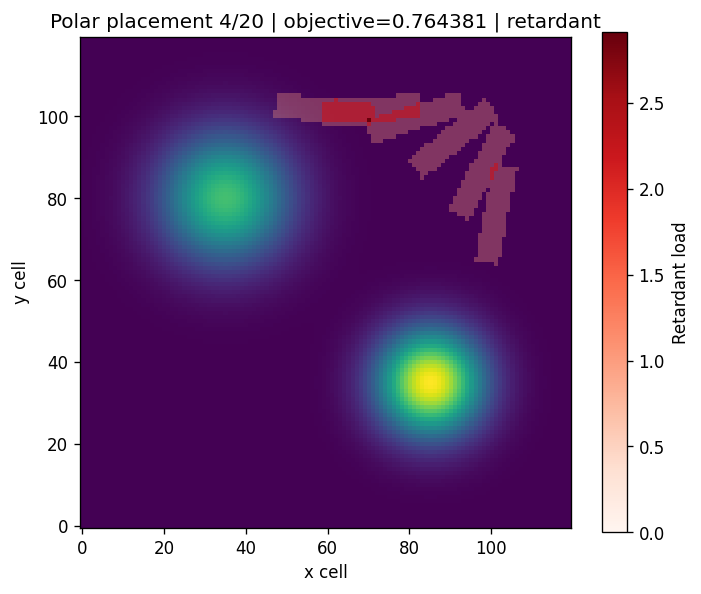

[Init polar] run 004/20 | objective=0.764381
Applying retardant drop: D=[[ 59.092 101.334   4.597]
 [ 70.314 101.598   4.782]
 [ 81.204  99.584   5.029]
 [ 90.694  94.545   5.389]
 [ 97.475  86.389   5.786]
 [100.971  76.123   6.101]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


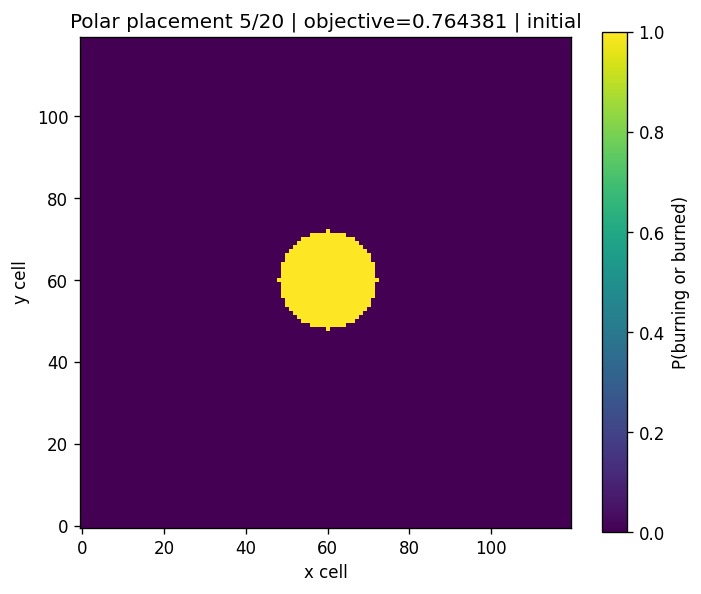

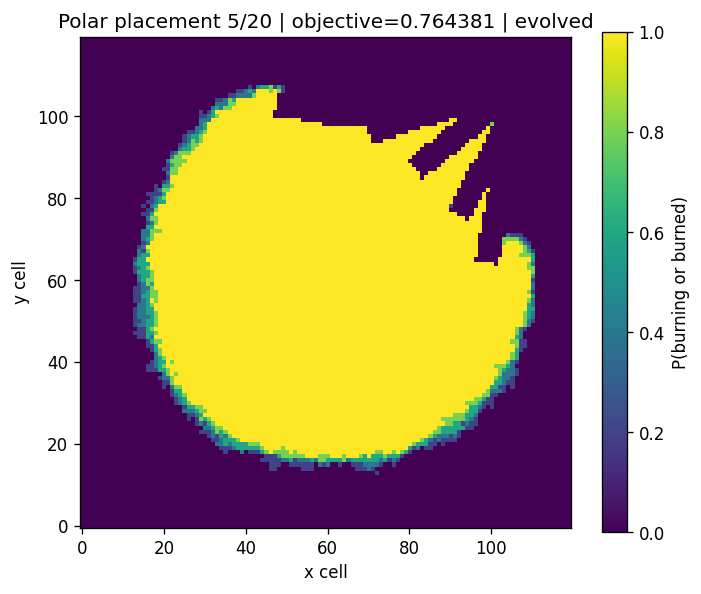

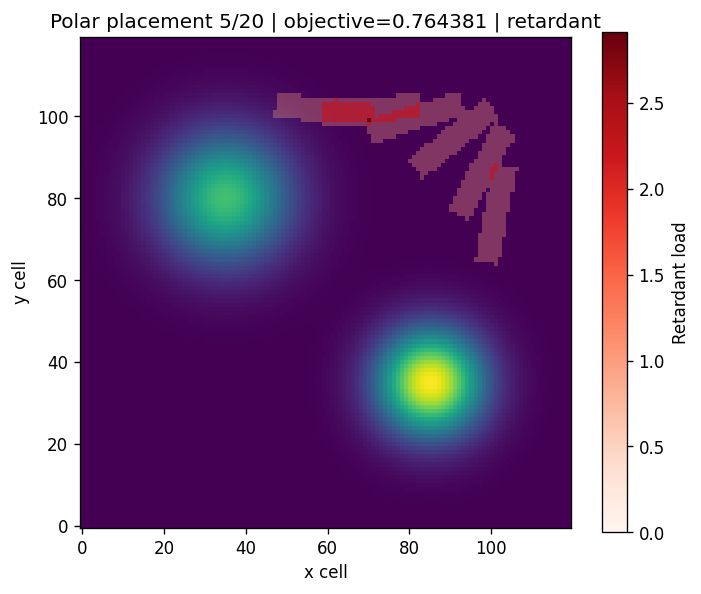

[Init polar] run 005/20 | objective=0.764381
Applying retardant drop: D=[[37.316 64.9    3.321]
 [37.348 55.388  2.953]
 [41.055 74.283  3.729]
 [80.849 47.86   0.563]
 [84.435 57.387  0.173]
 [84.46  68.036  6.106]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


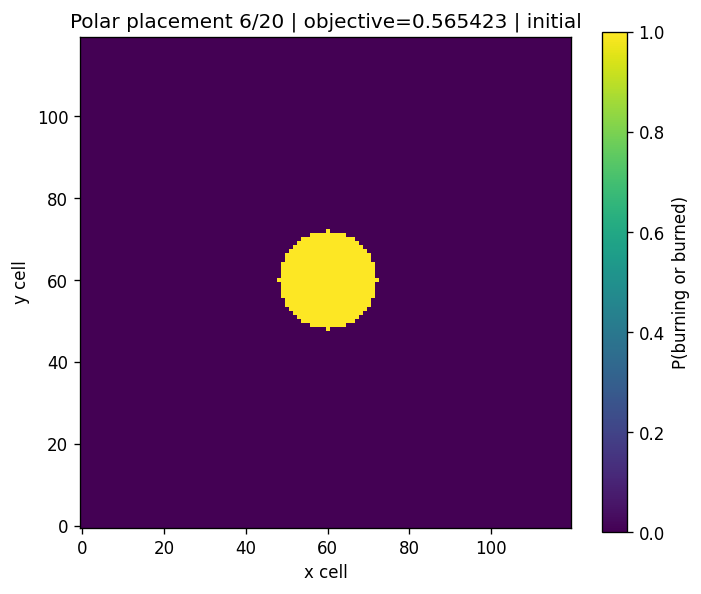

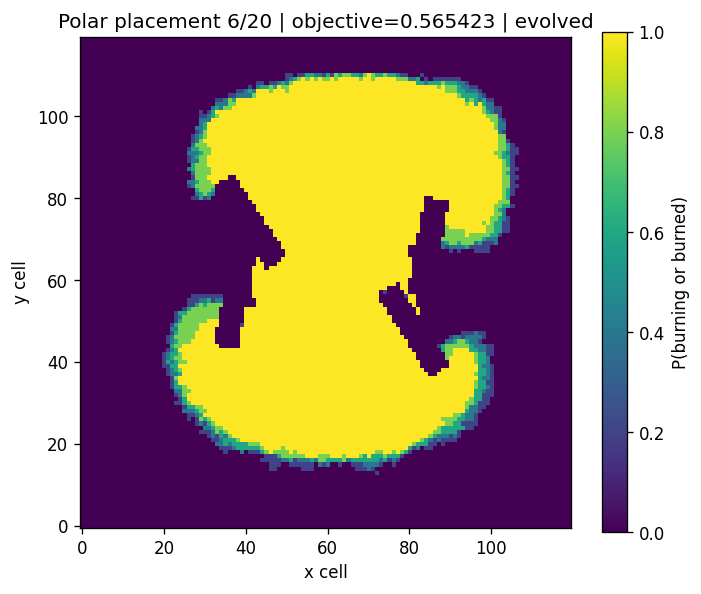

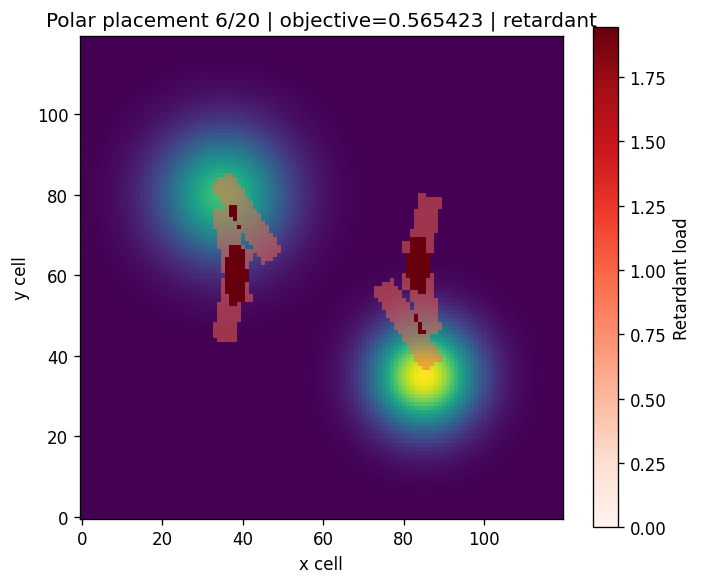

[Init polar] run 006/20 | objective=0.565423
Applying retardant drop: D=[[37.316 64.9    3.321]
 [37.348 55.388  2.953]
 [41.055 74.283  3.729]
 [80.849 47.86   0.563]
 [84.435 57.387  0.173]
 [84.46  68.036  6.106]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


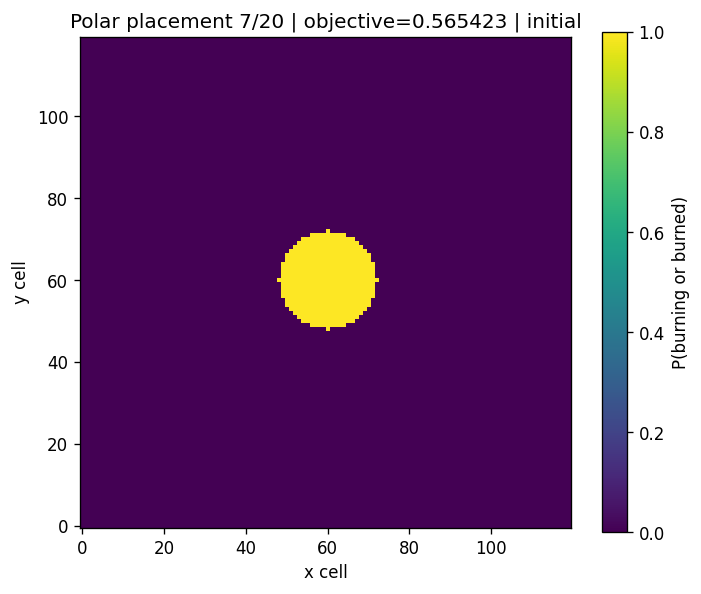

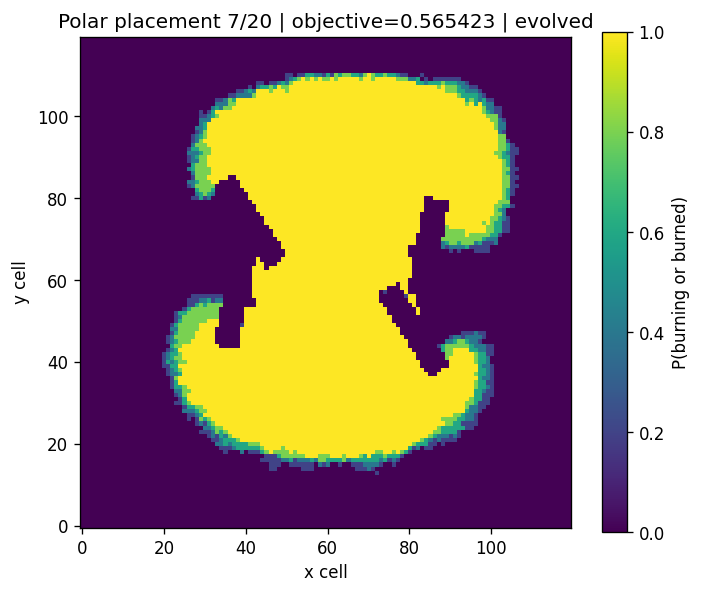

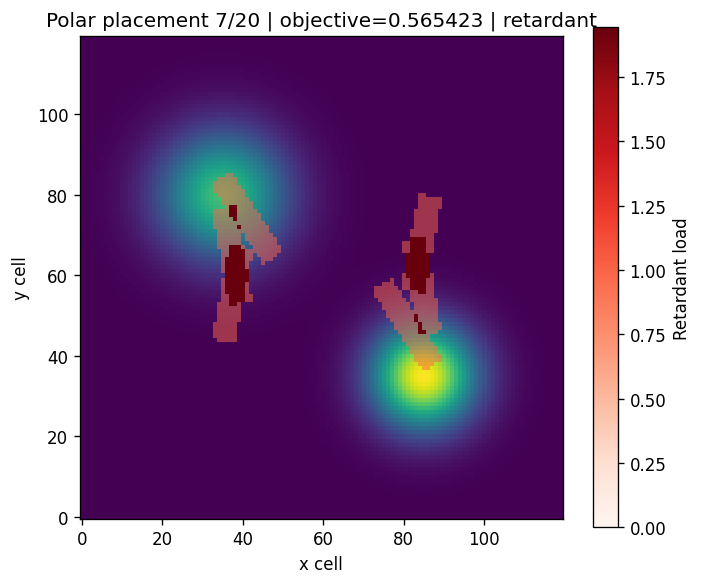

[Init polar] run 007/20 | objective=0.565423
Applying retardant drop: D=[[ 41.055  74.283   3.729]
 [ 59.951 101.427   4.612]
 [ 80.849  47.86    0.563]
 [ 82.199  36.351   0.883]
 [ 84.904  62.977   6.279]
 [ 90.694  94.545   5.389]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


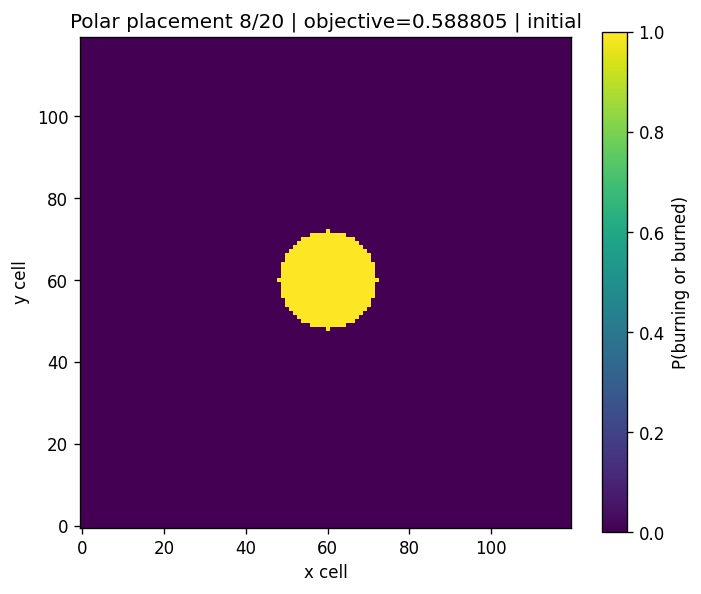

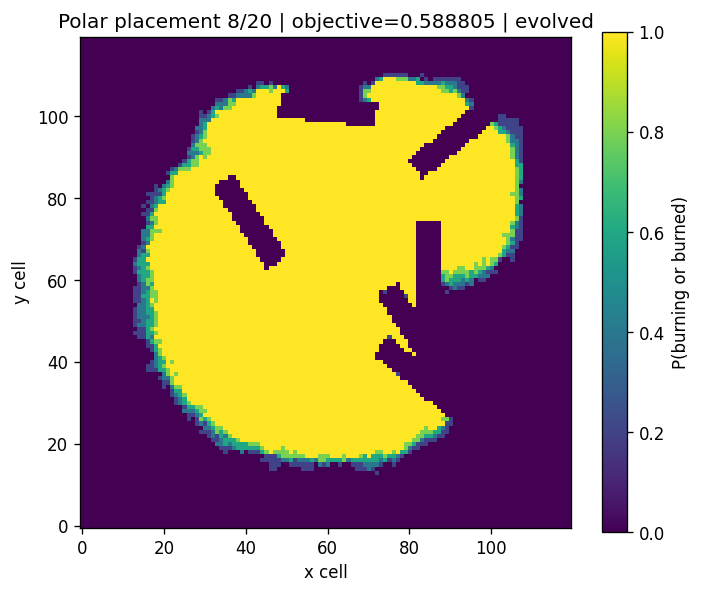

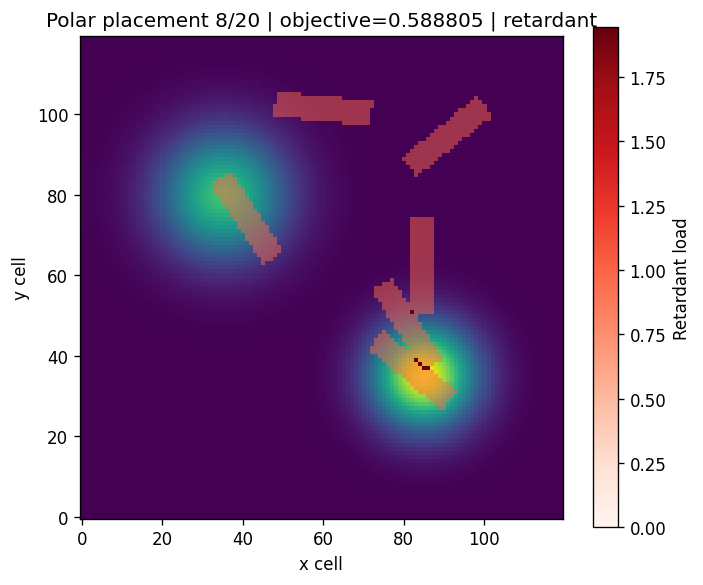

[Init polar] run 008/20 | objective=0.588805
Applying retardant drop: D=[[ 59.092 101.334   4.597]
 [ 70.314 101.598   4.782]
 [ 81.204  99.584   5.029]
 [ 90.694  94.545   5.389]
 [ 97.475  86.389   5.786]
 [100.971  76.123   6.101]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


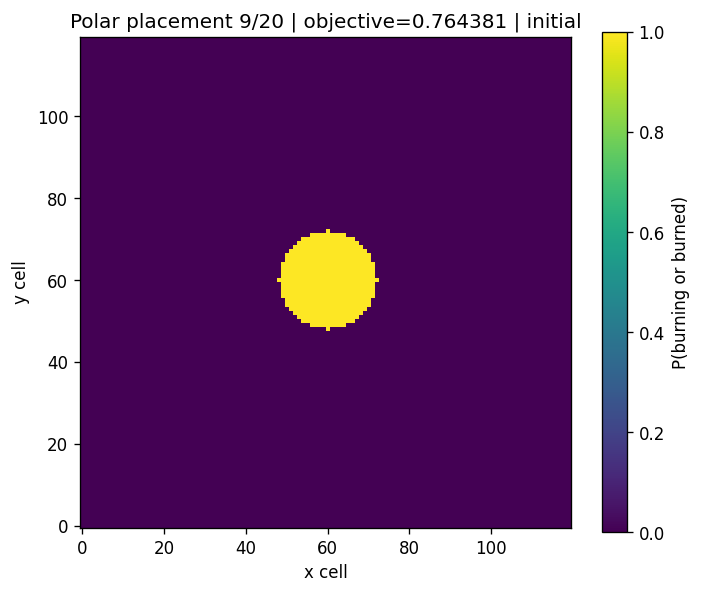

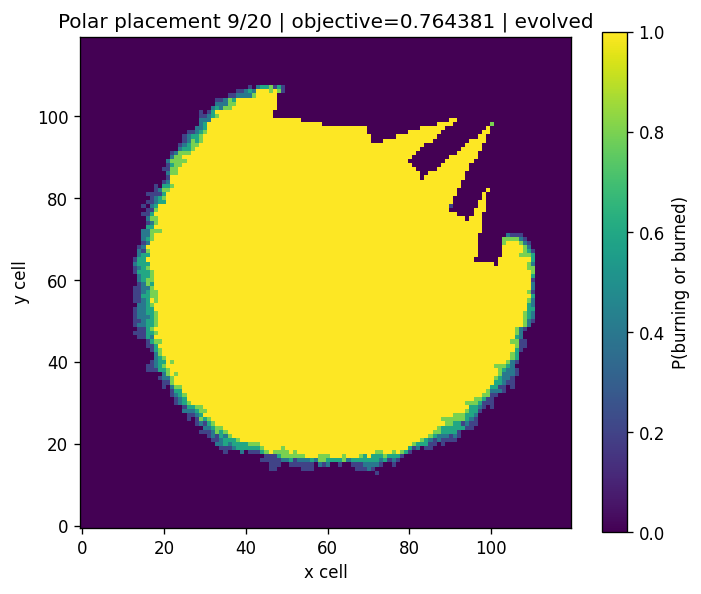

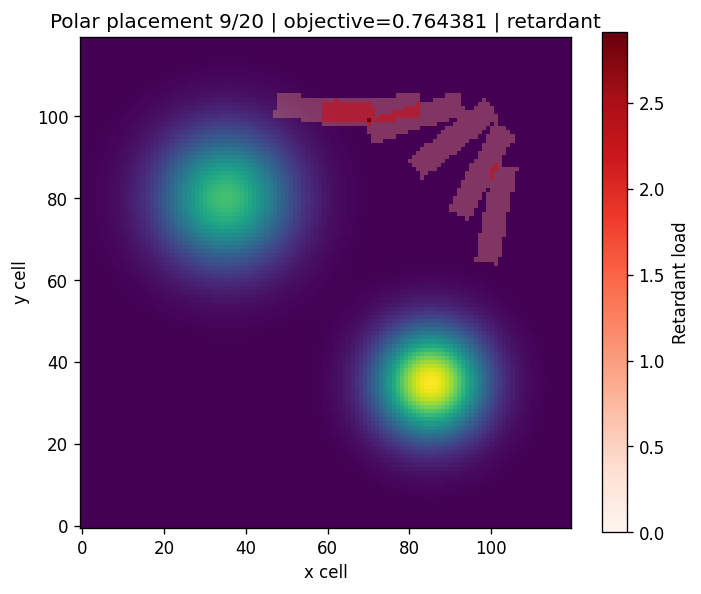

[Init polar] run 009/20 | objective=0.764381
Applying retardant drop: D=[[ 59.951 101.427   4.612]
 [ 65.818  29.438   1.435]
 [ 80.849  47.86    0.563]
 [ 82.199  36.351   0.883]
 [ 90.694  94.545   5.389]
 [ 92.094  51.188   0.315]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


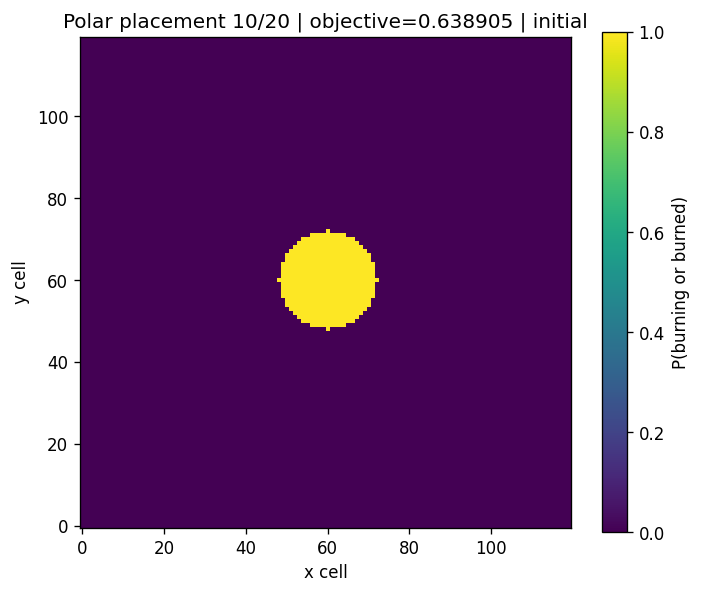

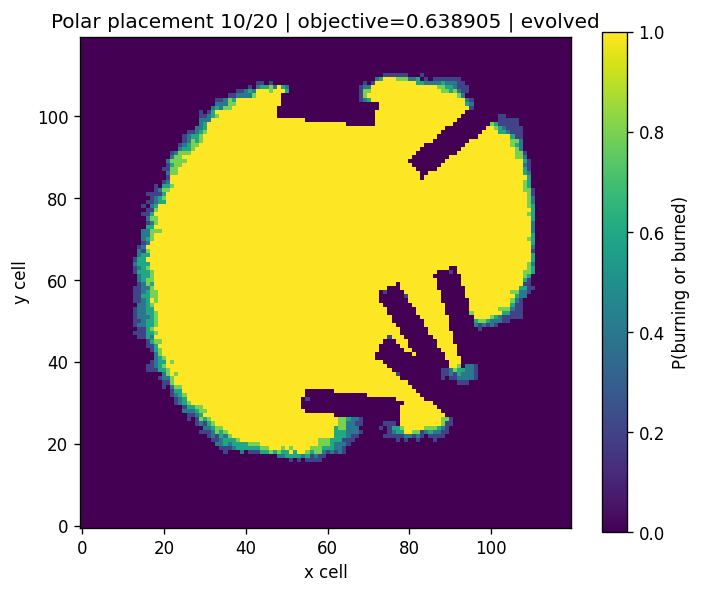

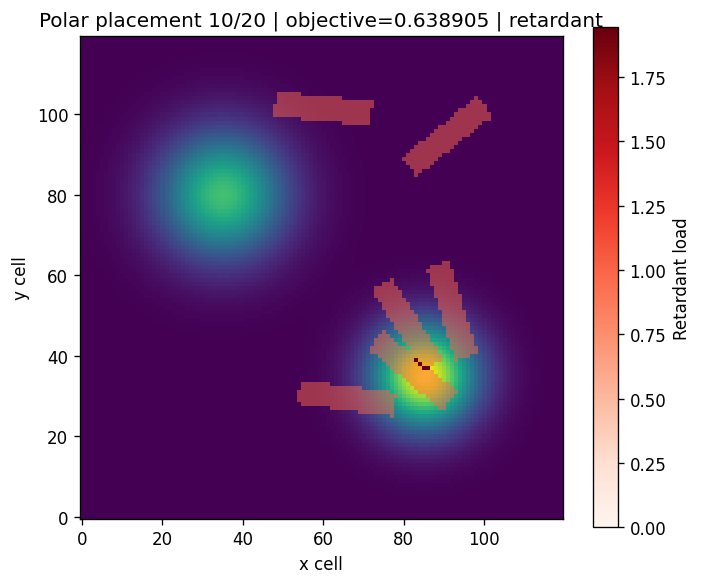

[Init polar] run 010/20 | objective=0.638905
Applying retardant drop: D=[[37.316 64.9    3.321]
 [37.348 55.388  2.953]
 [41.055 74.283  3.729]
 [80.849 47.86   0.563]
 [84.435 57.387  0.173]
 [84.46  68.036  6.106]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


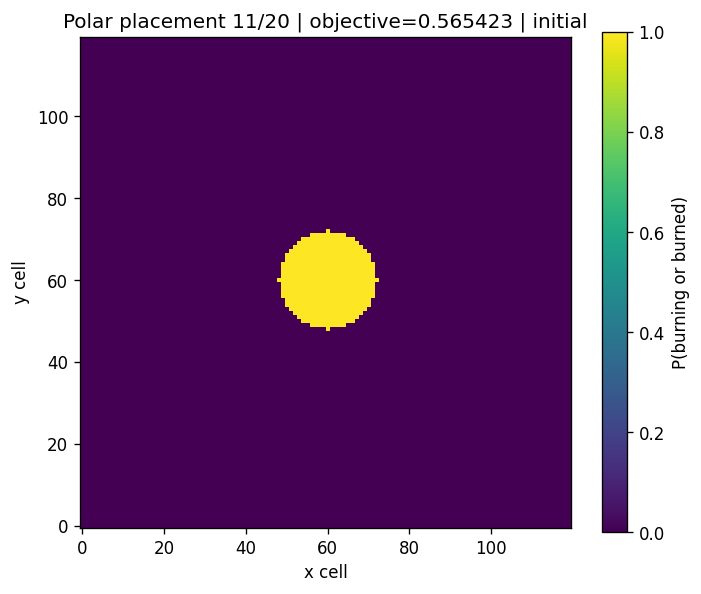

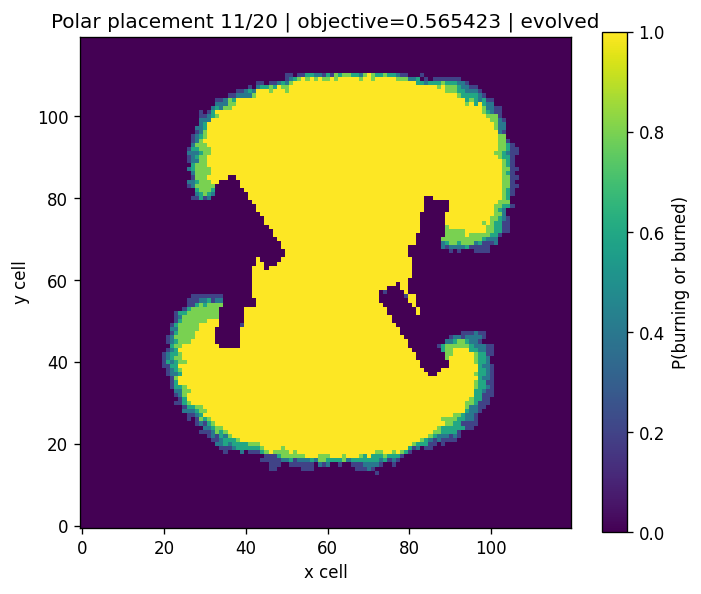

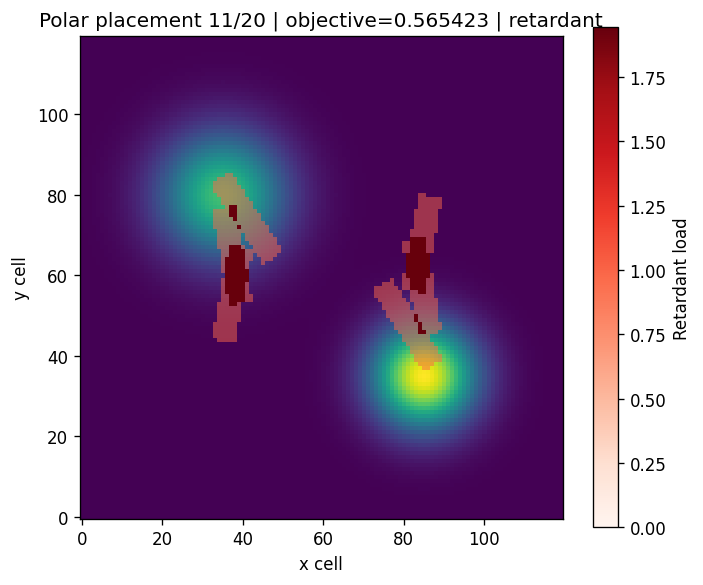

[Init polar] run 011/20 | objective=0.565423
Applying retardant drop: D=[[ 28.92   58.955   3.102]
 [ 41.055  74.283   3.729]
 [ 59.951 101.427   4.612]
 [ 80.849  47.86    0.563]
 [ 82.199  36.351   0.883]
 [ 90.694  94.545   5.389]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


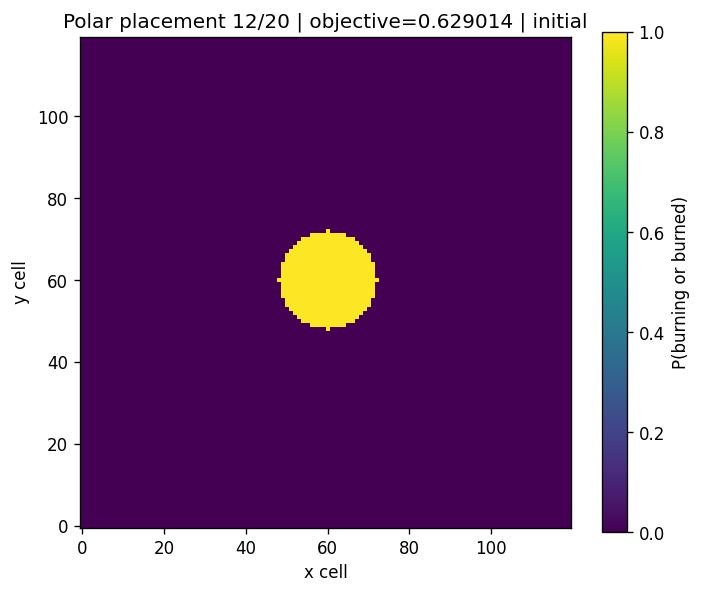

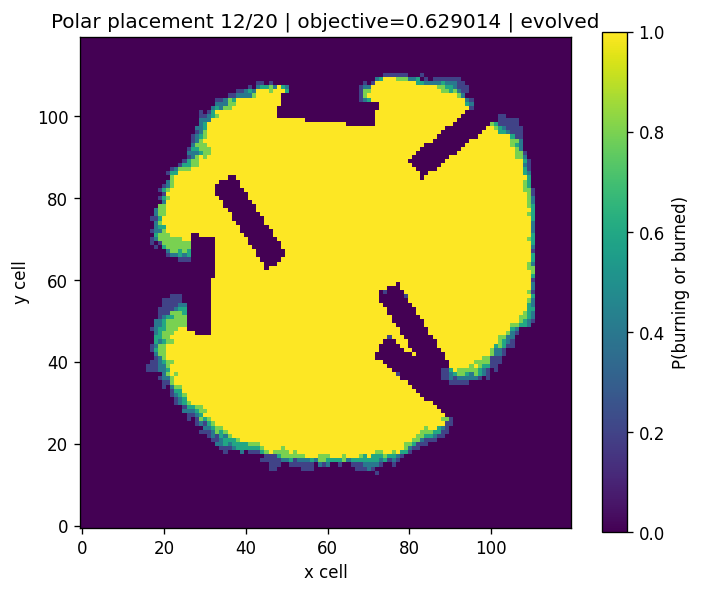

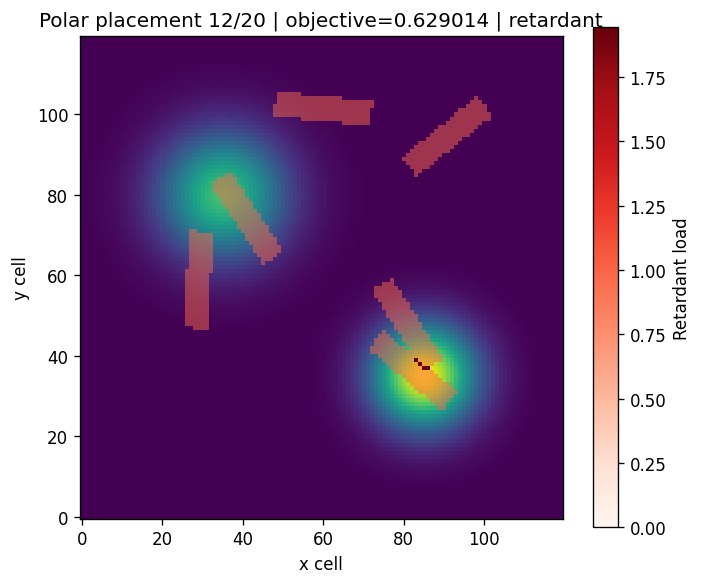

[Init polar] run 012/20 | objective=0.629014
Applying retardant drop: D=[[38.993 33.951  3.771]
 [39.854 55.546  0.374]
 [59.028 46.239  3.598]
 [62.981 24.755  6.134]
 [82.009 23.205  5.328]
 [88.821 53.098  2.729]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


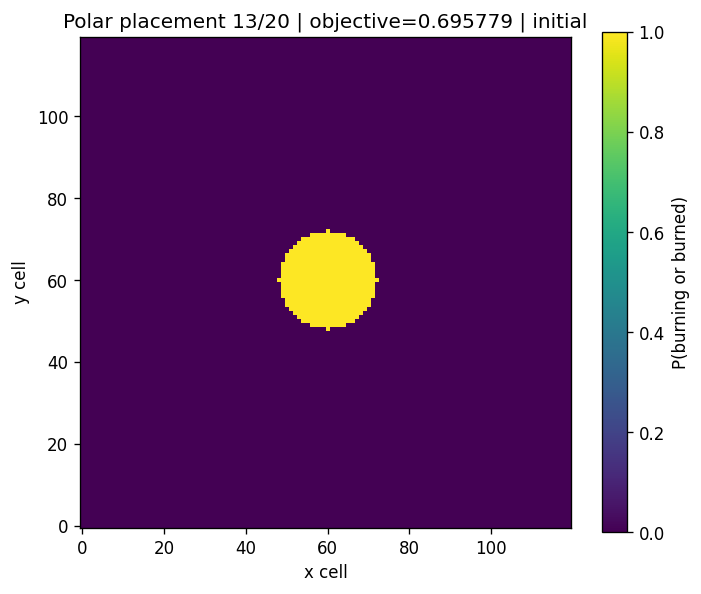

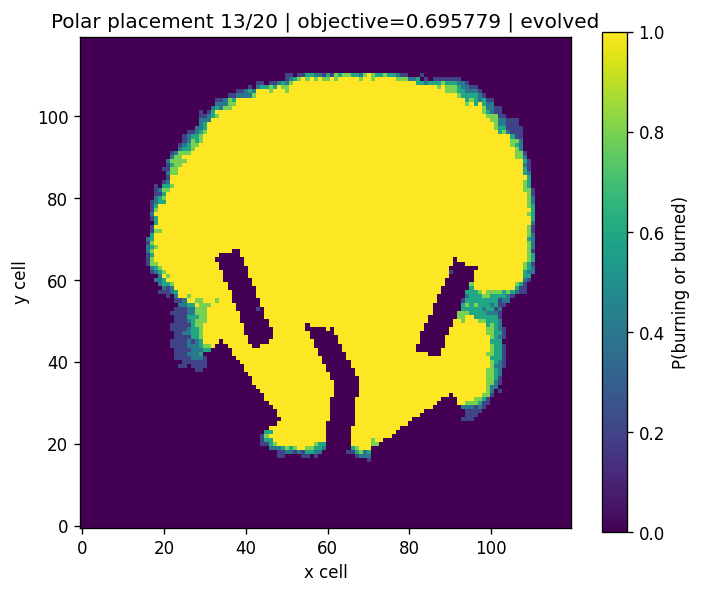

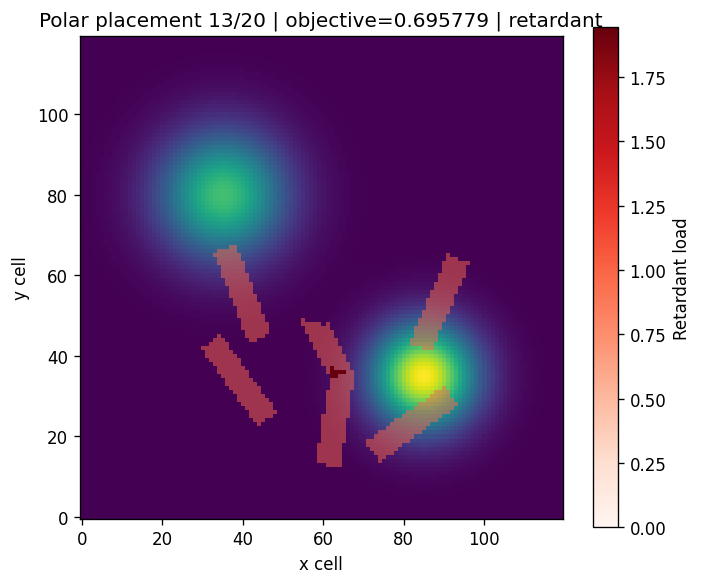

[Init polar] run 013/20 | objective=0.695779
Applying retardant drop: D=[[41.055 74.283  3.729]
 [65.818 29.438  1.435]
 [80.849 47.86   0.563]
 [82.199 36.351  0.883]
 [84.904 62.977  6.279]
 [92.094 51.188  0.315]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


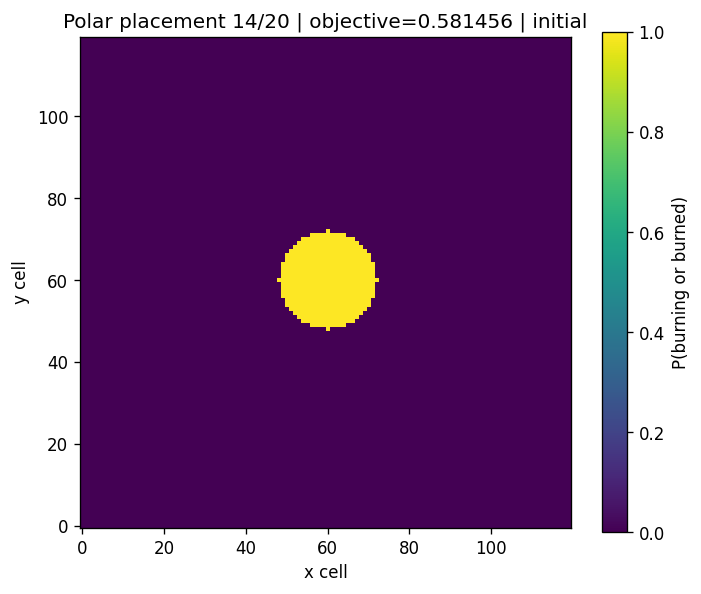

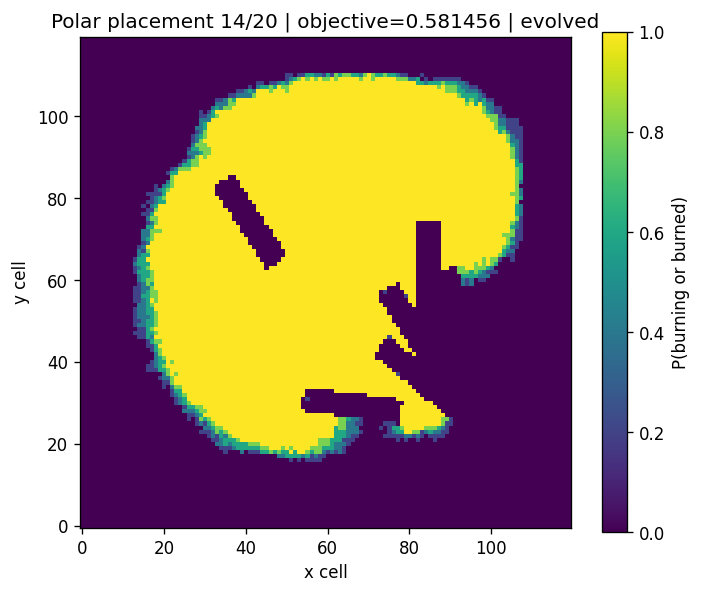

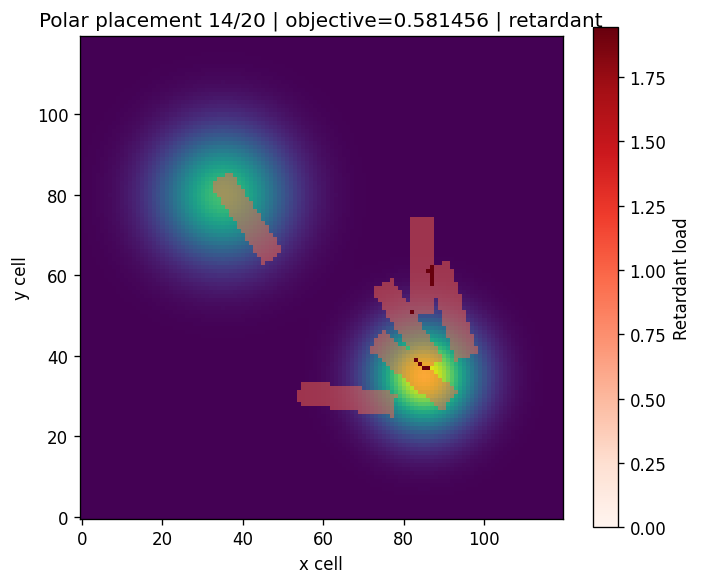

[Init polar] run 014/20 | objective=0.581456
Applying retardant drop: D=[[ 41.055  74.283   3.729]
 [ 59.951 101.427   4.612]
 [ 80.849  47.86    0.563]
 [ 82.199  36.351   0.883]
 [ 84.904  62.977   6.279]
 [ 90.694  94.545   5.389]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


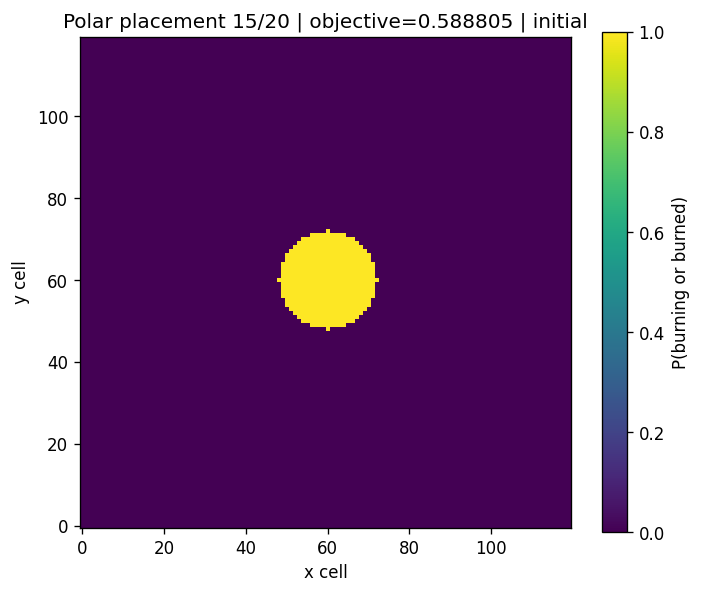

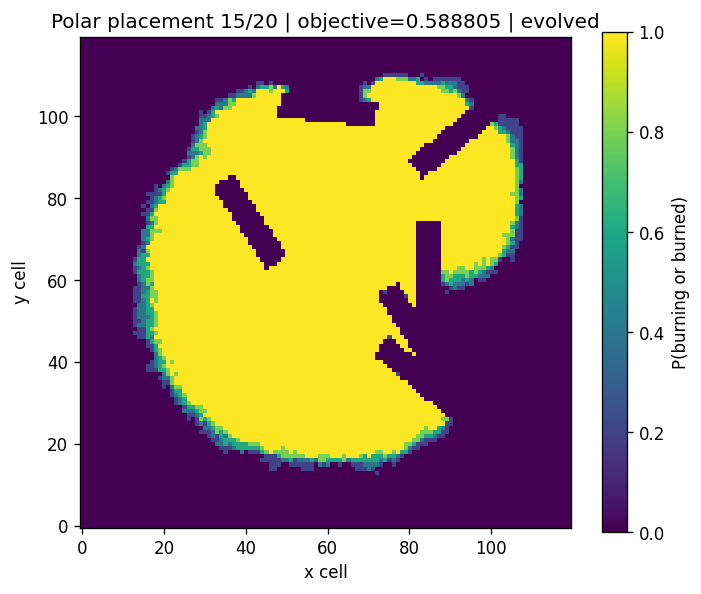

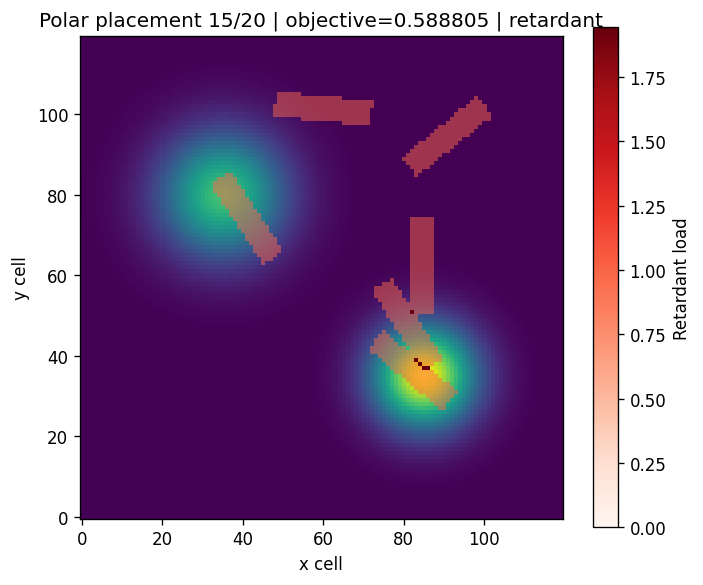

[Init polar] run 015/20 | objective=0.588805
Applying retardant drop: D=[[31.035 47.409  2.702]
 [46.475 53.775  0.869]
 [54.28  35.455  1.912]
 [62.247 74.018  4.932]
 [76.968 57.784  1.16 ]
 [81.127 52.405  2.421]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


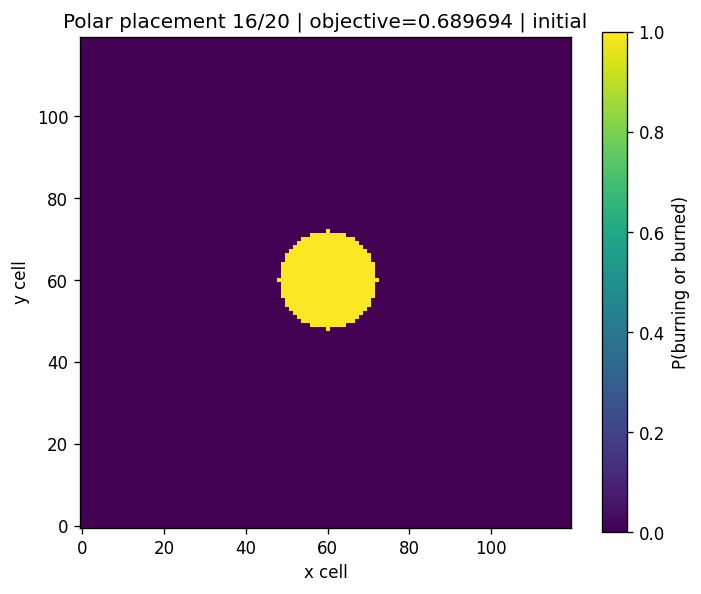

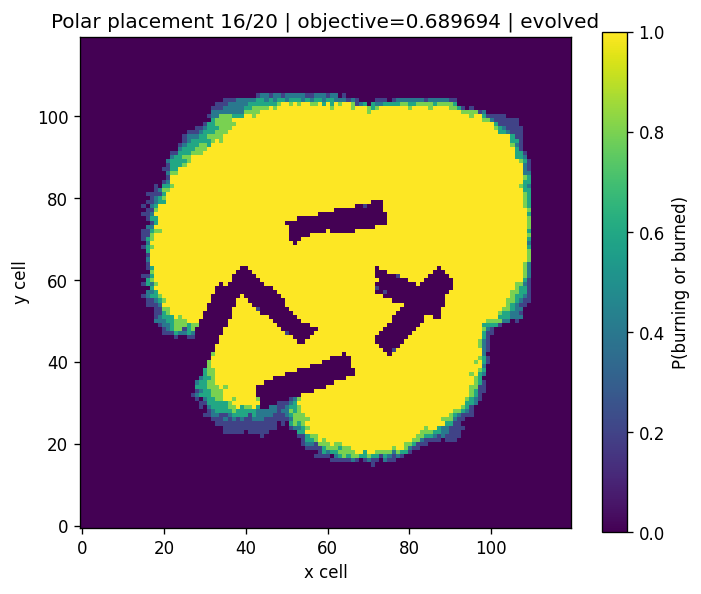

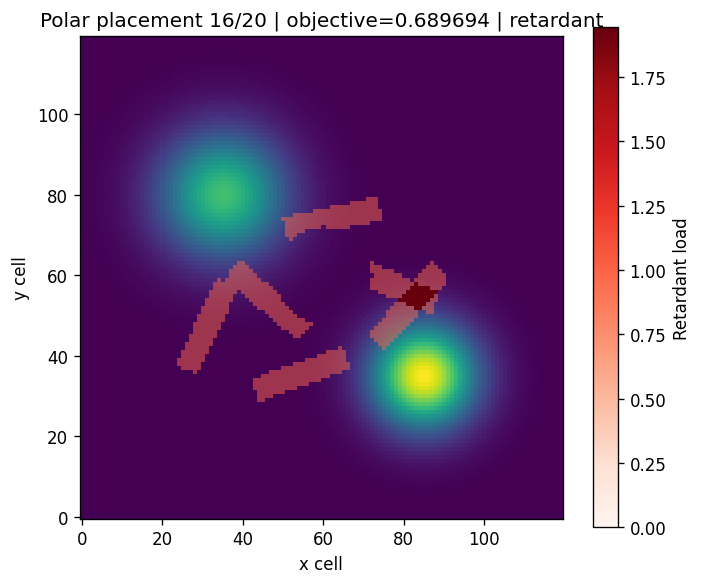

[Init polar] run 016/20 | objective=0.689694
Applying retardant drop: D=[[ 41.055  74.283   3.729]
 [ 59.951 101.427   4.612]
 [ 80.849  47.86    0.563]
 [ 82.199  36.351   0.883]
 [ 84.904  62.977   6.279]
 [ 90.694  94.545   5.389]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


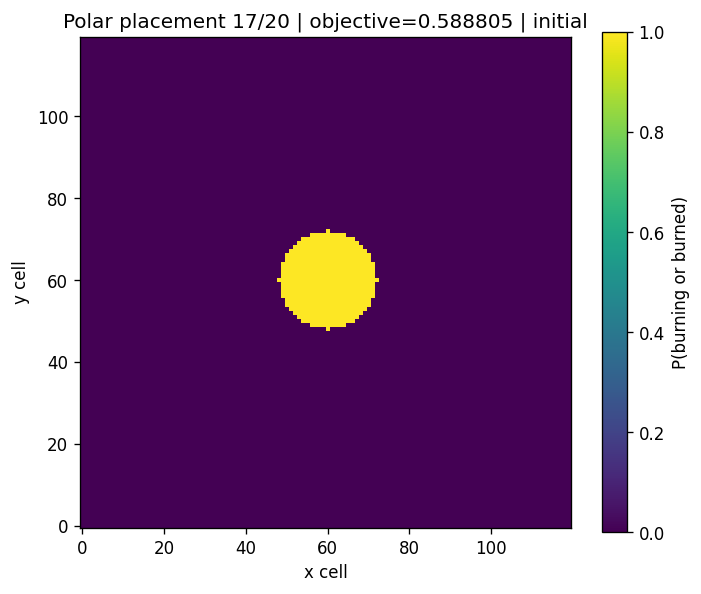

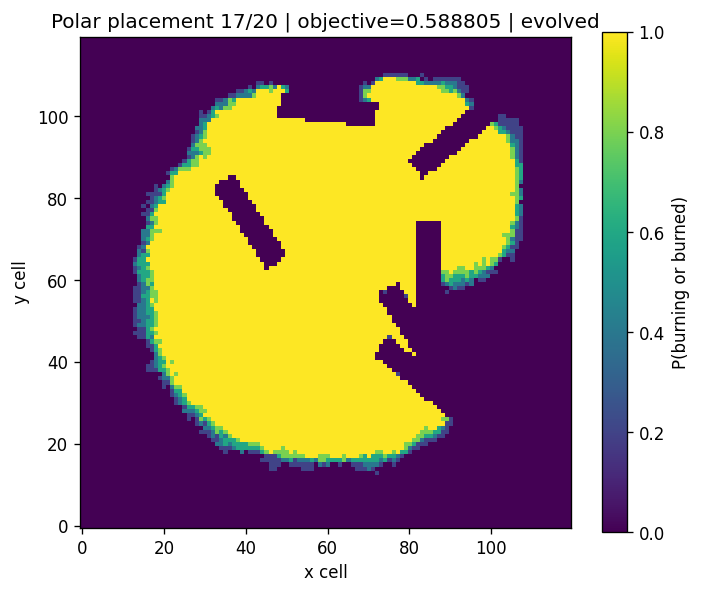

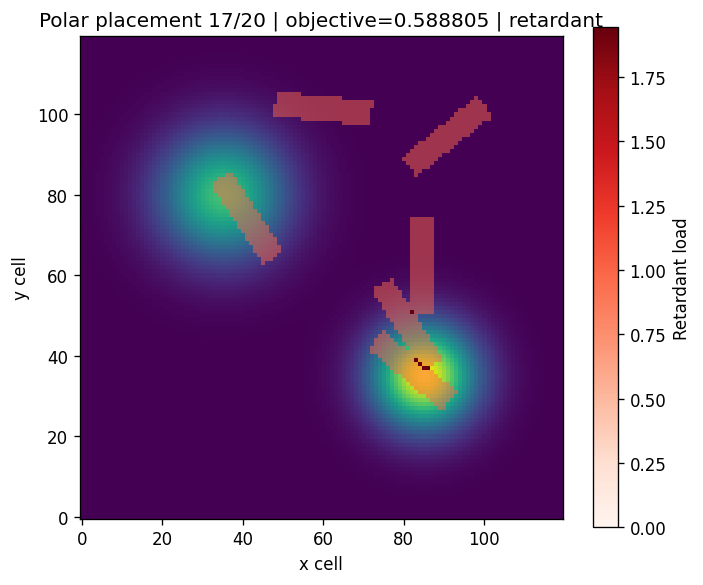

[Init polar] run 017/20 | objective=0.588805
Applying retardant drop: D=[[19.085 44.91   3.092]
 [30.263 31.243  1.543]
 [49.351 53.673  2.403]
 [53.083 74.174  1.311]
 [78.817 24.874  0.21 ]
 [86.118 68.187  3.723]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


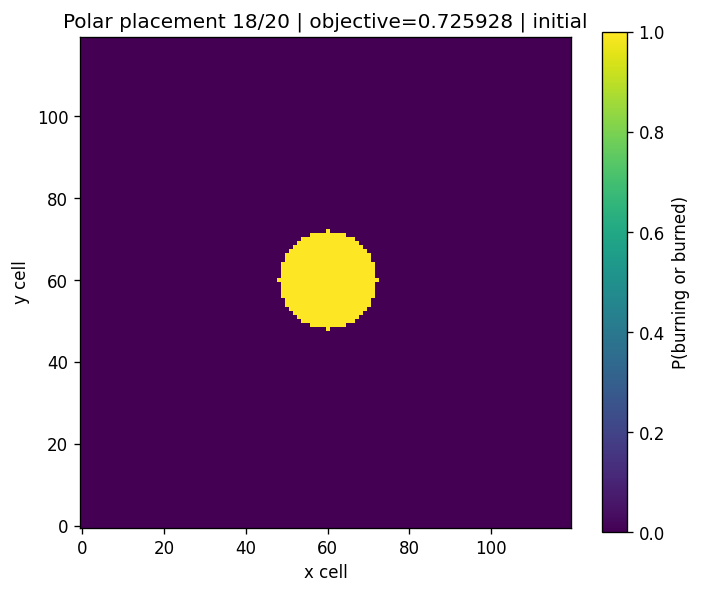

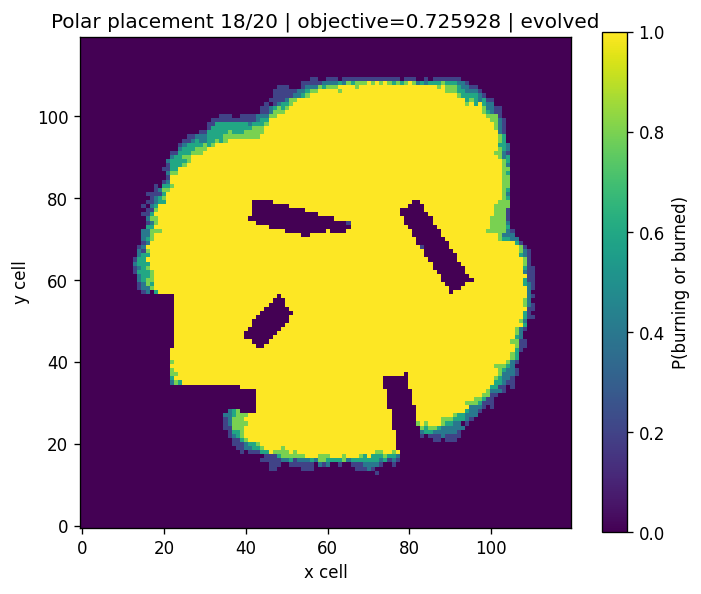

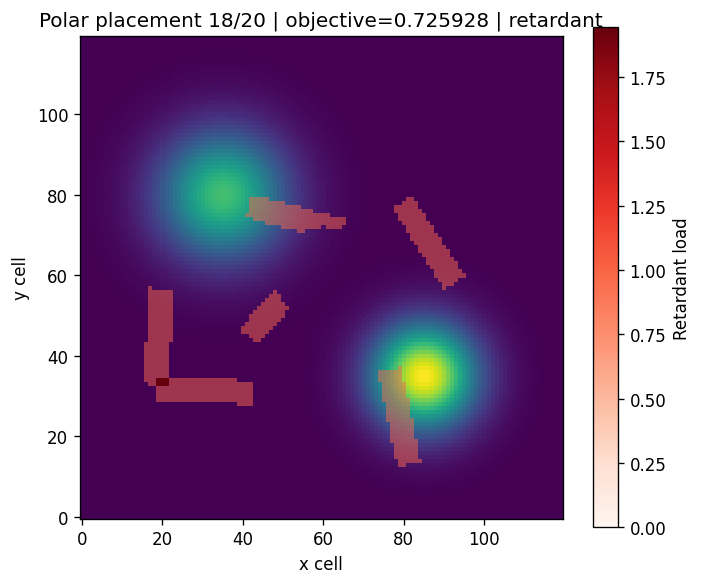

[Init polar] run 018/20 | objective=0.725928
Applying retardant drop: D=[[ 41.537  21.918   2.16 ]
 [ 58.151  77.959   5.091]
 [ 67.956  77.706   1.923]
 [ 73.988  78.265   1.072]
 [103.988  51.67    3.236]
 [107.509  56.149   3.874]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


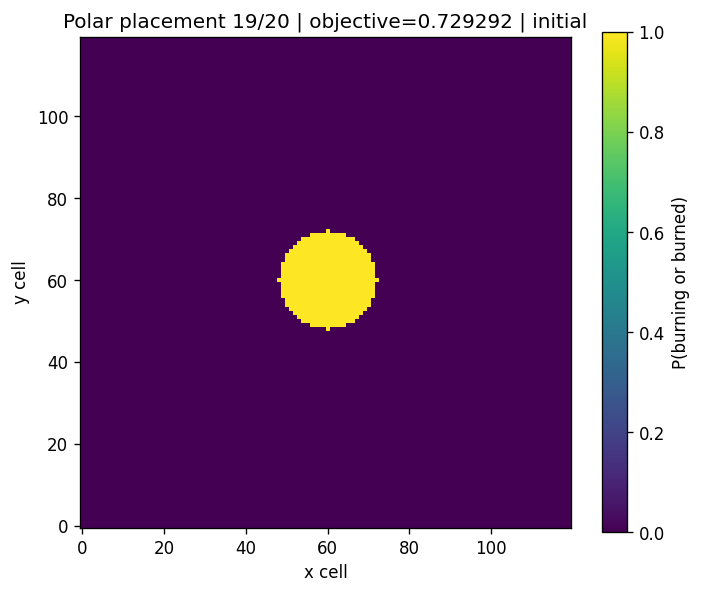

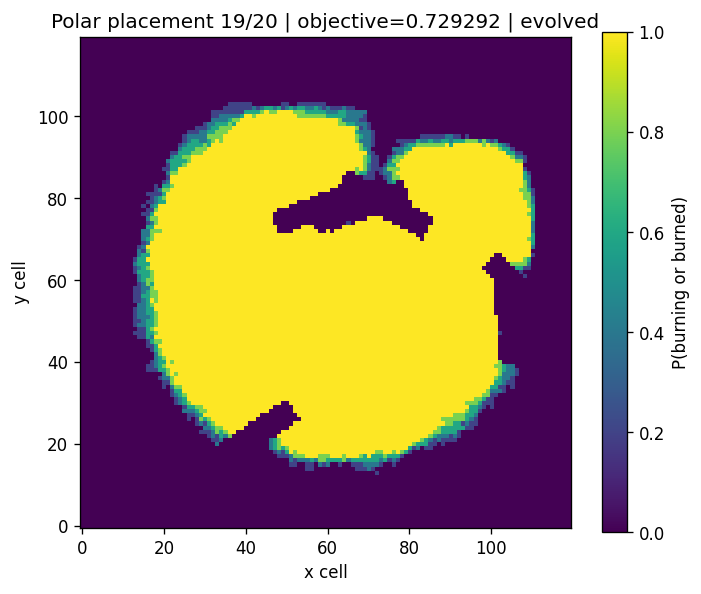

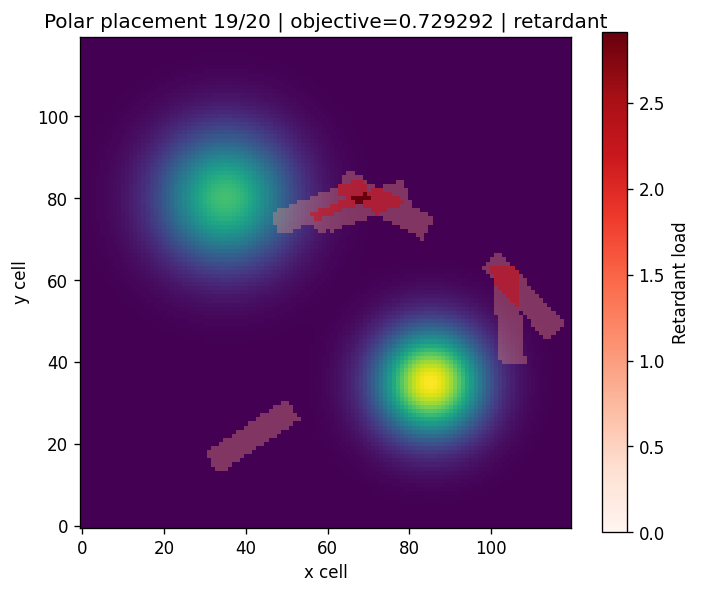

[Init polar] run 019/20 | objective=0.729292
Applying retardant drop: D=[[37.316 64.9    3.321]
 [37.348 55.388  2.953]
 [41.055 74.283  3.729]
 [80.849 47.86   0.563]
 [84.435 57.387  0.173]
 [84.46  68.036  6.106]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


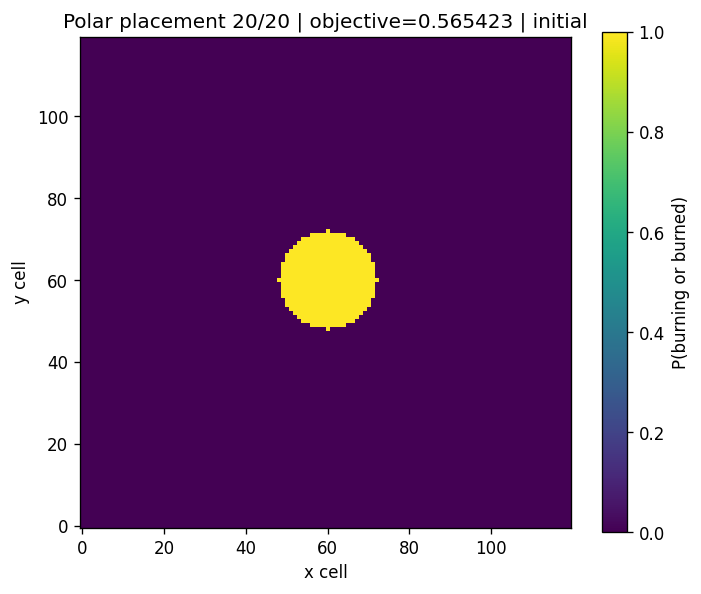

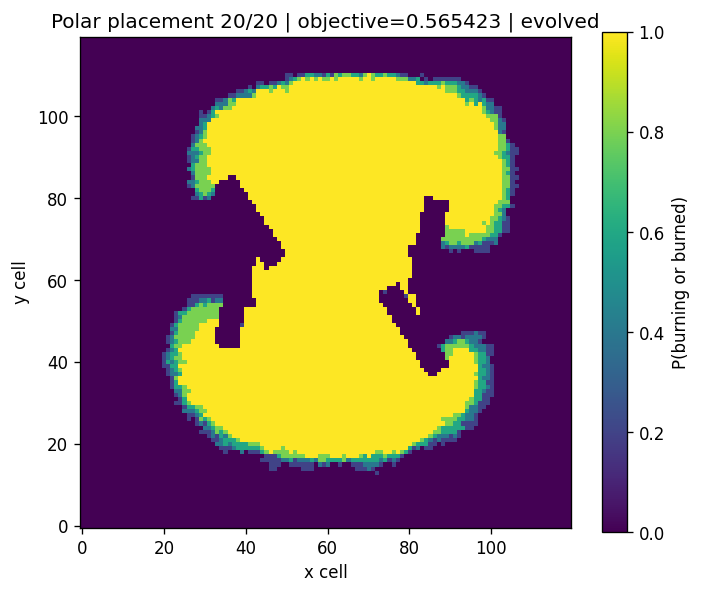

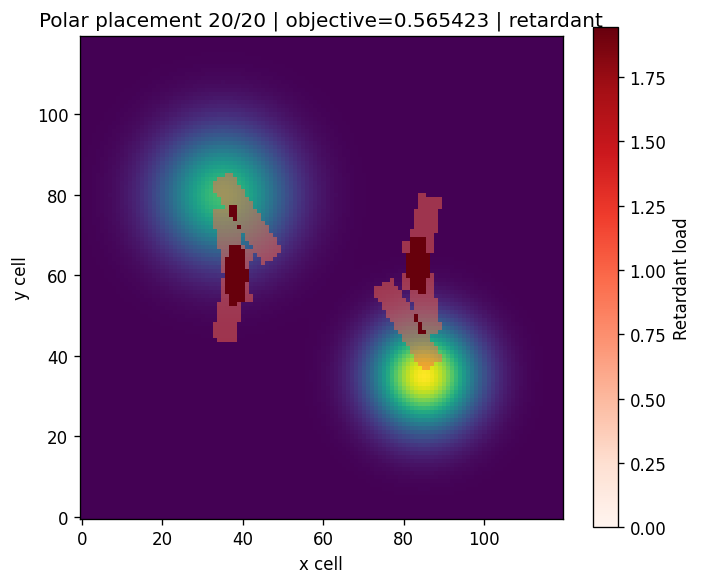

[Init polar] run 020/20 | objective=0.565423
Applying retardant drop: D=[[37.316 64.9    3.321]
 [37.348 55.388  2.953]
 [41.055 74.283  3.729]
 [80.849 47.86   0.563]
 [84.435 57.387  0.173]
 [84.46  68.036  6.106]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
Applying retardant drop: D=[[ 59.092 101.334   4.597]
 [ 70.314 101.598   4.782]
 [ 81.204  99.584   5.029]
 [ 90.694  94.545   5.389]
 [ 97.475  86.389   5.786]
 [100.971  76.123   6.101]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
Applying retardant drop: D=[[ 28.92   58.955   3.102]
 [ 74.588 101.13    4.864]
 [ 82.199  36.351   0.883]
 [ 90.694  94.545   5.389]
 [ 99.479  81.831   5.947]
 [101.79   65.007   0.023]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
Applying retardant drop: D=[[ 59.092 101.334   4.597]
 [ 70.314 101.598   4.782]
 [ 81.204  99.584   5.029]
 [ 90.694  94.545   5.389]
 [ 97.475  86.389   5.786]
 [100.971  76.123   6.101]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
Applying retardant drop: D=[[ 59.092 101.

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_m

[BO polar] iter 001/80 | y_next=0.660288 | best_y=0.581316 (no-improve) | EI_max=0.0127 | mu=0.586632 | std=0.0487
      objective (expected value burned) = 0.660288
      proposed (x,y,phi) per drone:
      [[ 37.464  76.257   5.103]
 [ 44.766  45.508   2.092]
 [ 46.166  75.387   2.816]
 [ 85.887  25.686   3.702]
 [ 97.931  52.506   1.992]
 [108.719  80.529   5.148]]
      gp.kernel_ = 0.87**2 * TiedXYFiMatern(lx=1e+03, ly=0.327, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)
Applying retardant drop: D=[[37.778 73.28   3.302]
 [38.33  53.61   3.069]
 [39.587 64.893  0.865]
 [71.773 44.665  1.092]
 [81.909 69.936  6.051]
 [86.495 62.788  6.164]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 7 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of pa

Applying retardant drop: D=[[ 50.285  69.928   3.215]
 [ 58.73   47.049   0.815]
 [ 73.971  34.949   4.957]
 [ 79.08  103.11    4.97 ]
 [ 80.005  42.841   0.52 ]
 [ 80.745  78.082   4.016]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[37.464 76.257  3.947]
 [37.862 64.787  2.539]
 [39.292 50.824  4.64 ]
 [86.377 66.04   0.073]
 [86.681 49.837  0.475]
 [87.038 51.586  0.219]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_mod

Applying retardant drop: D=[[35.054 74.918  3.063]
 [71.906 53.758  3.013]
 [73.012 61.01   2.453]
 [78.071 18.417  5.561]
 [78.346 79.991  3.197]
 [80.962 84.923  2.501]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[36.281 66.765  3.87 ]
 [36.9   52.555  3.115]
 [36.968 68.233  3.269]
 [77.817 47.211  0.224]
 [78.39  75.176  5.536]
 [79.411 59.79   0.109]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[ 44.229  29.761   2.867]
 [ 45.19   31.789   2.921]
 [ 45.69  103.7     3.005]
 [ 77.218  54.13    1.024]
 [ 77.225  22.314   2.8  ]
 [ 79.272  38.167   4.462]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[ 33.01   84.253   4.502]
 [ 37.61   29.323   1.774]
 [ 46.383  55.46    3.524]
 [ 78.087  22.623   2.549]
 [ 78.471  50.382   1.86 ]
 [ 82.042 101.187   0.996]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[36.161 66.239  3.288]
 [37.353 67.544  3.937]
 [38.253 63.727  3.189]
 [81.079 61.697  0.088]
 [81.68  75.544  5.589]
 [82.928 51.97   6.216]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[38.894 70.244  3.614]
 [40.135 49.045  2.411]
 [40.624 69.924  3.615]
 [76.317 43.005  0.911]
 [81.398 75.313  5.563]
 [81.996 57.856  0.127]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
[BO polar] iter 010/80 | y_next=0.587769 | best_y=0.567152 (no-improve) | EI_max=0.00661 | mu=0.566784 | std=0.0269
      objective (expected value burned) = 0.587769
      proposed (x,y,phi) per drone:
      [[38.894 70.244  3.614]
 [40.135 49.045  2.411]
 [40.624 69.924  3.615]
 [76.317 43.005  0.911]
 [81.398 75.313  5.563]
 [81.996 57.856  0.127]]
      gp.kernel_ = 0.855**2 * TiedXYFiMatern(lx=609, ly=0.33, lphi=2.75, nu=2.5) + WhiteKernel(noise_level=1e-06)
Applying retardant drop: D=[[38.045 71.861  4.441]
 [38.252 51.984  2.991]
 [41.648 67.941  3.636]
 [77.278 44.747  0.466]
 [80.695 52.979  0.49 ]
 [82.992 62.552  0.306]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is clo

Applying retardant drop: D=[[37.559 69.141  4.448]
 [39.793 52.639  3.123]
 [40.768 56.66   3.213]
 [80.525 49.082  0.096]
 [83.308 62.146  6.16 ]
 [84.194 64.817  0.212]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[33.187 68.272  4.15 ]
 [42.475 49.465  2.962]
 [43.51  74.179  3.892]
 [73.715 41.395  0.516]
 [79.552 56.61   0.079]
 [80.762 62.056  0.325]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[38.031 67.854  3.54 ]
 [38.09  62.301  3.137]
 [38.78  69.185  3.089]
 [80.348 50.677  0.21 ]
 [80.57  47.986  0.762]
 [82.992 62.552  5.999]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[36.676 76.078  4.613]
 [37.447 54.895  3.434]
 [42.664 71.928  3.821]
 [76.668 49.749  0.279]
 [80.347 57.414  6.187]
 [86.178 63.26   0.332]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[38.802 71.45   3.953]
 [39.44  51.97   2.95 ]
 [40.185 68.071  3.882]
 [71.398 40.387  0.416]
 [78.02  49.62   0.786]
 [83.311 62.623  0.096]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[36.051 65.712  3.988]
 [36.584 50.07   2.783]
 [43.595 68.844  3.893]
 [77.031 44.921  0.886]
 [80.843 54.331  0.1  ]
 [82.973 63.49   6.101]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[35.884 62.495  3.309]
 [36.004 55.058  3.099]
 [42.223 73.398  3.805]
 [70.021 43.564  1.282]
 [81.672 72.517  5.817]
 [83.962 58.375  6.258]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[37.792 71.999  4.307]
 [38.609 56.182  3.319]
 [41.618 67.028  3.253]
 [75.162 43.963  0.695]
 [80.265 56.996  0.431]
 [83.311 62.623  0.504]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[37.058 71.762  4.576]
 [41.045 45.993  2.681]
 [43.226 65.602  3.7  ]
 [75.227 45.641  0.844]
 [75.544 42.359  0.773]
 [80.444 61.985  0.353]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
[BO polar] iter 020/80 | y_next=0.618754 | best_y=0.559768 (no-improve) | EI_max=0.00449 | mu=0.584025 | std=0.0405
      objective (expected value burned) = 0.618754
      proposed (x,y,phi) per drone:
      [[37.058 71.762  4.576]
 [41.045 45.993  2.681]
 [43.226 65.602  3.7  ]
 [75.227 45.641  0.844]
 [75.544 42.359  0.773]
 [80.444 61.985  0.353]]
      gp.kernel_ = 0.841**2 * TiedXYFiMatern(lx=288, ly=1e+03, lphi=0.715, nu=2.5) + WhiteKernel(noise_level=1e-06)
Applying retardant drop: D=[[35.772 73.096  4.207]
 [41.78  45.952  3.012]
 [44.182 68.089  3.324]
 [78.364 48.482  0.242]
 [80.827 52.478  0.393]
 [83.791 65.694  0.077]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close t

Applying retardant drop: D=[[38.778 72.063  4.137]
 [42.08  47.464  3.161]
 [43.616 71.797  3.49 ]
 [81.808 50.193  0.408]
 [82.027 50.649  0.376]
 [87.216 67.468  0.232]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[36.436 68.422  4.164]
 [40.644 47.598  2.726]
 [41.628 66.131  3.715]
 [80.253 42.668  0.607]
 [81.159 53.351  0.488]
 [83.876 64.72   0.286]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[33.826 71.335  4.24 ]
 [43.025 45.754  2.82 ]
 [44.089 64.572  3.265]
 [76.738 47.303  0.521]
 [77.823 54.01   0.426]
 [84.585 62.906  0.185]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[39.278 71.777  4.422]
 [40.476 50.903  3.149]
 [42.529 69.917  3.754]
 [77.789 46.69   0.693]
 [79.38  51.467  0.598]
 [80.699 63.745  0.312]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[36.284 67.897  4.472]
 [40.476 50.903  2.747]
 [41.549 68.462  3.936]
 [75.855 43.388  0.511]
 [81.519 56.962  0.512]
 [82.992 62.552  0.143]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[33.266 72.277  4.179]
 [44.144 44.121  2.937]
 [44.653 65.495  2.936]
 [78.915 48.219  6.059]
 [82.231 48.395  6.251]
 [84.053 66.296  6.21 ]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[31.52  71.602  4.062]
 [42.509 45.938  2.992]
 [42.574 64.201  3.082]
 [80.711 50.05   5.86 ]
 [81.808 50.193  0.038]
 [83.041 66.415  0.285]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[33.993 66.794  3.995]
 [42.811 66.153  2.115]
 [45.224 43.127  2.591]
 [80.855 53.411  0.034]
 [81.145 50.922  0.333]
 [84.904 62.977  0.313]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[33.753 74.194  4.255]
 [41.566 45.767  2.955]
 [45.241 61.972  2.708]
 [78.02  42.955  0.511]
 [82.245 47.815  6.157]
 [85.001 66.648  6.232]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
[BO polar] iter 030/80 | y_next=0.513 | best_y=0.513 (improved) | EI_max=0.00328 | mu=0.573279 | std=0.0453
      objective (expected value burned) = 0.513
      proposed (x,y,phi) per drone:
      [[33.753 74.194  4.255]
 [41.566 45.767  2.955]
 [45.241 61.972  2.708]
 [78.02  42.955  0.511]
 [82.245 47.815  6.157]
 [85.001 66.648  6.232]]
      gp.kernel_ = 0.842**2 * TiedXYFiMatern(lx=0.0446, ly=0.0649, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)
Applying retardant drop: D=[[34.608 70.995  4.273]
 [42.833 43.43   2.595]
 [45.934 59.014  2.755]
 [79.378 43.928  0.266]
 [82.448 49.433  3.876]
 [86.178 63.26   2.142]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is cl

Applying retardant drop: D=[[34.784 72.249  3.947]
 [39.455 47.385  3.107]
 [47.303 63.08   2.952]
 [79.989 44.167  0.424]
 [83.063 48.642  6.191]
 [83.838 69.367  5.859]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[33.993 68.026  3.64 ]
 [38.526 46.744  2.173]
 [44.344 61.086  3.002]
 [78.711 44.984  0.686]
 [83.085 48.051  6.235]
 [84.861 64.504  1.619]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[33.747 73.469  3.98 ]
 [43.766 43.697  2.951]
 [45.898 60.437  0.962]
 [77.615 45.107  0.185]
 [81.686 47.482  6.051]
 [86.344 68.856  6.047]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[35.957 76.576  4.058]
 [39.193 47.839  3.063]
 [48.5   61.454  2.738]
 [80.749 42.322  0.263]
 [82.523 47.104  0.231]
 [84.199 71.823  5.839]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[34.042 71.919  3.93 ]
 [45.035 43.67   2.901]
 [47.218 58.971  2.315]
 [77.472 42.046  0.762]
 [81.808 50.193  6.149]
 [86.816 63.402  6.217]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[34.575 69.084  3.635]
 [43.413 44.053  2.995]
 [47.297 66.82   3.279]
 [77.87  42.405  1.086]
 [82.258 44.086  0.242]
 [83.583 70.331  5.764]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[33.32  75.961  4.344]
 [44.521 44.545  2.943]
 [45.358 57.374  0.359]
 [80.256 46.445  0.542]
 [81.675 46.903  6.241]
 [85.402 68.446  6.183]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[35.507 80.19   4.227]
 [42.634 42.425  2.6  ]
 [47.167 62.262  1.24 ]
 [78.2   45.311  0.093]
 [84.031 44.448  0.149]
 [85.815 64.777  2.466]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[34.511 73.075  4.313]
 [40.749 46.411  2.864]
 [46.821 61.763  2.541]
 [79.282 41.281  0.256]
 [80.849 47.86   0.347]
 [84.155 65.311  6.124]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
[BO polar] iter 040/80 | y_next=0.51362 | best_y=0.513 (no-improve) | EI_max=0.00316 | mu=0.533931 | std=0.0332
      objective (expected value burned) = 0.51362
      proposed (x,y,phi) per drone:
      [[34.511 73.075  4.313]
 [40.749 46.411  2.864]
 [46.821 61.763  2.541]
 [79.282 41.281  0.256]
 [80.849 47.86   0.347]
 [84.155 65.311  6.124]]
      gp.kernel_ = 0.83**2 * TiedXYFiMatern(lx=0.0396, ly=0.0714, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)
Applying retardant drop: D=[[34.311 75.365  4.277]
 [42.573 47.256  2.941]
 [43.783 59.41   0.35 ]
 [77.689 45.638  0.091]
 [81.662 48.624  0.289]
 [84.148 69.523  6.19 ]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[33.815 75.663  3.877]
 [41.805 50.09   3.005]
 [45.067 62.633  0.795]
 [79.447 46.872  6.226]
 [80.421 50.153  0.843]
 [85.931 69.25   0.104]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[35.026 74.21   3.988]
 [40.083 45.884  3.153]
 [45.407 64.198  3.244]
 [81.079 41.369  0.495]
 [81.118 48.296  0.451]
 [84.334 70.175  5.798]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[38.075 79.695  4.588]
 [41.925 43.993  3.071]
 [45.55  62.242  2.288]
 [75.593 40.917  0.505]
 [80.193 49.73   6.202]
 [82.488 67.676  6.276]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[38.592 74.75   4.725]
 [43.736 40.313  2.793]
 [45.185 63.261  2.423]
 [78.199 40.717  0.656]
 [79.332 50.056  0.484]
 [82.673 62.481  0.011]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[34.52  77.572  4.358]
 [42.696 37.894  2.75 ]
 [46.436 62.692  2.777]
 [79.043 45.374  0.303]
 [79.842 50.359  0.074]
 [85.821 69.777  0.136]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[36.965 78.171  4.625]
 [42.819 45.559  2.688]
 [45.907 66.449  2.846]
 [77.163 42.967  0.358]
 [77.503 49.372  0.081]
 [81.948 66.943  5.966]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[39.707 77.459  4.703]
 [42.302 47.64   2.62 ]
 [49.307 66.284  2.995]
 [75.163 40.611  0.415]
 [76.219 48.098  6.28 ]
 [79.659 73.307  5.437]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[36.642 79.251  4.156]
 [41.994 44.781  3.02 ]
 [45.252 63.574  2.376]
 [76.017 40.5    0.822]
 [77.503 49.372  6.238]
 [77.723 65.892  0.302]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[35.717 76.742  4.606]
 [41.636 47.113  2.749]
 [47.059 66.951  2.983]
 [73.258 43.208  0.412]
 [75.511 51.896  6.213]
 [85.465 65.207  5.916]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
[BO polar] iter 050/80 | y_next=0.46349 | best_y=0.448624 (no-improve) | EI_max=0.00106 | mu=0.498475 | std=0.039
      objective (expected value burned) = 0.46349
      proposed (x,y,phi) per drone:
      [[35.717 76.742  4.606]
 [41.636 47.113  2.749]
 [47.059 66.951  2.983]
 [73.258 43.208  0.412]
 [75.511 51.896  6.213]
 [85.465 65.207  5.916]]
      gp.kernel_ = 0.879**2 * TiedXYFiMatern(lx=0.116, ly=0.0658, lphi=3.11, nu=2.5) + WhiteKernel(noise_level=1e-06)
Applying retardant drop: D=[[38.589 78.424  4.908]
 [39.56  46.154  2.764]
 [46.97  67.367  2.748]
 [73.643 38.315  0.833]
 [78.086 54.756  6.002]
 [80.242 69.477  5.515]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 11 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of p

Applying retardant drop: D=[[37.228 76.429  4.757]
 [43.14  46.508  2.777]
 [47.291 67.924  2.959]
 [70.232 38.606  2.967]
 [73.796 49.858  6.1  ]
 [80.314 68.068  5.573]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[40.937 77.12   4.611]
 [48.357 43.569  2.45 ]
 [50.272 69.101  3.176]
 [70.196 37.678  2.794]
 [73.83  49.423  0.062]
 [74.717 65.463  5.204]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[38.113 75.082  4.702]
 [45.346 46.131  2.781]
 [46.003 67.925  2.866]
 [60.431 39.209  3.158]
 [72.776 50.006  6.113]
 [80.813 68.817  5.405]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[38.365 78.617  4.806]
 [40.97  51.168  2.925]
 [48.358 66.555  2.218]
 [74.41  39.084  2.854]
 [76.894 50.1    6.056]
 [77.543 68.753  5.562]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[36.617 77.647  4.829]
 [42.612 45.365  2.807]
 [48.358 66.555  3.028]
 [68.383 38.83   2.832]
 [74.896 47.906  5.855]
 [81.736 69.322  5.594]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[37.415 80.29   4.673]
 [43.14  46.508  2.776]
 [49.786 66.586  3.411]
 [70.025 40.682  2.332]
 [72.576 48.031  0.184]
 [86.267 67.116  5.528]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[38.736 79.101  5.321]
 [41.375 44.196  2.77 ]
 [46.43  66.925  2.851]
 [67.842 39.837  2.929]
 [75.417 54.483  5.649]
 [77.952 70.435  5.361]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[33.948 77.153  4.727]
 [41.858 47.289  3.254]
 [47.306 61.418  2.469]
 [71.223 40.62   3.109]
 [75.376 49.471  5.891]
 [78.664 74.816  5.108]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[34.19  76.992  4.605]
 [44.057 45.436  2.867]
 [47.387 65.122  3.18 ]
 [70.389 39.286  2.873]
 [78.364 48.482  5.652]
 [82.287 64.233  5.709]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
[BO polar] iter 060/80 | y_next=0.400502 | best_y=0.349245 (no-improve) | EI_max=0.00101 | mu=0.435971 | std=0.0566
      objective (expected value burned) = 0.400502
      proposed (x,y,phi) per drone:
      [[34.19  76.992  4.605]
 [44.057 45.436  2.867]
 [47.387 65.122  3.18 ]
 [70.389 39.286  2.873]
 [78.364 48.482  5.652]
 [82.287 64.233  5.709]]
      gp.kernel_ = 0.885**2 * TiedXYFiMatern(lx=0.0774, ly=0.0821, lphi=1.61, nu=2.5) + WhiteKernel(noise_level=1e-06)
Applying retardant drop: D=[[38.034 80.593  5.136]
 [40.827 45.812  2.884]
 [45.15  66.8    2.85 ]
 [71.833 38.055  3.124]
 [77.828 48.239  5.746]
 [79.33  68.936  5.332]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[38.251 80.389  4.935]
 [43.766 43.697  2.827]
 [48.885 65.932  2.891]
 [63.615 35.55   3.069]
 [75.601 46.454  6.024]
 [78.681 64.304  5.917]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[37.464 76.257  4.787]
 [39.851 44.284  2.826]
 [48.316 67.991  3.088]
 [70.682 39.727  3.204]
 [75.136 49.151  6.029]
 [78.419 68.395  5.591]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 10 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[37.937 84.501  5.1  ]
 [43.76  42.917  2.611]
 [48.328 63.638  3.046]
 [67.081 38.152  2.87 ]
 [78.427 53.058  5.329]
 [82.372 70.74   5.56 ]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[36.039 72.287  4.773]
 [44.921 41.904  2.771]
 [47.103 69.694  2.956]
 [68.991 38.741  2.75 ]
 [75.133 47.271  5.72 ]
 [83.104 65.945  5.675]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[33.22  77.634  4.873]
 [42.93  46.318  2.739]
 [47.692 68.044  3.488]
 [71.223 40.62   3.092]
 [76.615 52.719  5.456]
 [80.89  65.124  5.862]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[39.084 80.46   5.256]
 [40.405 44.037  2.486]
 [49.5   65.845  2.758]
 [65.863 35.601  3.103]
 [73.104 44.561  5.921]
 [80.444 61.985  5.577]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[38.032 82.418  4.909]
 [46.639 43.43   2.514]
 [52.788 69.288  3.157]
 [64.809 37.102  3.02 ]
 [76.613 50.22   5.777]
 [82.344 71.83   5.341]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[36.281 77.115  4.714]
 [41.193 46.762  2.619]
 [47.125 61.991  3.107]
 [67.685 38.028  3.2  ]
 [74.107 42.375  6.057]
 [81.463 65.797  5.556]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[34.19  76.992  4.762]
 [44.613 61.074  2.973]
 [47.445 40.138  2.54 ]
 [69.902 38.172  3.123]
 [78.706 78.149  5.03 ]
 [81.604 57.406  5.45 ]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
[BO polar] iter 070/80 | y_next=0.485256 | best_y=0.349245 (no-improve) | EI_max=0.000113 | mu=0.577453 | std=0.09
      objective (expected value burned) = 0.485256
      proposed (x,y,phi) per drone:
      [[34.19  76.992  4.762]
 [44.613 61.074  2.973]
 [47.445 40.138  2.54 ]
 [69.902 38.172  3.123]
 [78.706 78.149  5.03 ]
 [81.604 57.406  5.45 ]]
      gp.kernel_ = 0.968**2 * TiedXYFiMatern(lx=0.00233, ly=0.181, lphi=286, nu=2.5) + WhiteKernel(noise_level=1e-06)
Applying retardant drop: D=[[25.602 40.972  4.083]
 [73.88  96.836  4.47 ]
 [74.128 63.814  4.632]
 [78.409 94.266  4.563]
 [79.976 55.75   3.971]
 [93.206 39.596  4.294]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

Applying retardant drop: D=[[37.382 82.125  4.942]
 [44.137 47.99   2.871]
 [49.251 69.214  3.2  ]
 [66.527 36.87   2.813]
 [74.637 48.064  5.658]
 [79.808 61.843  5.604]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[40.331 87.087  4.851]
 [44.526 42.232  2.95 ]
 [48.588 64.088  3.271]
 [70.189 40.443  2.754]
 [72.053 43.793  5.79 ]
 [82.655 63.406  5.574]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[40.277 83.855  4.907]
 [46.311 47.17   3.121]
 [49.123 66.406  3.04 ]
 [68.598 34.799  2.514]
 [72.694 46.52   5.738]
 [77.905 61.418  5.502]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[38.658 80.876  5.234]
 [42.935 44.989  2.331]
 [50.334 66.834  3.498]
 [68.788 38.075  2.848]
 [73.399 45.961  5.553]
 [79.173 61.701  5.867]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[41.349 80.722  5.243]
 [43.578 43.485  2.324]
 [49.768 66.268  3.437]
 [61.799 36.508  3.356]
 [74.008 44.921  6.013]
 [78.855 61.63   5.605]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[37.635 80.092  5.183]
 [41.789 48.425  2.953]
 [48.147 67.737  2.727]
 [65.05  41.664  3.174]
 [73.277 53.346  5.878]
 [81.47  72.949  5.456]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[28.703 33.474  3.606]
 [30.531 47.942  5.156]
 [43.268 82.083  3.351]
 [48.37  67.585  3.796]
 [72.431 73.016  4.033]
 [76.891 71.615  3.522]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[38.468 80.186  5.592]
 [44.521 44.545  2.587]
 [46.55  65.138  2.403]
 [65.05  41.664  3.516]
 [72.805 51.49   6.135]
 [81.142 71.061  5.483]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:439: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


Applying retardant drop: D=[[39.701 84.549  5.396]
 [41.7   46.534  2.836]
 [46.659 65.424  2.632]
 [61.829 41.176  3.308]
 [68.737 50.312  5.943]
 [84.585 62.906  5.729]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
[BO polar] iter 080/80 | y_next=0.467053 | best_y=0.334501 (no-improve) | EI_max=0.00619 | mu=0.388169 | std=0.0672
      objective (expected value burned) = 0.467053
      proposed (x,y,phi) per drone:
      [[39.701 84.549  5.396]
 [41.7   46.534  2.836]
 [46.659 65.424  2.632]
 [61.829 41.176  3.308]
 [68.737 50.312  5.943]
 [84.585 62.906  5.729]]
      gp.kernel_ = 0.867**2 * TiedXYFiMatern(lx=18.1, ly=195, lphi=0.398, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO polar] done: best_y=0.334501
[BO polar] best params:
[[37.382 82.125  4.942]
 [44.137 47.99   2.871]
 [49.251 69.214  3.2  ]
 [66.527 36.87   2.813]
 [74.637 48.064  5.658]
 [79.808 61.843  5.604]]


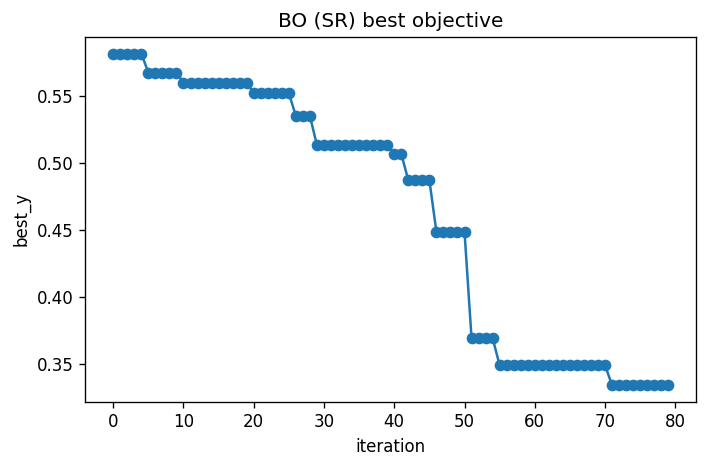

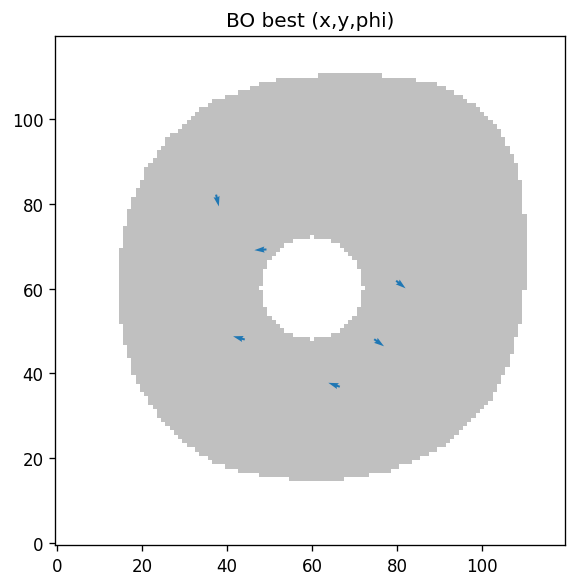

Applying retardant drop: D=[[37.382 82.125  4.942]
 [44.137 47.99   2.871]
 [49.251 69.214  3.2  ]
 [66.527 36.87   2.813]
 [74.637 48.064  5.658]
 [79.808 61.843  5.604]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


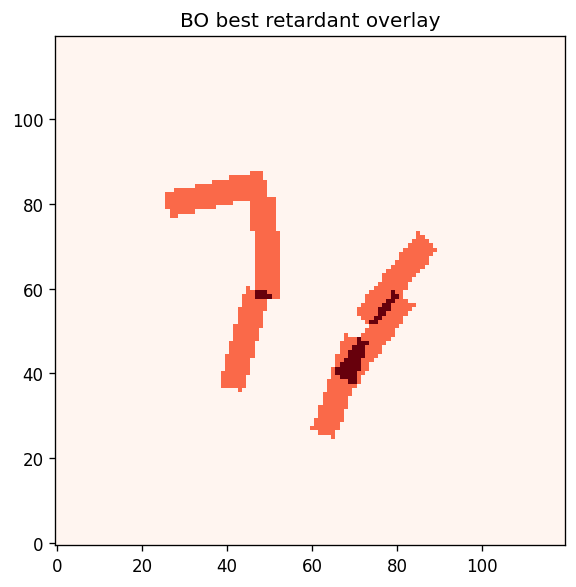

In [16]:
# BO in SR space.

best_theta, best_params, best_y, (X_feats, y_vals), y_nexts, y_bests = bo.run_bayes_opt_polar(
    n_init=20,
    n_iters=80,
    n_candidates=1500,
    xi=0.01,
    K_grid=300,
    boundary_field="affected",
    n_r=120,
    smooth_iters=300,
    omega=1.0,
    verbose=True,
    print_every=10,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.2,
    init_heuristic_kwargs=heuristic_kwargs,
    candidate_strategy="mixed",
    candidate_qmc="sobol",
    candidate_local_frac=0.5,
    candidate_local_top_k=5,
    candidate_local_sigma_s=0.05,
    candidate_local_sigma_r=0.05,
    candidate_local_sigma_delta_rad=np.deg2rad(12.0),
    candidate_local_resample_delta_prob=0.05,
)

plt.figure(figsize=(6, 4))
plt.plot(y_bests, marker="o")
plt.xlabel("iteration")
plt.ylabel("best_y")
plt.title("BO (SR) best objective")
plt.tight_layout()
plt.show()

plot_drop_overlay(bo.search_domain_mask, best_params, "BO best (x,y,phi)")
render_retardant(model, best_params, "BO best retardant overlay")

Applying retardant drop: D=[[37.382 82.125  4.942]
 [44.137 47.99   2.871]
 [49.251 69.214  3.2  ]
 [66.527 36.87   2.813]
 [74.637 48.064  5.658]
 [79.808 61.843  5.604]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


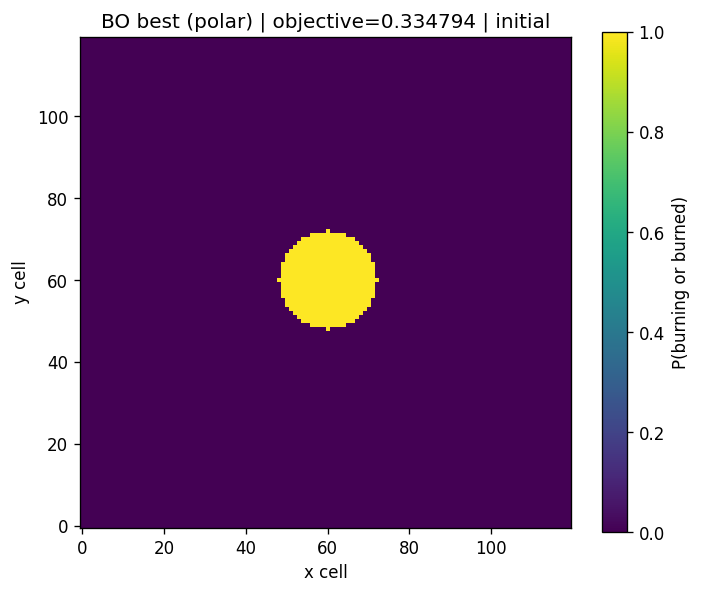

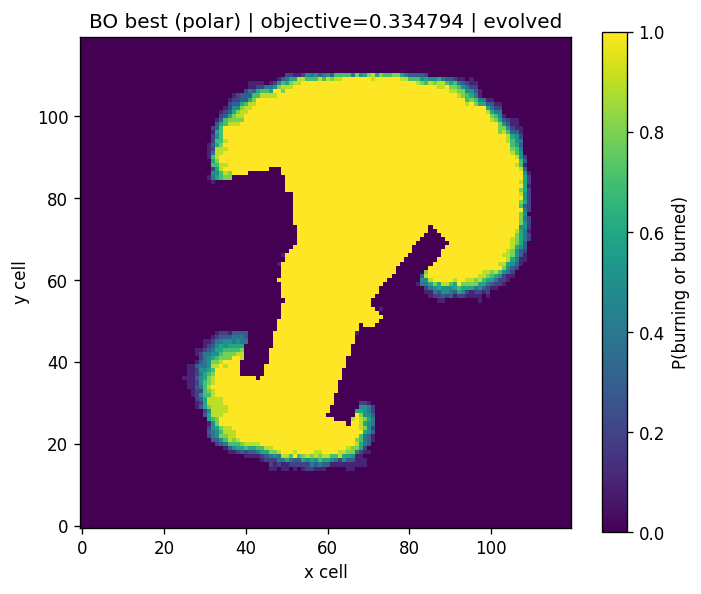

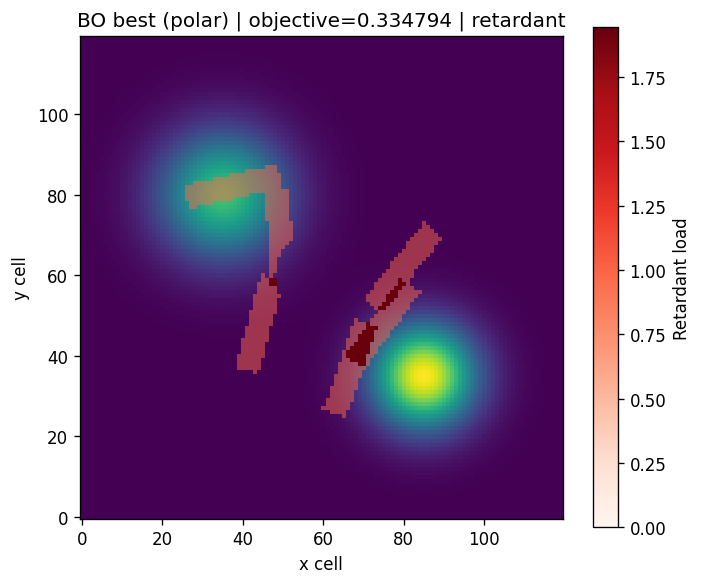

0.334794341628159

In [18]:
bo.plot_evolved_firestate_polar(
    best_theta,
    n_sims=10,  # override MC samples for the plot
    title_prefix="BO best (polar)",
)